# Homework 2
# Parsa Daghigh

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Imports

In [2]:
! pip install tensorpac
import scipy.io as sio
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from scipy.stats import mode
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mutual_info_score
from itertools import combinations
from scipy.spatial.distance import squareform, pdist
from scipy.stats import kendalltau
import statsmodels.api as sm
from tensorpac import Pac
from scipy.signal import welch
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.6/423.6 kB 8.4 MB/s eta 0:00:00


## Spike sorting from scratch

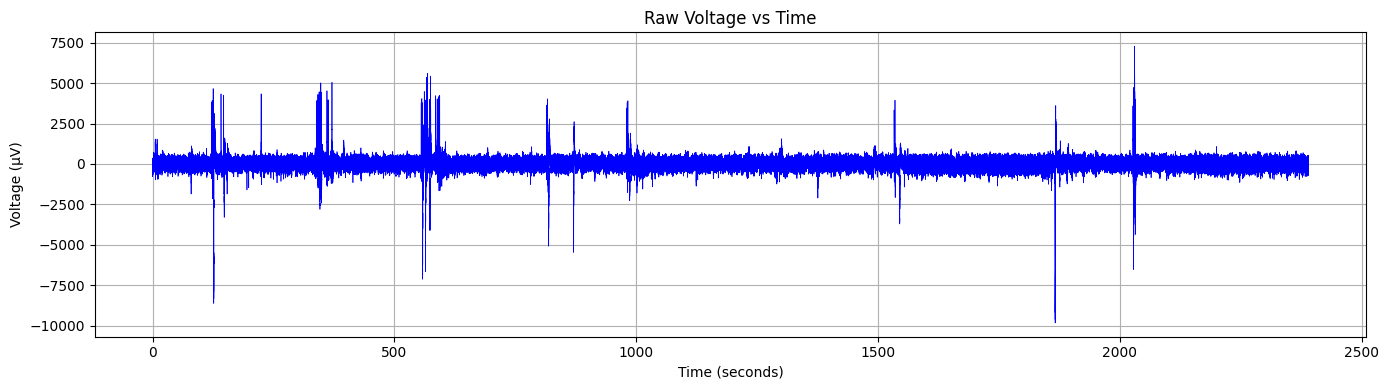

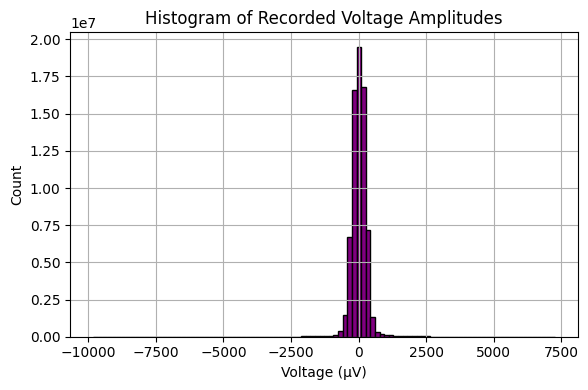

In [ ]:
file_path = '/content/drive/MyDrive/Cognitive_HW2/singleIT.mat'
with h5py.File(file_path, 'r') as f:

    signal = f['data_IT'][:]

signal = signal.flatten()

Fs = 30000
time = np.arange(signal.size) / Fs

# Plot 1: Voltage vs Time
plt.figure(figsize=(14, 4))
plt.plot(time, signal, color='blue', linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (µV)')
plt.title('Raw Voltage vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Histogram of Amplitudes
plt.figure(figsize=(6, 4))
plt.hist(signal, bins=100, color='purple', edgecolor='black')
plt.xlabel('Voltage (µV)')
plt.ylabel('Count')
plt.title('Histogram of Recorded Voltage Amplitudes')
plt.grid(True)
plt.tight_layout()
plt.show()

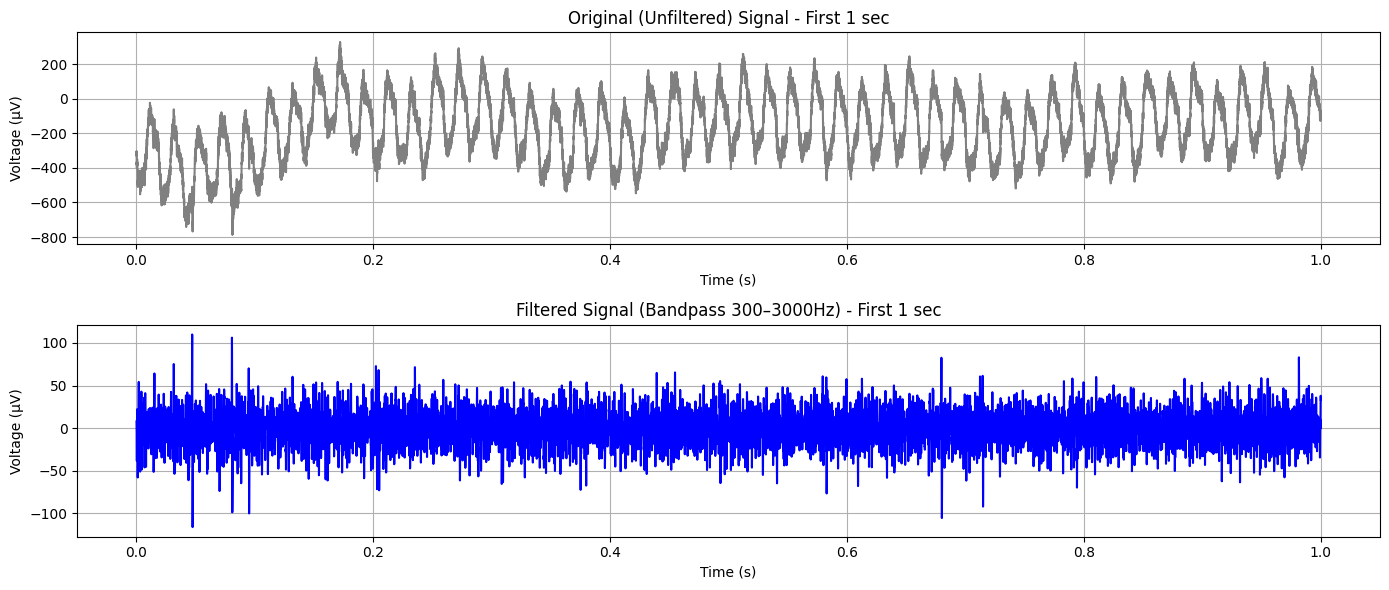

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

lowcut = 300
highcut = 3000
b, a = butter_bandpass(lowcut, highcut, Fs, order=3)
signal_filtered = filtfilt(b, a, signal)

# Plot original vs filtered
plt.figure(figsize=(14, 6))

plt.subplot(2,1,1)
plt.plot(time[:30000], signal[:30000], color='gray')
plt.title('Original (Unfiltered) Signal - First 1 sec')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time[:30000], signal_filtered[:30000], color='blue')
plt.title('Filtered Signal (Bandpass 300–3000Hz) - First 1 sec')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')
plt.grid(True)

plt.tight_layout()
plt.show()


Calculated threshold θ = 104.11 μV
Detected 29031 negative and 16405 positive peaks.
Total detected spikes: 45436
Extracted 45436 waveforms, each with 121 samples.


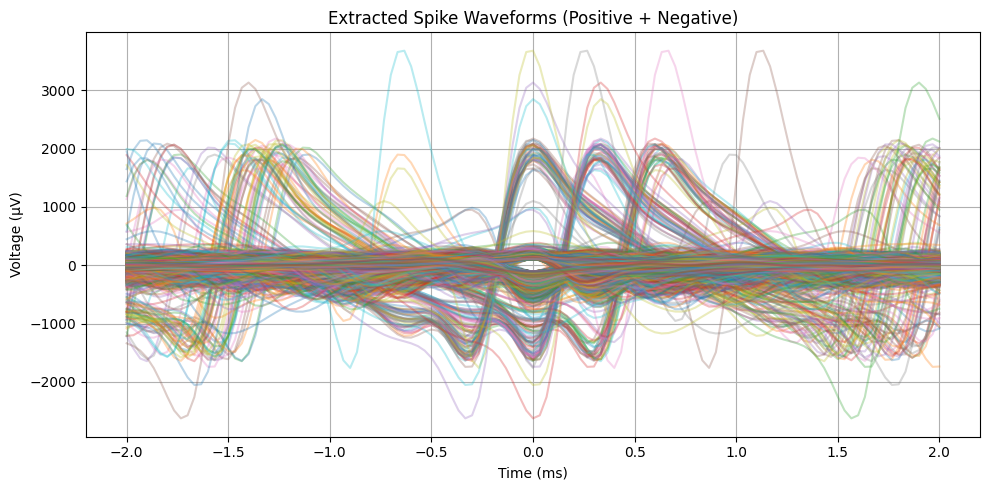

In [ ]:

# Calculate noise level (σ_n) and threshold θ
sigma_n = np.median(np.abs(signal_filtered)) / 0.6745
theta = 5 * sigma_n
print(f"Calculated threshold θ = {theta:.2f} μV")

# negative and positive spikes using threshold
neg_peaks, _ = find_peaks(-signal_filtered, height=theta)
pos_peaks, _ = find_peaks(signal_filtered, height=theta)

all_peaks = np.sort(np.concatenate((neg_peaks, pos_peaks)))
print(f"Detected {len(neg_peaks)} negative and {len(pos_peaks)} positive peaks.")
print(f"Total detected spikes: {len(all_peaks)}")

pre_samples = int(0.002 * Fs)
post_samples = int(0.002 * Fs)

valid_peaks = all_peaks[(all_peaks > pre_samples) & (all_peaks < len(signal_filtered) - post_samples)]

# spike waveforms
waveforms = []
for p in valid_peaks:
    wf = signal_filtered[p - pre_samples : p + post_samples + 1]
    waveforms.append(wf)
waveforms = np.array(waveforms)
print(f"Extracted {waveforms.shape[0]} waveforms, each with {waveforms.shape[1]} samples.")

plt.figure(figsize=(10, 5))
for wf in waveforms:
    plt.plot(np.linspace(-2, 2, waveforms.shape[1]), wf, alpha=0.3)
plt.title("Extracted Spike Waveforms (Positive + Negative)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.grid(True)
plt.tight_layout()
plt.show()

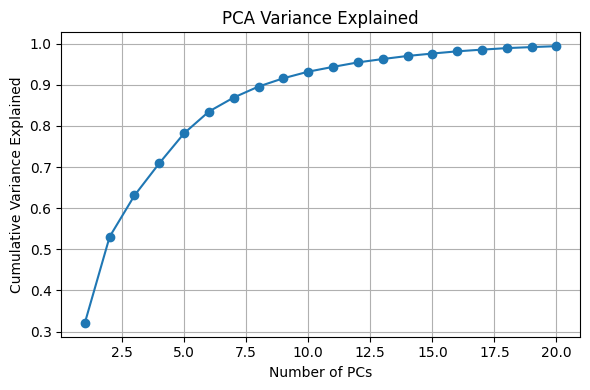

In [ ]:
pca = PCA()
pca.fit(waveforms)

scores = pca.transform(waveforms)

# Variance explained
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, 21), cum_explained[:20], marker='o')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
PC1 = scores[:, 0]
PC2 = scores[:, 1]
PC3 = scores[:, 2]

print(f"Variance explained by PC1–PC3: {cum_explained[2]*100:.1f}%")

Variance explained by PC1–PC3: 63.1%


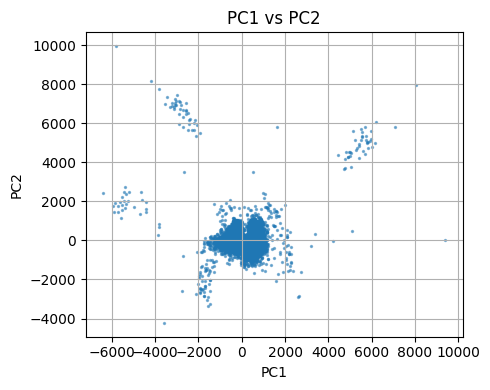

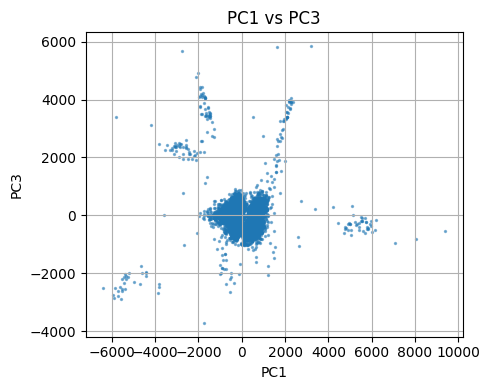

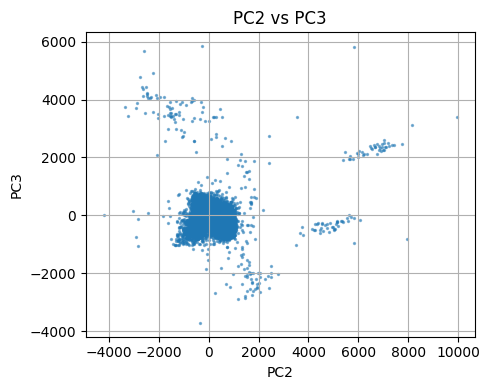

In [ ]:
# PC1 vs PC2
plt.figure(figsize=(5,4))
plt.scatter(PC1, PC2, s=2, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2')
plt.grid(True)
plt.tight_layout()
plt.show()

# PC1 vs PC3
plt.figure(figsize=(5,4))
plt.scatter(PC1, PC3, s=2, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('PC1 vs PC3')
plt.grid(True)
plt.tight_layout()
plt.show()

# PC2 vs PC3
plt.figure(figsize=(5,4))
plt.scatter(PC2, PC3, s=2, alpha=0.5)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PC2 vs PC3')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
n_pcs = 3
features = scores[:, :n_pcs]

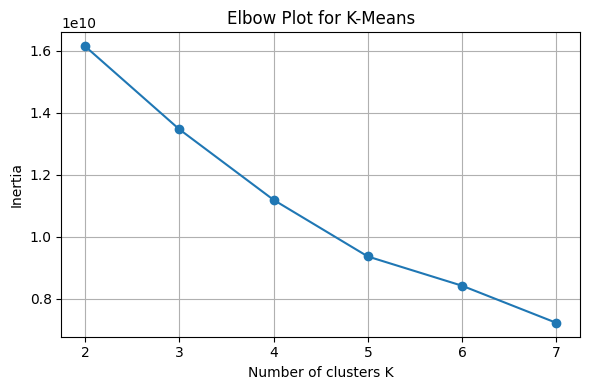

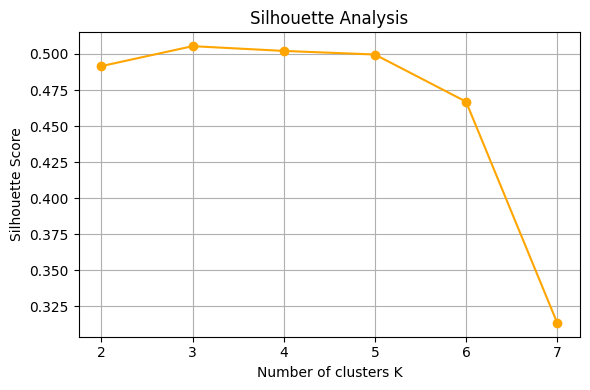

In [ ]:
inertias = []
silhouettes = []
K_range = range(2, 8)  # K = 2…7

for K in K_range:
    km = KMeans(n_clusters=K, random_state=0).fit(features)
    inertias.append(km.inertia_)
    sil = silhouette_score(features, km.labels_)
    silhouettes.append(sil)

# Elbow curve
plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means')
plt.grid(True)
plt.tight_layout()
plt.show()

# Silhouette scores
plt.figure(figsize=(6,4))
plt.plot(list(K_range), silhouettes, marker='o', color='orange')
plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
best_K = 3
km = KMeans(n_clusters=best_K, random_state=0).fit(features)
labels = km.labels_

print(f"Clustering done with K = {best_K}.")

Clustering done with K = 3.


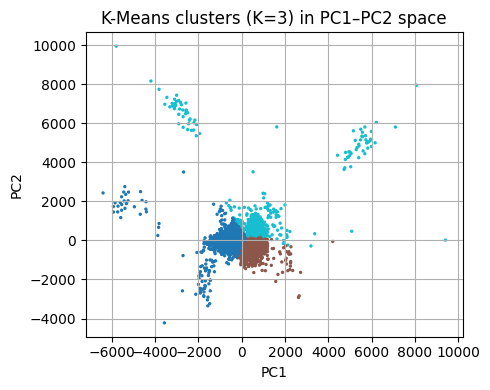

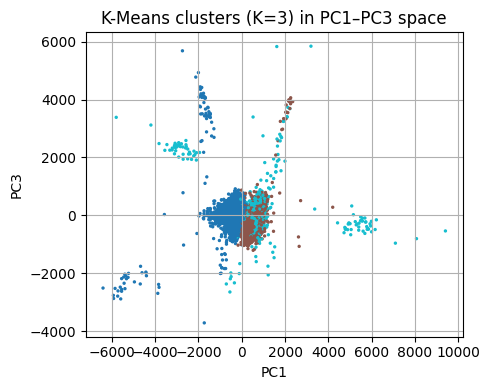

In [ ]:
# PC1 vs PC2
plt.figure(figsize=(5,4))
plt.scatter(features[:,0], features[:,1], c=labels, s=2, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-Means clusters (K={best_K}) in PC1–PC2 space')
plt.grid(True)
plt.tight_layout()
plt.show()

# PC1 vs PC3
plt.figure(figsize=(5,4))
plt.scatter(features[:,0], features[:,2], c=labels, s=2, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title(f'K-Means clusters (K={best_K}) in PC1–PC3 space')
plt.grid(True)
plt.tight_layout()
plt.show()

#### First threshold

In [ ]:
def get_spike_onsets(indices):
    """Returns the first sample of each continuous spike segment."""
    diffs = np.diff(indices)
    boundaries = np.where(diffs > 1)[0] + 1
    onsets = np.insert(indices[boundaries], 0, indices[0])
    return onsets


In [ ]:
scaling_factor = len(signal_filtered) / max(true_times)
true_times_rescaled = (true_times * 1000).astype(int)


In [ ]:
T = len(signal_filtered) / Fs   # in seconds
with h5py.File('/content/drive/MyDrive/Cognitive_HW2/Spikes.mat', 'r') as f:
    gt_down = np.array(f['ind_spikes_it']).flatten()
gt_time = np.linspace(0, T, len(gt_down))  # spread them over T seconds
gt_resampled = (gt_time * Fs).astype(int)


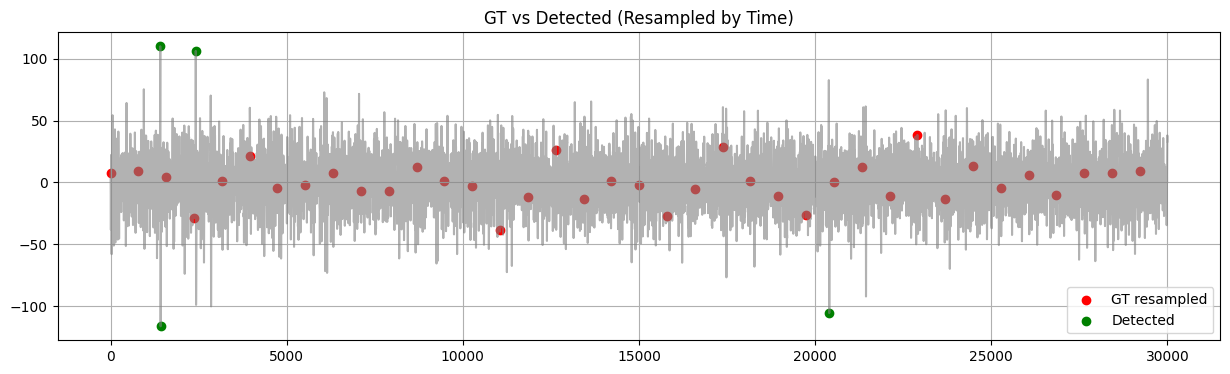

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(signal_filtered[:30000], color='gray', alpha=0.6)
plt.scatter(gt_resampled[(gt_resampled < 30000)], signal_filtered[gt_resampled[(gt_resampled < 30000)]], color='red', label='GT resampled')
plt.scatter(valid_peaks_trimmed[(valid_peaks_trimmed < 30000)], signal_filtered[valid_peaks_trimmed[(valid_peaks_trimmed < 30000)]], color='green', label='Detected')
plt.legend()
plt.title("GT vs Detected (Resampled by Time)")
plt.grid(True)
plt.show()


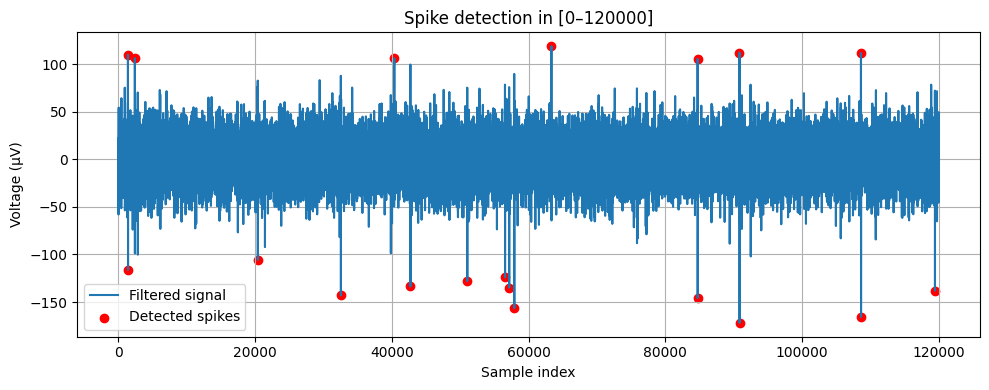

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(signal_filtered[:120000], label='Filtered signal')
plt.scatter(valid_peaks_trimmed, signal_filtered[valid_peaks_trimmed], color='red', label='Detected spikes')
plt.title("Spike detection in [0–120000]")
plt.xlabel("Sample index")
plt.ylabel("Voltage (µV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### New threshold

New threshold θ_new = 154.71 µV
Detected 3 negative and 0 positive peaks.
Total spikes in [0–12000]: 3


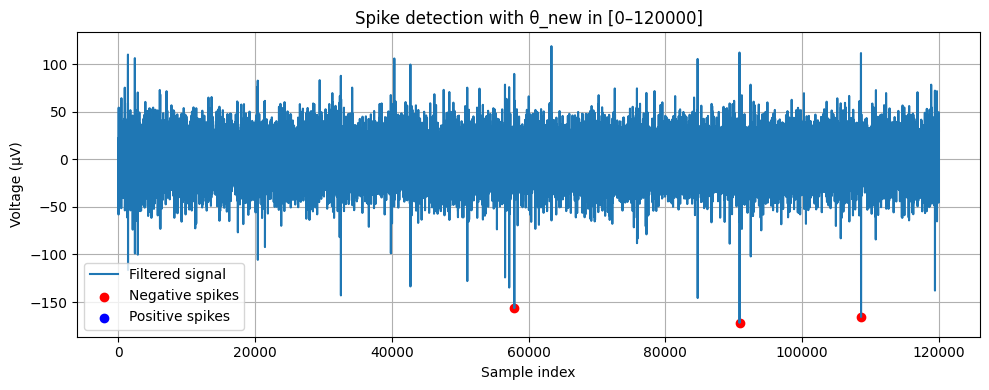

In [ ]:
eval_region = signal_filtered[:120000]

theta_new = 0.9 * np.max(np.abs(eval_region))
print(f"New threshold θ_new = {theta_new:.2f} µV")

neg_peaks, _ = find_peaks(-eval_region, height=theta_new)
pos_peaks, _ = find_peaks(eval_region, height=theta_new)

all_peaks = np.sort(np.concatenate([neg_peaks, pos_peaks]))
print(f"Detected {len(neg_peaks)} negative and {len(pos_peaks)} positive peaks.")
print(f"Total spikes in [0–12000]: {len(all_peaks)}")

plt.figure(figsize=(10, 4))
plt.plot(eval_region, label='Filtered signal')
plt.scatter(neg_peaks, eval_region[neg_peaks], color='red', label='Negative spikes')
plt.scatter(pos_peaks, eval_region[pos_peaks], color='blue', label='Positive spikes')
plt.title("Spike detection with θ_new in [0–120000]")
plt.xlabel("Sample index")
plt.ylabel("Voltage (µV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Calculated threshold θ = 58.05 µV (3 × σₙ)
Detected 119 negative and 89 positive peaks.
Total detected spikes: 208


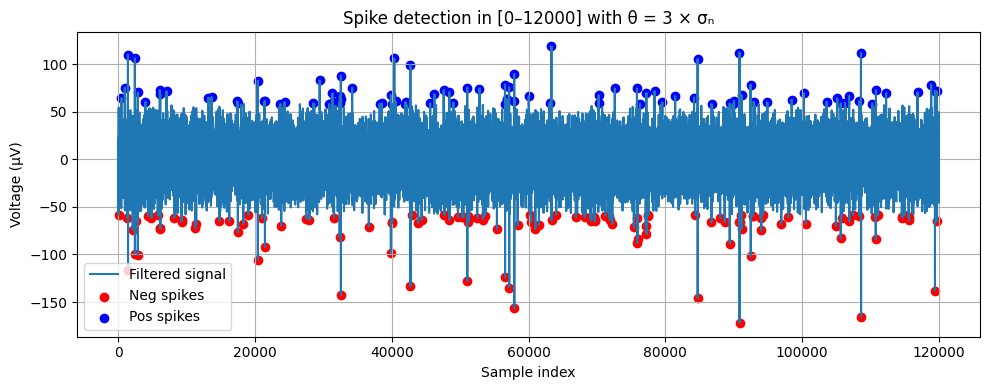

In [ ]:
eval_region = signal_filtered[:120000]

sigma_n = np.median(np.abs(eval_region)) / 0.6745
theta = 3 * sigma_n  # Use a lower multiplier than 5
print(f"Calculated threshold θ = {theta:.2f} µV (3 × σₙ)")

neg_peaks, _ = find_peaks(-eval_region, height=theta)
pos_peaks, _ = find_peaks(eval_region, height=theta)
all_peaks = np.sort(np.concatenate([neg_peaks, pos_peaks]))
print(f"Detected {len(neg_peaks)} negative and {len(pos_peaks)} positive peaks.")
print(f"Total detected spikes: {len(all_peaks)}")

plt.figure(figsize=(10, 4))
plt.plot(eval_region, label='Filtered signal')
plt.scatter(neg_peaks, eval_region[neg_peaks], color='red', label='Neg spikes')
plt.scatter(pos_peaks, eval_region[pos_peaks], color='blue', label='Pos spikes')
plt.title("Spike detection in [0–12000] with θ = 3 × σₙ")
plt.xlabel("Sample index")
plt.ylabel("Voltage (µV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Using tSNE instead of PCA

In [ ]:
max_spikes = 10000
idx = np.random.choice(len(waveforms), size=min(max_spikes, len(waveforms)), replace=False)
wave_sub = waveforms[idx]

tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=0, verbose=1)
features_tsne = tsne.fit_transform(wave_sub)  # shape: (n_samples, 3)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 1.519s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 104.894438
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.139793
[t-SNE] KL divergence after 1000 iterations: 1.614681


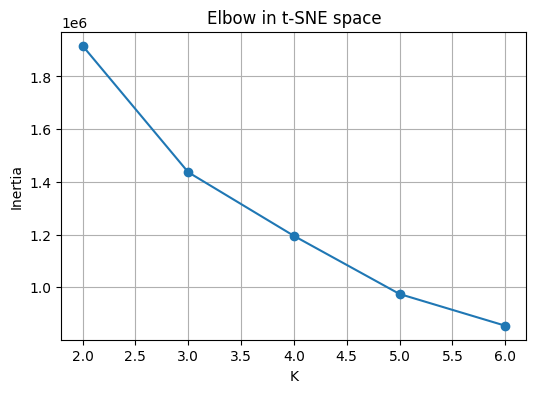

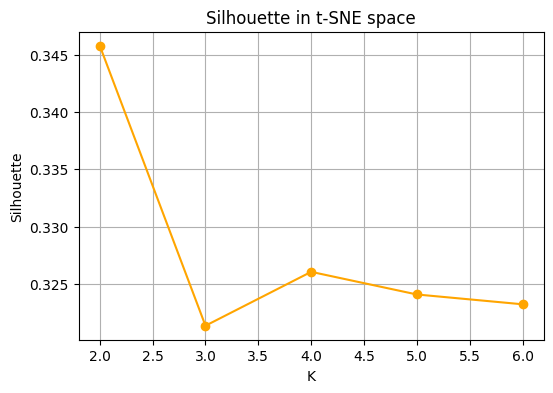

In [ ]:
Ks = range(2, 7)
inertias = []
sils = []

for K in Ks:
    km = KMeans(n_clusters=K, random_state=0).fit(features_tsne)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(features_tsne, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.title('Elbow in t-SNE space'); plt.xlabel('K'); plt.ylabel('Inertia'); plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(Ks, sils, marker='o', color='orange')
plt.title('Silhouette in t-SNE space'); plt.xlabel('K'); plt.ylabel('Silhouette'); plt.grid(True)
plt.show()

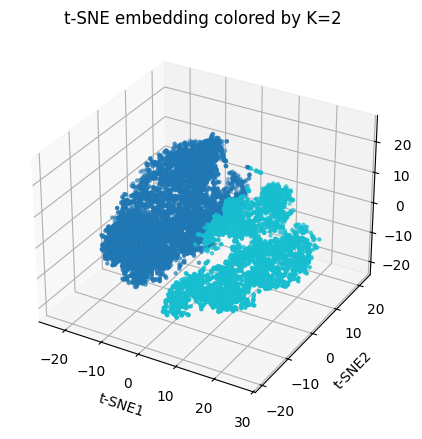

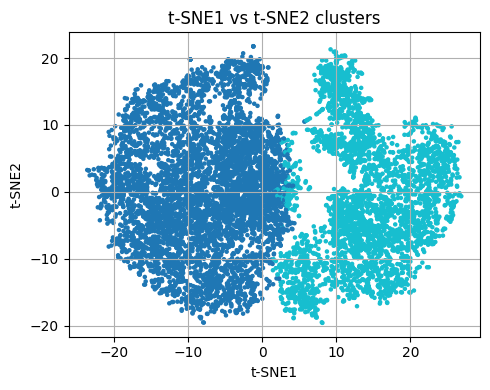

In [ ]:
best_K = 2
km = KMeans(n_clusters=best_K, random_state=0).fit(features_tsne)
labels_tsne = km.labels_

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(features_tsne[:,0], features_tsne[:,1], features_tsne[:,2],
                c=labels_tsne, s=5, cmap='tab10')
ax.set_xlabel('t-SNE1'); ax.set_ylabel('t-SNE2'); ax.set_zlabel('t-SNE3')
plt.title(f't-SNE embedding colored by K={best_K}')
plt.show()

# 2D pairwise
plt.figure(figsize=(5,4))
plt.scatter(features_tsne[:,0], features_tsne[:,1], c=labels_tsne, s=5, cmap='tab10')
plt.xlabel('t-SNE1'); plt.ylabel('t-SNE2')
plt.title('t-SNE1 vs t-SNE2 clusters')
plt.grid(True); plt.tight_layout(); plt.show()


## Analysis of Single Neuron Activity

### PSTH

In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define functions to read data from the .mat file
def dereference(data, file):
    """Dereferences HDF5 object references within the dataset."""
    # Use np.vectorize to apply the lambda function to each element in data
    # otypes=[object] is used because the output type might vary
    return np.vectorize(lambda ref: read_matlab_file(file[ref], file), otypes=[object])(data)

def read_matlab_file(file_obj, file):
    """Recursively reads data from HDF5 file objects (Dataset or Group)."""
    if isinstance(file_obj, h5py.Dataset):
        # Read dataset content and remove singleton dimensions
        data = file_obj[()].squeeze()
        # Check if the data type is an HDF5 reference
        if data.dtype == h5py.ref_dtype:
            # If it's a reference, dereference it
            data = dereference(data, file)
    elif isinstance(file_obj, h5py.Group):
        # If it's a group, create a dictionary and recursively read its members
        data = {}
        for subvar in file_obj.keys():
            data[subvar] = read_matlab_file(file_obj[subvar], file)
    else:
        # Return the file object itself if it's neither Dataset nor Group (e.g., a reference that couldn't be resolved)
        data = file_obj
    return data

# Load data from the .mat file
# Ensure 'dataVasati.mat' is in the same directory or provide the full path
try:
    with h5py.File('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat', 'r') as file:
        # Read the main SpikeTrain_it_all structure
        dataVasati = read_matlab_file(file['SpikeTrain_it_all'], file)
        # Extract 'data' and 'cm' (cell information)
        data = dataVasati['data']
        cm = dataVasati['cm']
except FileNotFoundError:
    print("Error: 'dataVasati.mat' not found. Please ensure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the .mat file: {e}")
    exit()


# Transpose each trial's data for each neuron
# The original data seems to have time points as rows and trials as columns,
# but for PSTH calculation, we usually want trials as rows and time points as columns.
# This step transposes each individual trial array within the 'data' object array.
data = np.vectorize(lambda arr: arr.T, otypes=[object])(data)


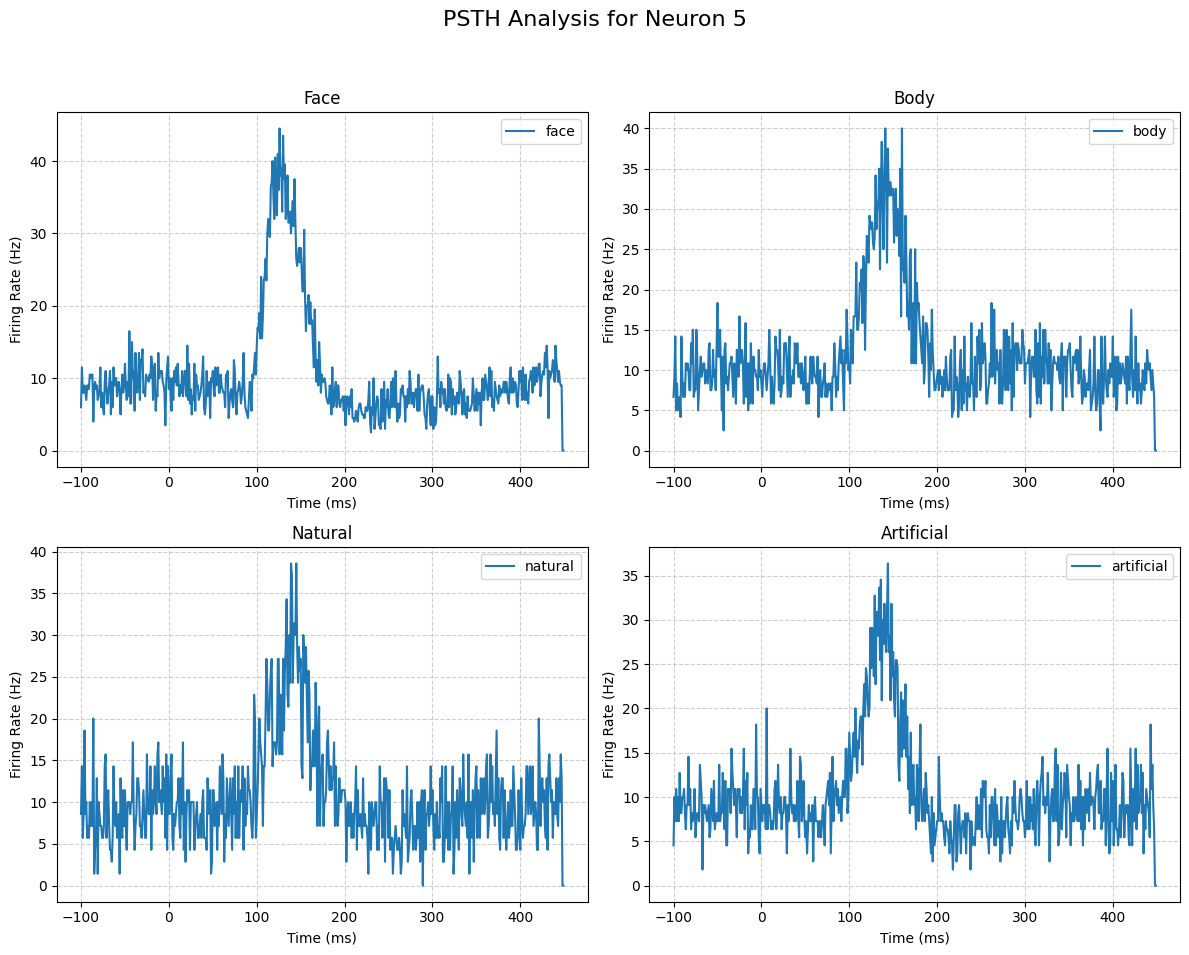

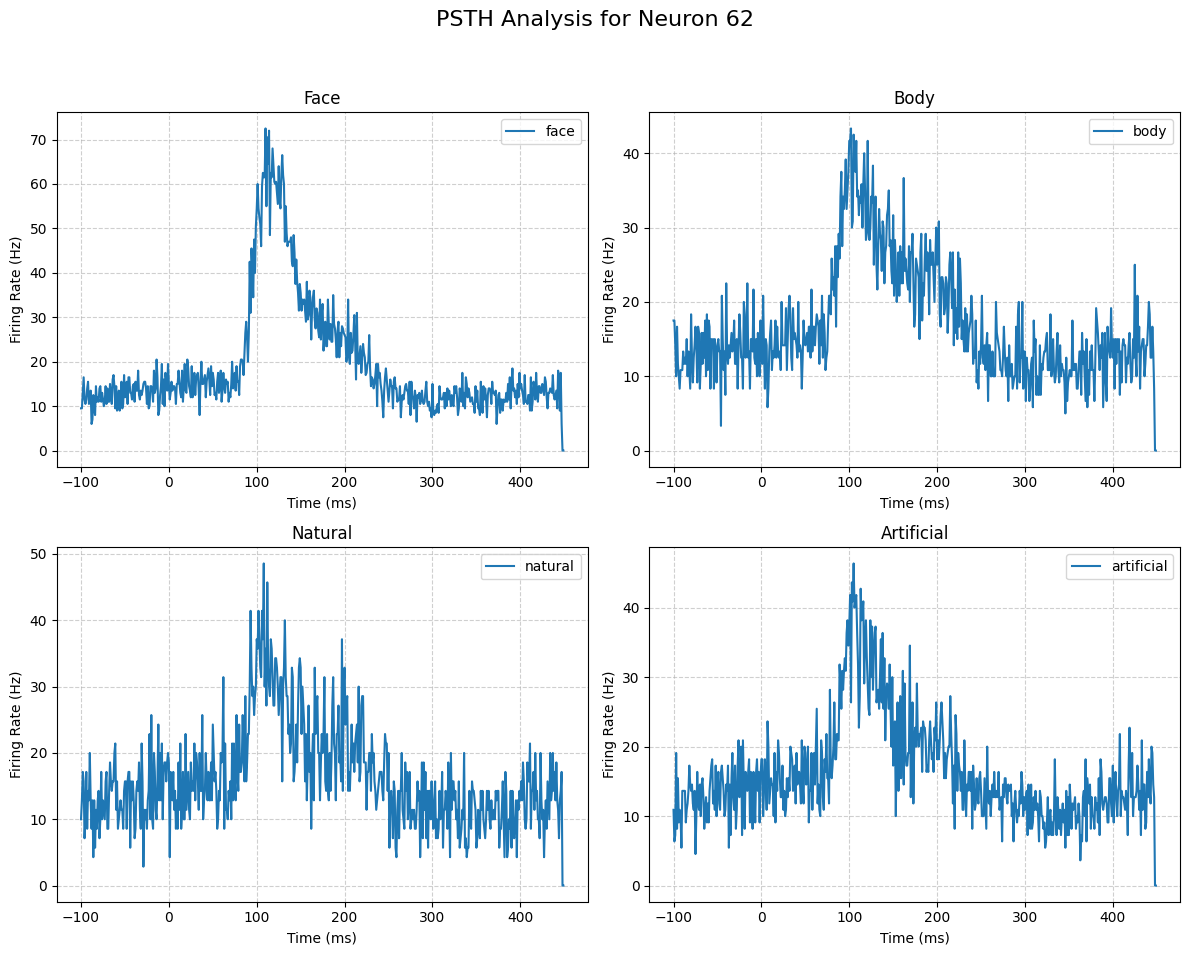

PSTH analysis complete. Plots saved as PDF files.


In [ ]:

# Define parameters
sampling_rate = 1000 # Hz
# Assuming data is a numpy object array where each element is an array for a neuron
n_neurons = data.size
# Assuming all neurons have the same number of trials and time points initially
n_trials = data[0].shape[0]
time_points = data[0].shape[1]
n_stimuli = 500
n_stimulus_trials = 10 # Assuming 10 trials per stimulus

# Define stimulus categories and their index ranges
categories = {
    "face": (1, 200),
    "body": (201, 320),
    "natural": (321, 390),
    "artificial": (391, 500)
}

# Define bins for categorizing stimuli based on their index
bins = [0, 200, 320, 390, 500]

# Categorize trials for each neuron based on the 'cm_index' (stimulus index)
trial_categories = []
for neuron in range(n_neurons):
    # Use pandas.cut to assign each stimulus index to a category label
    # cm[neuron]['index'] contains the stimulus index for each trial of that neuron
    trial_categories.append(pd.cut(cm[neuron]['index'].flatten(), bins=bins, labels=categories.keys(), include_lowest=True).to_numpy())

trial_categories = np.array(trial_categories, dtype=object) # Use dtype=object for arrays of different lengths if necessary

# Group trials by stimulus and calculate the mean firing rate for each stimulus
# This calculates the average response across trials for each stimulus for each neuron.
for n, (neuron_data, neuron_cm) in enumerate(zip(data, cm)):
    grouped_trails = [[] for _ in range(n_stimuli)]
    # Iterate through trials and their corresponding stimulus indices
    for trial, stimulus_index in zip(neuron_data, neuron_cm['index'].flatten()):
        # Append the trial data to the list corresponding to its stimulus index
        # Subtract 1 from stimulus_index because indices are 1-based in the .mat file
        grouped_trails[stimulus_index.astype(int) - 1].append(trial)

    # Calculate the mean response across trials for each stimulus
    # Multiply by sampling_rate to convert spikes per bin to Hz (firing rate)
    # Handle cases where a stimulus might have no trials
    mean_stimulus_response = []
    for stimulus_trials in grouped_trails:
        if stimulus_trials: # Check if the list is not empty
            mean_stimulus_response.append(np.mean(np.array(stimulus_trials), axis=0) * sampling_rate)
        else:
            # If no trials for a stimulus, append an array of zeros with the correct length
            mean_stimulus_response.append(np.zeros(time_points))

    # Update the data array with the mean stimulus responses
    data[n] = np.array(mean_stimulus_response)


# --- Plotting Section (Modified for individual category plots) ---

# Define the selected neurons (using 1-based indexing from the original request)
selected_neurons = [5, 62]

# Define the time axis (assuming -100ms to 450ms relative to stimulus onset)
# The total time points are 551 (450 - (-100) + 1)
# Ensure this matches the actual time_points derived from the data shape
# If time_points is different, adjust the arange values accordingly
time_axis = np.arange(-100, -100 + time_points) # Assuming time_points is 551

# Create plots for each selected neuron, with individual subplots for each category
for neuron_idx_0based in [sn - 1 for sn in selected_neurons]: # Convert to 0-based index
    neuron_id = selected_neurons[selected_neurons.index(neuron_idx_0based + 1)] # Get the original 1-based ID

    neuron_data = data[neuron_idx_0based] # Get the processed data for the neuron

    # Create a figure for the current neuron with 4 subplots (one for each category)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # Adjust figsize as needed
    axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

    fig.suptitle(f'PSTH Analysis for Neuron {neuron_id}', fontsize=16) # Add a main title for the neuron

    # Iterate through categories and plot each in a separate subplot
    for i, (category, (start, end)) in enumerate(categories.items()):
        ax = axes[i] # Select the current subplot axis

        # Select the mean stimulus responses corresponding to the current category
        cat_stimulus_indices_0based = np.arange(start - 1, end) # 0-based indices for stimuli in this category
        cat_stimulus_responses = neuron_data[cat_stimulus_indices_0based]

        # Calculate the average PSTH across stimuli within this category
        if cat_stimulus_responses.size > 0: # Check if there are any stimuli in this category
            psth = np.mean(cat_stimulus_responses, axis=0)
            ax.plot(time_axis, psth, label=category)
        else:
            # If no stimuli in this category, plot a flat line at zero
            ax.plot(time_axis, np.zeros_like(time_axis), label=category + " (No data)")
            print(f"Warning: No data for category '{category}' for Neuron {neuron_id}")


        ax.set_title(f'{category.capitalize()}') # Set title for the subplot
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Firing Rate (Hz)')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6) # Add a grid for better readability

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.savefig(f'psth_neuron_{neuron_id}_categories.pdf', bbox_inches='tight') # Save the figure
    plt.show() # Display the figure


print("PSTH analysis complete. Plots saved as PDF files.")


In [ ]:
import h5py
import numpy as np

file_path    = '/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat'
neuron_index = 64   # 0–91

with h5py.File(file_path, 'r') as f:
    grp        = f['SpikeTrain_it_all']
    raster_ds  = grp['data']   # shape (92, 1) of object references
    cm_ds      = grp['cm']     # shape (92, 1) of object references

    # --- load the raster for that neuron ---
    raster_ref = raster_ds[neuron_index, 0]
    raster     = np.array(f[raster_ref])        # shape (550, 5000)
    # If you want trials×time, transpose:
    raster = raster.T                           # now (5000, 550)
    print(f"Neuron {neuron_index} raster shape: {raster.shape}")

    # --- load the stimulus‐ID vector for that neuron ---
    cm_ref  = cm_ds[neuron_index, 0]
    # `cm_ref` points to a group with fields 'index', 'name', etc.
    idx_refs = f[cm_ref]['index'][:]            # an array of object refs, length=5000
    # dereference each to an integer:
    # cm = np.array([int(f[ref][()]) for ref in idx_refs], dtype=int)
    cm = []
    for j in range(len(idx_refs)):
        ref = idx_refs[j][0] if isinstance(idx_refs[j], np.ndarray) else idx_refs[j]
        cm.append(int(f[ref][()]))
    cm = np.array(cm, dtype=int)

    print(f"Neuron {neuron_index} cm shape:    {cm.shape}")
    print("First 10 stimulus IDs:", cm[:10])


Neuron 64 raster shape: (5000, 550)


<ipython-input-5-191c8d937763>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm.append(int(f[ref][()]))


Neuron 64 cm shape:    (5000,)
First 10 stimulus IDs: [149  23 254 188 180 487 277 483 292 182]


<ipython-input-17-5a7d6215519a>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm.append(int(val[0]) if val.ndim > 0 else int(val))


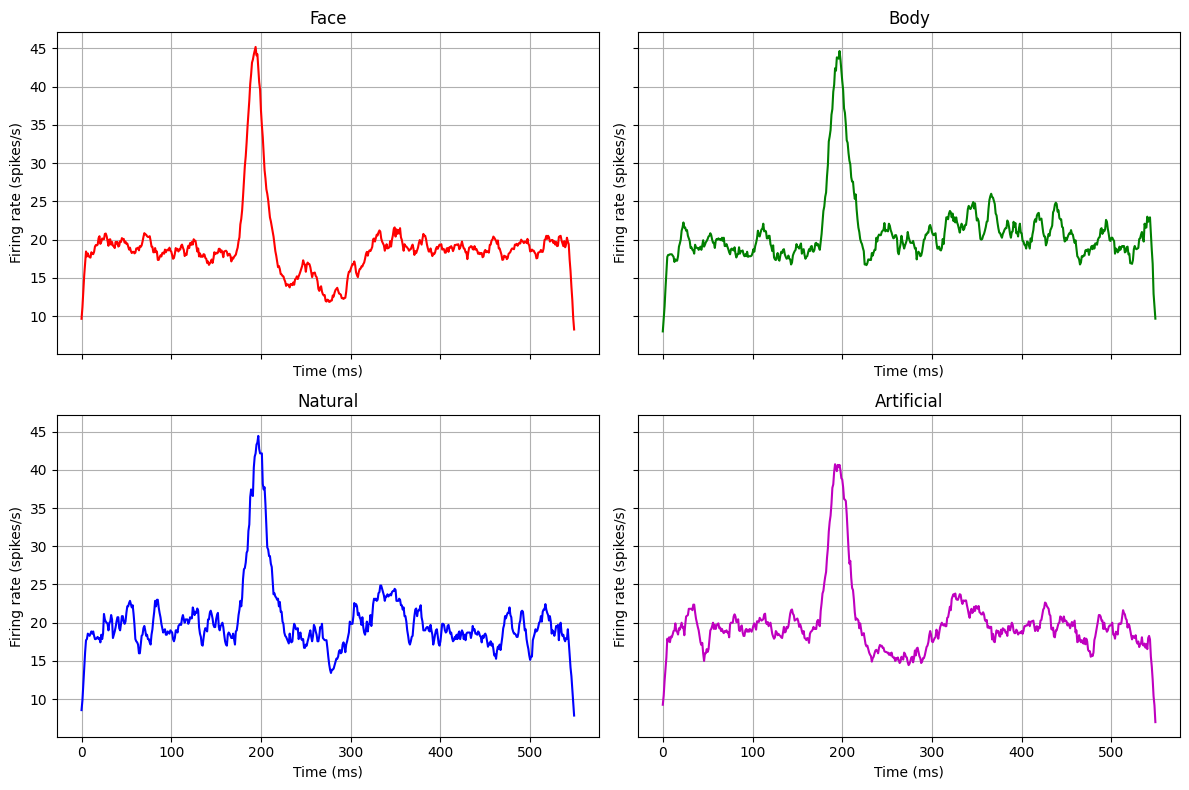

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# --- Load single neuron raster and category mapping ---
file_path = '/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat'
neuron_index = 24

with h5py.File(file_path, 'r') as f:
    st_all    = f['SpikeTrain_it_all']
    raster_ds = st_all['data']
    cm_ds     = st_all['cm']

    # Load raster
    raster_ref = raster_ds[neuron_index, 0]
    raster0 = np.array(f[raster_ref])  # shape: (5000, 550)

    # Load stimulus IDs
    cm_ref = cm_ds[neuron_index, 0]
    idx_refs = f[cm_ref]['index'][:]
    cm = []
    for j in range(len(idx_refs)):
        ref = idx_refs[j][0] if isinstance(idx_refs[j], np.ndarray) else idx_refs[j]
        val = np.array(f[ref])  # safely convert to ndarray
        cm.append(int(val[0]) if val.ndim > 0 else int(val))
    cm = np.array(cm, dtype=int)
    if raster0.shape[0] != cm.shape[0]:
        if raster0.shape[1] == cm.shape[0]:
            raster0 = raster0.T
        else:
            raise ValueError(f"Shape mismatch: raster {raster0.shape} vs cm {cm.shape}")


# --- Map stimulus ID to category (0:Face, 1:Body, 2:Natural, 3:Artificial) ---
category_map = np.full(cm.shape, -1)
category_map[(cm >= 1)   & (cm <= 200)] = 0  # Face
category_map[(cm >= 201) & (cm <= 320)] = 1  # Body
category_map[(cm >= 321) & (cm <= 390)] = 2  # Natural
category_map[(cm >= 391) & (cm <= 500)] = 3  # Artificial

# --- Compute PSTH per category ---
n_timepoints = raster0.shape[1]
psth = {}
for cat in range(4):
    trials = raster0[category_map == cat, :]  # select trials in this category
    psth[cat] = trials.mean(axis=0) * 1000  # spikes/ms → spikes/s

# --- Smooth and plot ---
time_ms = np.arange(n_timepoints)
categories = ['Face', 'Body', 'Natural', 'Artificial']
colors = ['r', 'g', 'b', 'm']

# Smooth with moving average
window = 10
kernel = np.ones(window) / window
psth_smooth = {cat: np.convolve(psth[cat], kernel, mode='same') for cat in psth}

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for ax, cat in zip(axes.flatten(), psth_smooth):
    ax.plot(time_ms, psth_smooth[cat], color=colors[cat], linewidth=1.5)
    ax.set_title(categories[cat])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing rate (spikes/s)')
    ax.grid(True)

plt.tight_layout()
plt.show()


Neuron 24 raster shape: (550, 5000)
Neuron 24 cm/index shape: (5000,)
First 10 picture indices: ['<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>']


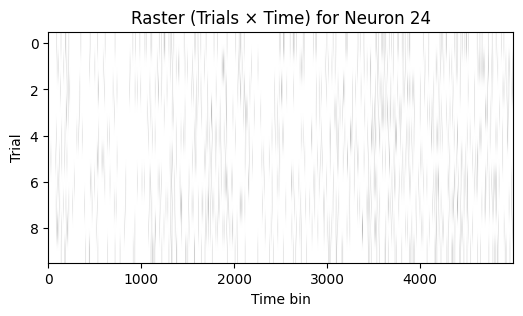

In [ ]:
file_path = '/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat'
neuron_index = 24

with h5py.File(file_path, 'r') as f:
    st_all    = f['SpikeTrain_it_all']
    raster_ds = st_all['data']
    cm_ds     = st_all['cm']

    raster_ref = raster_ds[neuron_index, 0]
    raster0    = np.array(f[raster_ref])
    print(f"Neuron {neuron_index} raster shape:", raster0.shape)

    cm_ref    = cm_ds[neuron_index, 0]
    cm_group  = f[cm_ref]
    cm_index  = np.array(cm_group['index']).squeeze().astype(str)
    print(f"Neuron {neuron_index} cm/index shape:", cm_index.shape)
    print("First 10 picture indices:", cm_index[:10])

    # Raster plot
    plt.figure(figsize=(6,3))
    plt.imshow(raster0[:10, :], aspect='auto', cmap='gray_r')
    plt.title(f'Raster (Trials × Time) for Neuron {neuron_index}')
    plt.xlabel('Time bin')
    plt.ylabel('Trial')
    plt.show()


Raster shape (trials × time): (5000, 550)


<ipython-input-19-3da0fe216dc3>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pic_nums.append(int(value))


Picture indices shape: (5000,)
First 10 picture indices: [383 390 176 301  91 252 314 310 401 196]


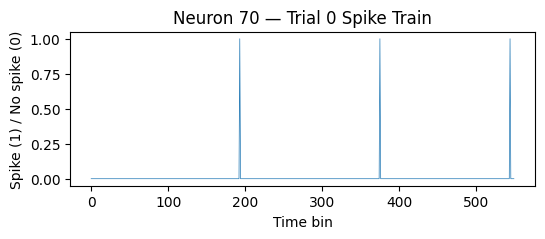

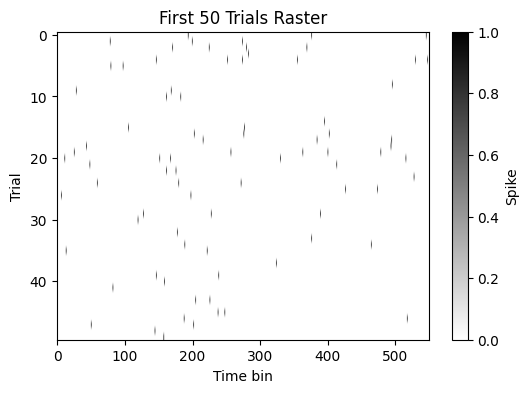

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


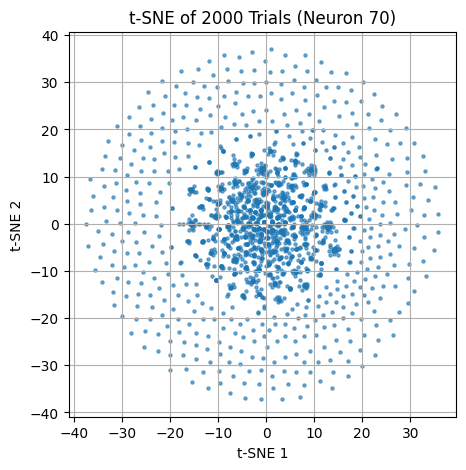

In [ ]:
neuron_index = 24
with h5py.File(file_path, 'r') as f:
    st_all     = f['SpikeTrain_it_all']
    raster_ref = st_all['data'][neuron_index, 0]
    cm_ref     = st_all['cm']  [neuron_index, 0]


    raw       = np.array(f[raster_ref])
    raster0   = raw.T
    print("Raster shape (trials × time):", raster0.shape)

    # Dereference cm/index properly
    idx_dataset = f[cm_ref]['index']
    idx_refs    = idx_dataset[()]
    idx_refs    = idx_refs.flatten()
    pic_nums = []
    for ref in idx_refs:
        value = f[ref][()]
        pic_nums.append(int(value))
    pic_nums = np.array(pic_nums)
    print("Picture indices shape:", pic_nums.shape)
    print("First 10 picture indices:", pic_nums[:10])


    plt.figure(figsize=(6,2))
    plt.plot(raster0[0], lw=0.5)
    plt.title(f"Neuron {neuron_index} — Trial 0 Spike Train")
    plt.xlabel("Time bin")
    plt.ylabel("Spike (1) / No spike (0)")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.imshow(raster0[:50], aspect='auto', cmap='gray_r')
    plt.title("First 50 Trials Raster")
    plt.xlabel("Time bin")
    plt.ylabel("Trial")
    plt.colorbar(label="Spike")
    plt.show()

    subsamp = min(2000, raster0.shape[0])
    sel     = np.random.choice(raster0.shape[0], subsamp, replace=False)
    X       = raster0[sel]  # shape (subsamp, 550)

    tsne = TSNE(n_components=2, perplexity=30, random_state=0, n_iter=500, verbose=0)
    X2   = tsne.fit_transform(X)

    plt.figure(figsize=(5,5))
    plt.scatter(X2[:,0], X2[:,1], s=5, alpha=0.6)
    plt.title(f"t-SNE of {subsamp} Trials (Neuron {neuron_index})")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()


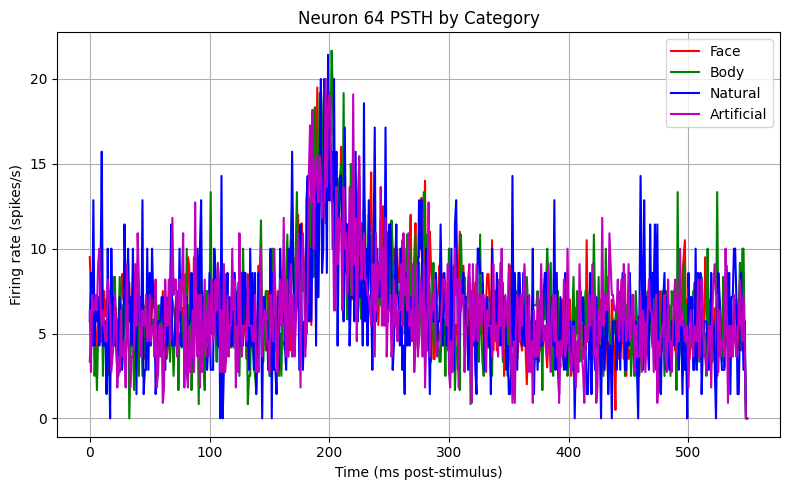

In [ ]:
max_pic = 500
StmLabels = np.zeros(max_pic + 1, dtype=int)

# Face:       1–200 → 0
# Body:     201–320 → 1
# Natural:  321–390 → 2
# Artificial 391–500 → 3
StmLabels[1:201]   = 0
StmLabels[201:321] = 1
StmLabels[321:391] = 2
StmLabels[391:501] = 3

trial_cats = StmLabels[pic_nums]

bin_width_s = 0.001
time_ms     = np.arange(550)

psth = {}
for cat in [0,1,2,3]:
    idx = np.where(trial_cats == cat)[0]
    sub = raster0[idx, :]
    psth[cat] = sub.sum(axis=0) / (len(idx) * bin_width_s)

# 4) PSTHs together
colors = ['r','g','b','m']
labels = ['Face','Body','Natural','Artificial']

plt.figure(figsize=(8,5))
for cat in [0,1,2,3]:
    plt.plot(time_ms, psth[cat], color=colors[cat], label=labels[cat])
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('Neuron 64 PSTH by Category')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


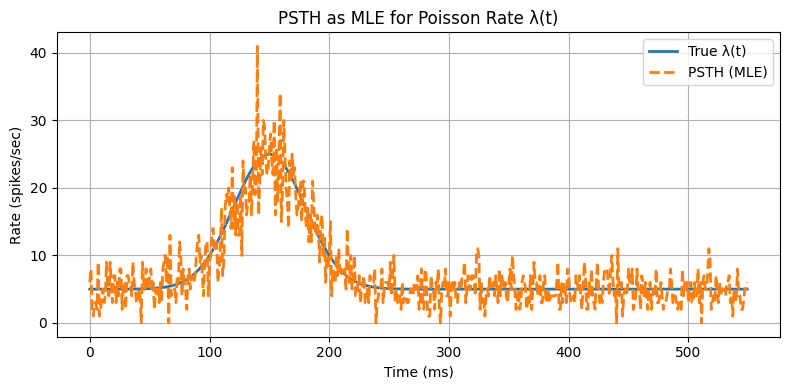

In [ ]:
n_trials = 1000
n_time   = 550
t = np.arange(n_time)
lambda_t = 5 + 20 * np.exp(-0.5 * ((t - 150) / 30)**2)

lambda_ms = lambda_t / 1000.0

spike_trains = np.random.poisson(lambda_ms[None, :], size=(n_trials, n_time))

psth = spike_trains.mean(axis=0) * 1000.0
lambda_mle = psth

# 4) true λ(t) vs. PSTH (MLE)
plt.figure(figsize=(8,4))
plt.plot(t, lambda_t,  label='True λ(t)', linewidth=2)
plt.plot(t, lambda_mle, '--', label='PSTH (MLE)', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Rate (spikes/sec)')
plt.title('PSTH as MLE for Poisson Rate λ(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Fano Factor

In [ ]:

def category_based_fano(raster_all, cm_all, StmLabels,
                        window_length=50, sliding_step=5):
    """
    Compute mean and variance of spike counts in sliding windows,
    separately for each category and each neuron.

    raster_all: list or array of shape (n_neurons,) where each element is (n_trials, n_time)
    cm_all:     list/array of shape (n_neurons,) where each element is (n_trials,) picture IDs
    StmLabels:  array mapping picture ID -> category (0–3)
    window_length: window size in bins (e.g. 200 for 100–300 ms)
    sliding_step:  step size in bins (e.g. 50 for 50 ms sliding)

    Returns:
      mean_vec: dict[cat] → array (n_neurons, n_time_slices)
      var_vec:  dict[cat] → array (n_neurons, n_time_slices)
      counts_dict: dict[cat] → list of per-neuron count arrays [(n_trials_cat, n_slices), …]
    """
    n_neurons = len(raster_all)
    n_time    = raster_all[0].shape[1]
    # number of sliding windows:
    n_slices = 1 + (n_time - window_length) // sliding_step

    mean_vec = {cat: np.zeros((n_neurons, n_slices)) for cat in range(4)}
    var_vec  = {cat: np.zeros((n_neurons, n_slices)) for cat in range(4)}
    counts_dict = {cat: [None]*n_neurons for cat in range(4)}

    for i in range(n_neurons):
        raster = raster_all[i]
        pics   = cm_all[i]
        cats   = StmLabels[pics]

        for cat in range(4):
            sel = np.where(cats == cat)[0]
            data = raster[sel]

            counts = np.zeros((data.shape[0], n_slices))

            for u in range(n_slices):
                start = sliding_step * u
                end   = start + window_length
                counts[:, u] = data[:, start:end].sum(axis=1)

            counts_dict[cat][i] = counts
            mean_vec[cat][i] = counts.mean(axis=0)
            var_vec [cat][i] = counts.var (axis=0)

    return mean_vec, var_vec, counts_dict


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

def compute_mmff(psth_tensor, StmLabels, n_bins=8):
    """
    Compute Mean-Matched Fano Factor (MMFF) across time and category.

    Parameters:
    - psth_tensor: (n_neurons, n_stimuli, n_slices)
    - StmLabels:  (n_stimuli + 1,) category label for each picture ID
    - n_bins:     Number of bins to match mean rates across categories

    Returns:
    - fano_avg:   dict[cat] = mean-matched FF (1D array of length n_slices)
    """
    n_neurons, n_stimuli, n_slices = psth_tensor.shape
    fano_avg = {}

    for cat in range(4):
        ff_all = []
        for t in range(n_slices):
            means, variances = [], []

            for n in range(n_neurons):
                spike_counts = psth_tensor[n, :, t]  # shape: (500,)
                labels = StmLabels[1:]  # map picture ID → category
                stim_cat = labels == cat

                counts_cat = spike_counts[stim_cat]

                mean_cat = np.mean(counts_cat)
                var_cat  = np.var(counts_cat)
                means.append(mean_cat)
                variances.append(var_cat)

            means = np.array(means)
            variances = np.array(variances)

            # Remove zero means (to avoid division by zero)
            valid = means > 0
            ff = variances[valid] / means[valid]

            print("Sample means:", means[:5])
            print("Sample vars:", variances[:5])
            print("FFs:", ff[:5])
            if len(ff) > 0:
                ff_all.append(np.mean(ff))
            else:
                ff_all.append(np.nan)

        fano_avg[cat] = np.array(ff_all)

    return fano_avg

def plot_fano(fano_avg, time_start=0, time_step=5):
    """
    Plot MMFF over time for 4 categories.

    Parameters:
    - fano_avg: dict from compute_mmff()
    - time_start: time of first slice (e.g. 0 ms)
    - time_step:  time between slices (e.g. 5 ms)
    """
    times = np.arange(len(fano_avg[0])) * time_step + time_start

    plt.figure(figsize=(10, 5))
    colors = ['red', 'orange', 'green', 'blue']
    labels = ['Face', 'Body', 'Natural', 'Artificial']

    for cat in range(4):
        ff = fano_avg[cat]
        smoothed = np.convolve(ff, np.ones(5)/5, mode='same')
        plt.plot(times, smoothed, color=colors[cat], label=labels[cat])

    plt.axhline(1.0, linestyle='--', color='gray', label='Poisson baseline')
    plt.xlabel("Time (ms)")
    plt.ylabel("Mean-Matched Fano Factor")
    plt.title("MMFF Across Time by Category")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage (you must define psth_tensor and StmLabels before this)
# fano_avg = compute_mmff(psth_tensor, StmLabels)
# plot_fano(fano_avg, time_start=0, time_step=5)


Raster shape (trials × time): (5000, 550)


<ipython-input-12-5ecd4bc51a56>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pic_nums.append(int(value))


Picture indices shape: (5000,)
First 10 picture indices: [  8  67 496 491 271  47 439  83 495 349]


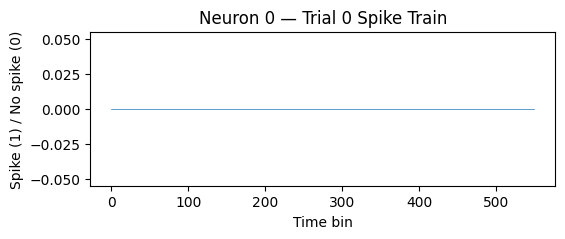

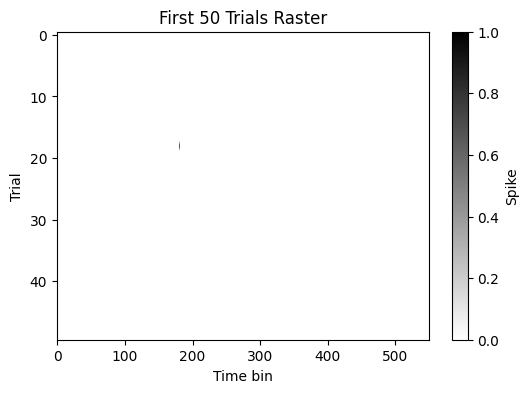

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


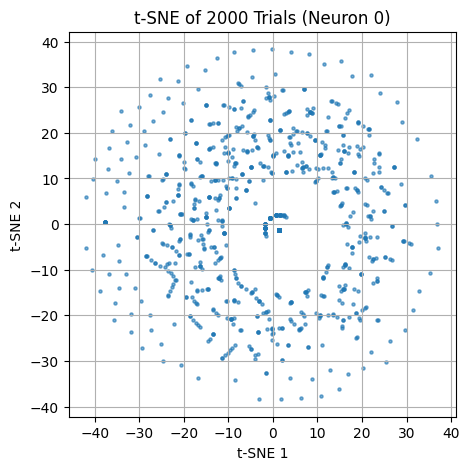

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

file_path = '/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat'
neuron_index = 0  # which neuron to inspect

with h5py.File(file_path, 'r') as f:
    st_all     = f['SpikeTrain_it_all']
    raster_ref = st_all['data'][neuron_index, 0]
    cm_ref     = st_all['cm']  [neuron_index, 0]

    # 1) Load & transpose raster to (5000 trials × 550 time bins)
    raw       = np.array(f[raster_ref])
    raster0   = raw.T
    print("Raster shape (trials × time):", raster0.shape)  # (5000, 550)

    # 2) Dereference cm/index properly
    idx_dataset = f[cm_ref]['index']        # this is an HDF5 dataset of shape (550, 1)
    idx_refs    = idx_dataset[()]           # yields a (550,1) array of object refs
    idx_refs    = idx_refs.flatten()        # now a flat (550,) array of object refs

    # Now iterate over each scalar reference
    pic_nums = []
    for ref in idx_refs:
        # f[ref] is a zero-dimensional dataset holding a single number
        value = f[ref][()]
        pic_nums.append(int(value))
    pic_nums = np.array(pic_nums)
    print("Picture indices shape:", pic_nums.shape)  # should be (550,)
    print("First 10 picture indices:", pic_nums[:10])

    # 3) Quick sanity plot: trial 0 spike train
    plt.figure(figsize=(6,2))
    plt.plot(raster0[0], lw=0.5)
    plt.title(f"Neuron {neuron_index} — Trial 0 Spike Train")
    plt.xlabel("Time bin")
    plt.ylabel("Spike (1) / No spike (0)")
    plt.show()

    # 4) Raster of first 50 trials
    plt.figure(figsize=(6,4))
    plt.imshow(raster0[:50], aspect='auto', cmap='gray_r')
    plt.title("First 50 Trials Raster")
    plt.xlabel("Time bin")
    plt.ylabel("Trial")
    plt.colorbar(label="Spike")
    plt.show()

    # 5) (Optional) Quick 2D t-SNE on a subsample of trials
    subsamp = min(2000, raster0.shape[0])
    sel     = np.random.choice(raster0.shape[0], subsamp, replace=False)
    X       = raster0[sel]  # shape (subsamp, 550)

    tsne = TSNE(n_components=2, perplexity=30, random_state=0, n_iter=500, verbose=0)
    X2   = tsne.fit_transform(X)

    plt.figure(figsize=(5,5))
    plt.scatter(X2[:,0], X2[:,1], s=5, alpha=0.6)
    plt.title(f"t-SNE of {subsamp} Trials (Neuron {neuron_index})")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()


In [ ]:
import h5py
import numpy as np

# 1) Open the v7.3 MAT-file and grab the group
with h5py.File('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat', 'r') as f:
    st = f['SpikeTrain_it_all']
    data_ds = st['data']  # (92, 1) object refs
    cm_ds   = st['cm']    # (92, 1) object refs

    raster_all = []
    cm_all     = []
    for i in range(92):
        # each entry is a reference to a dataset
        rref = data_ds[i, 0]
        cref = cm_ds[i, 0]
        raster = np.array(f[rref])  # shape: (550, 5000)
        cm     = np.array(f[cref]['index'][:]).flatten().astype(str)  # (5000,)

        # Transpose raster so it’s (trials, time)
        raster_all.append(raster.T)  # now (5000, 550)
        cm_all.append(cm)            # (5000,)

# Convert lists to arrays if you like:
# raster_all = np.stack(raster_all, axis=0)  # (92, 5000, 550)
# cm_all     = np.stack(cm_all, axis=0)      # (92, 5000)

print("Loaded raster_all list length:", len(raster_all))
print("Example neuron 0 raster shape:", raster_all[0].shape)
print("Loaded cm_all list length:",   len(cm_all))
print("Example neuron 0 cm shape:",   cm_all[0].shape)


Loaded raster_all list length: 92
Example neuron 0 raster shape: (5000, 550)
Loaded cm_all list length: 92
Example neuron 0 cm shape: (5000,)


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# --- 1. Load dataVasati.mat and build raster_all & cm_all ---
def load_raster_cm(mat_path):
    """
    Load raw raster and cm from HDF5 SpikeTrain_it_all group.
    Returns:
      raster_all: list of arrays, each (n_trials, n_time)
      cm_all:     list of arrays, each (n_trials,) with stimulus IDs
    """
    raster_all = []
    cm_all     = []
    with h5py.File(mat_path, 'r') as f:
        st = f['SpikeTrain_it_all']
        data_ds = st['data']  # shape (92,1) object refs
        cm_ds   = st['cm']    # shape (92,1) object refs
        for i in range(data_ds.shape[0]):
            # extract raster
            rref = data_ds[i, 0]
            raw = np.array(f[rref])        # (550, 5000)
            raster_all.append(raw.T)       # transpose to (5000, 550)
            # extract cm
            cref = cm_ds[i, 0]
            cm_grp = f[cref]
            idx_refs = cm_grp['index'][:]  # array of object refs length 5000
            # dereference each to int
            cm = np.zeros(idx_refs.shape[0], dtype=int)
            for j, ref in enumerate(idx_refs):
                # ref may be scalar or length-1 array
                if isinstance(ref, np.ndarray):
                    ref = ref[0]
                cm[j] = int(f[ref][()])
            cm_all.append(cm)
    return raster_all, cm_all

# --- 2. Build psth_tensor: (n_neurons, n_stimuli, n_slices) --- Build psth_tensor: (n_neurons, n_stimuli, n_slices) --- Build psth_tensor: (n_neurons, n_stimuli, n_slices) ---
def build_psth_tensor(raster_all, cm_all, win_len=50, step=5):
    n_neurons = len(raster_all)
    trial_stim = cm_all[0]
    stim_ids = np.unique(trial_stim).astype(int)  # ensure integer IDs
    n_slices = 1 + (raster_all[0].shape[1] - win_len) // step
    psth_tensor = np.zeros((n_neurons, len(stim_ids), n_slices))
    for ni in range(n_neurons):
        raster = raster_all[ni]
        for si, sid in enumerate(stim_ids):
            trials = np.where(trial_stim == sid)[0]
            avg_psth = raster[trials].mean(axis=0)
            for s in range(n_slices):
                start = s * step
                psth_tensor[ni, si, s] = avg_psth[start:start+win_len].sum()
    return psth_tensor, stim_ids

# --- 3. Build StmLabels mapping stimulus ID → category ---
def build_StmLabels(stim_ids):
    max_id = int(np.max(stim_ids))
    StmLabels = np.zeros(max_id+1, dtype=int)
    StmLabels[1:201]   = 0  # Face
    StmLabels[201:321] = 1  # Body
    StmLabels[321:391] = 2  # Natural
    StmLabels[391:501] = 3  # Artificial
    return StmLabels

# --- 4. Compute Mean-Matched Fano Factor ---
def compute_mmff(psth_tensor, StmLabels):
    n_neurons, n_stimuli, n_slices = psth_tensor.shape
    fano_avg = {}
    labels = StmLabels[1:]
    for cat in range(4):
        ff_all = []
        for t in range(n_slices):
            ff_cat = []
            for n in range(n_neurons):
                counts = psth_tensor[n, :, t]
                cat_idx = labels == cat
                m = counts[cat_idx].mean()
                v = counts[cat_idx].var()
                if m > 0:
                    ff_cat.append(v/m)
            ff_all.append(np.nanmean(ff_cat) if ff_cat else np.nan)
        fano_avg[cat] = np.array(ff_all)
    return fano_avg

# --- 5. Plotting function ---
def plot_fano(fano_avg, time_start=0, time_step=5):
    n_slices = len(next(iter(fano_avg.values())))
    times = np.arange(n_slices) * time_step + time_start
    plt.figure(figsize=(10, 5))
    colors = ['red','orange','green','blue']
    names = ['Face','Body','Natural','Artificial']
    for cat in range(4):
        sm = np.convolve(fano_avg[cat], np.ones(5)/5, mode='same')
        plt.plot(times, sm, label=names[cat], color=colors[cat], linewidth=2)
    plt.axhline(1, linestyle='--', color='gray', label='Poisson baseline')
    plt.xlabel('Time (ms)')
    plt.ylabel('Mean-Matched Fano Factor')
    plt.title('MMFF Across Time by Category')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 6. End-to-End Example ---
# raster_all, cm_all = load_raster_cm('dataVasati.mat')
# psth_tensor, stim_ids = build_psth_tensor(raster_all, cm_all)
# StmLabels = build_StmLabels(stim_ids)
# fano_avg = compute_mmff(psth_tensor, StmLabels)
# plot_fano(fano_avg)


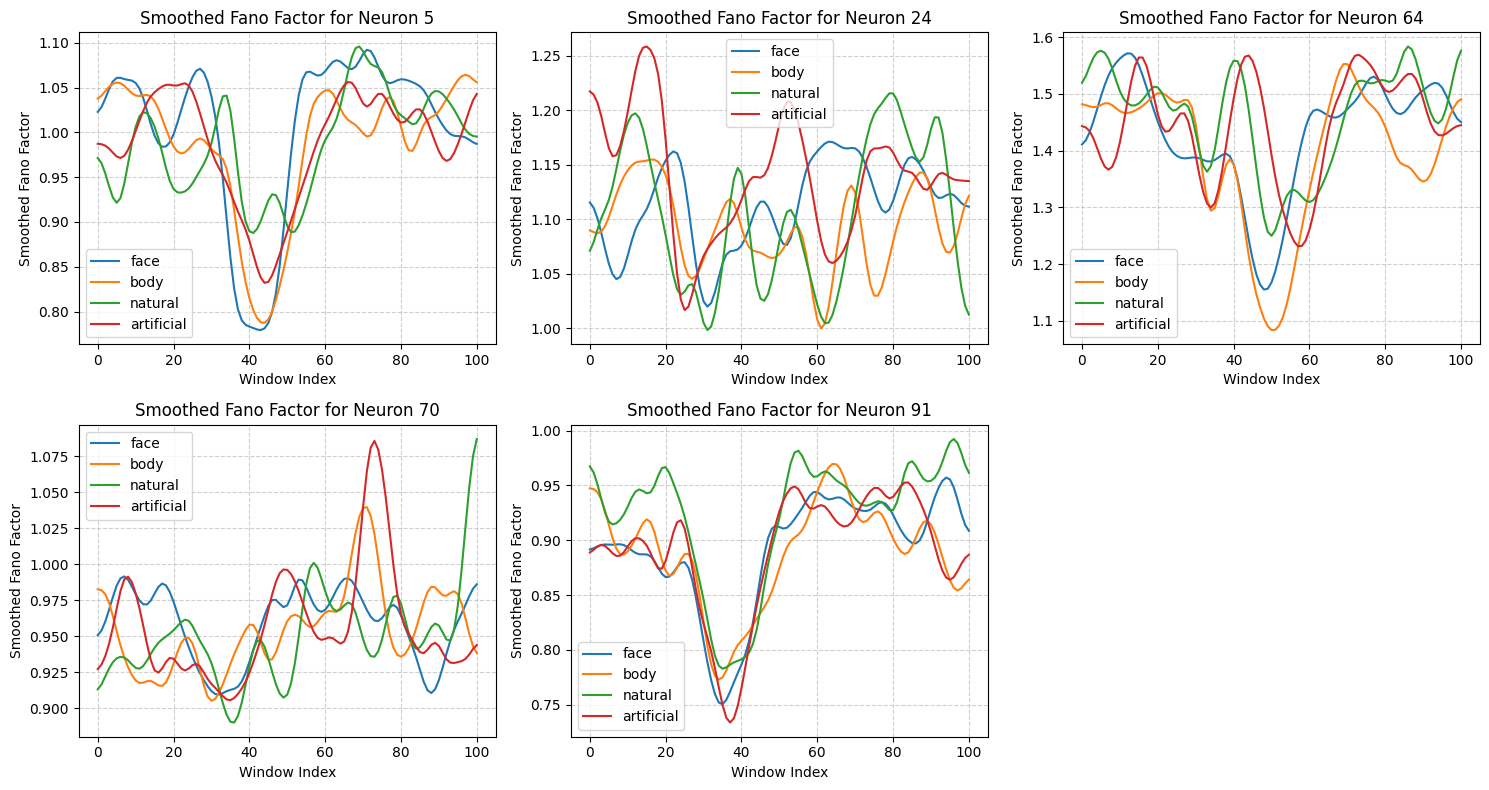

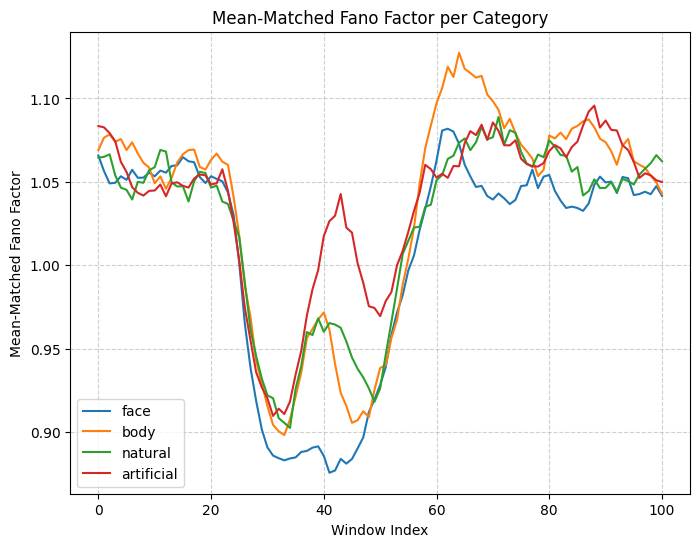

Fano Factor and Mean-Matched Fano Factor analysis complete. Plots saved as PDF files.


In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter1d # Import for smoothing

# Define functions to read data from the .mat file
def dereference(data, file):
    """Dereferences HDF5 object references within the dataset."""
    # Use np.vectorize to apply the lambda function to each element in data
    # otypes=[object] is used because the output type might vary
    return np.vectorize(lambda ref: read_matlab_file(file[ref], file), otypes=[object])(data)

def read_matlab_file(file_obj, file):
    """Recursively reads data from HDF5 file objects (Dataset or Group)."""
    if isinstance(file_obj, h5py.Dataset):
        # Read dataset content and remove singleton dimensions
        data = file_obj[()].squeeze()
        # Check if the data type is an HDF5 reference
        if data.dtype == h5py.ref_dtype:
            # If it's a reference, dereference it
            data = dereference(data, file)
    elif isinstance(file_obj, h5py.Group):
        # If it's a group, create a dictionary and recursively read its members
        data = {}
        for subvar in file_obj.keys():
            data[subvar] = read_matlab_file(file_obj[subvar], file)
    else:
        # Return the file object itself if it's neither Dataset nor Group (e.g., a reference that couldn't be resolved)
        data = file_obj
    return data

# Load data from the .mat file
# Ensure 'dataVasati.mat' is in the same directory or provide the full path
try:
    with h5py.File('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat', 'r') as file:
        # Read the main SpikeTrain_it_all structure
        dataVasati = read_matlab_file(file['SpikeTrain_it_all'], file)
        # Extract 'data' and 'cm' (cell information)
        data = dataVasati['data']
        cm = dataVasati['cm']
except FileNotFoundError:
    print("Error: 'dataVasati.mat' not found. Please ensure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the .mat file: {e}")
    exit()

# Transpose each trial's data for each neuron
# The original data seems to have time points as rows and trials as columns,
# but for analysis like Fano Factor, we need trials as rows and time points as columns.
# This step transposes each individual trial array within the 'data' object array.
data = np.vectorize(lambda arr: arr.T, otypes=[object])(data)

# Define parameters
sampling_rate = 1000 # Hz
# Assuming data is a numpy object array where each element is an array for a neuron
n_neurons = data.size
# Assuming all neurons have the same number of trials and time points initially
n_trials = data[0].shape[0] # This might be incorrect if trials vary per neuron after loading
time_points = data[0].shape[1] # Assuming all neurons have the same number of time points

# Define stimulus categories and their index ranges
categories = {
    "face": (1, 200),
    "body": (201, 320),
    "natural": (321, 390),
    "artificial": (391, 500)
}

# Define bins for categorizing stimuli based on their index
bins = [0, 200, 320, 390, 500]

# Categorize trials for each neuron based on the 'cm_index' (stimulus index)
trial_categories = []
for neuron in range(n_neurons):
    # Use pandas.cut to assign each stimulus index to a category label
    # cm[neuron]['index'] contains the stimulus index for each trial of that neuron
    # Use include_lowest=True to include the 0 boundary if necessary, though bins start at 0
    trial_categories.append(pd.cut(cm[neuron]['index'].flatten(), bins=bins, labels=categories.keys(), include_lowest=True).to_numpy())

# Convert to a numpy array of objects. This is necessary because the number of trials
# might differ between neurons, making a standard numpy array impossible.
trial_categories = np.array(trial_categories, dtype=object)


# --- Sliding Window Spike Counting ---
window_size = 50 # ms
step_size = 5 # ms
# Calculate the number of windows based on time points, window size, and step size
# Ensure integer division
n_windows = (time_points - window_size) // step_size + 1

# Apply the sliding window to calculate spike counts for each trial and each neuron
# The result will replace the original spike train data in the 'data' object array
for n, neuron_data in enumerate(data):
    # Initialize an array to store spike counts for the current neuron
    # Shape: (number of trials, number of windows)
    spike_counts = np.zeros((neuron_data.shape[0], n_windows))

    # Iterate through each window
    for i in range(n_windows):
        # Calculate the start and end time point indices for the current window
        start = i * step_size
        end = start + window_size
        # Sum spikes within the window for each trial
        spike_counts[:, i] = np.sum(neuron_data[:, start:end], axis=1)

    # Replace the original spike train data with the calculated spike counts
    data[n] = spike_counts

# --- Fano Factor Calculation and Plotting ---

# Define the selected neurons for Fano Factor plotting (using 1-based indexing)
selected_neurons_fano = [5, 24, 64, 70, 91]

# Smoothing parameter for Gaussian filter
smoothing_sigma = 2 # Adjust this value to control the amount of smoothing

# Create a figure for the Fano Factor plots
# Adjust figure size based on the number of selected neurons
n_cols = 3
n_rows = (len(selected_neurons_fano) + n_cols - 1) // n_cols # Calculate rows needed
plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Adjust figsize as needed

# Iterate through the selected neurons and calculate/plot Fano Factor
for i, selected_neuron_id in enumerate(selected_neurons_fano):
    # Convert 1-based neuron ID to 0-based index
    neuron_idx_0based = selected_neuron_id - 1

    # Add a subplot for the current neuron
    plt.subplot(n_rows, n_cols, i + 1)

    # Get the spike counts data for the current neuron
    neuron_spike_counts = data[neuron_idx_0based]
    # Get the trial categories for the current neuron
    neuron_trial_categories = trial_categories[neuron_idx_0based]

    # Iterate through each category to calculate Fano Factor
    for category in categories.keys():
        # Select spike counts for trials belonging to the current category
        cat_trials_spike_counts = neuron_spike_counts[neuron_trial_categories == category]

        # Calculate Fano Factor for each window for the current category
        cat_fanos = []
        # Iterate through each window
        for w in range(n_windows):
            # Get spike counts for the current window across all trials in the category
            window_data = cat_trials_spike_counts[:, w]
            # Calculate mean and variance for the window
            mean = np.mean(window_data)
            var = np.var(window_data)
            # Calculate Fano Factor (variance / mean). Handle division by zero.
            fano = var / mean if mean > 0 else np.nan
            cat_fanos.append(fano)

        # Convert list to numpy array
        cat_fanos = np.array(cat_fanos)

        # Apply Gaussian smoothing to the Fano Factor
        # Only smooth if there are valid Fano Factor values
        if not np.all(np.isnan(cat_fanos)):
             # Replace NaNs with interpolated values or handle them before smoothing if necessary
             # For simplicity here, we'll just smooth the non-NaN parts or accept NaNs in output
             smoothed_fanos = gaussian_filter1d(cat_fanos[~np.isnan(cat_fanos)], sigma=smoothing_sigma)
             # To plot on the original window axis, we need to place the smoothed values back
             # into an array with the original shape, potentially leaving NaNs where they were.
             # A simple approach is to plot the smoothed values against the indices where they were valid.
             valid_indices = np.where(~np.isnan(cat_fanos))[0]
             plt.plot(valid_indices, smoothed_fanos, label=category)
        else:
             # If all values are NaN, plot a line of NaNs or skip plotting for this category
             plt.plot(np.arange(n_windows), cat_fanos, label=category + " (No valid data)")


    # Set plot title and labels
    plt.title(f'Smoothed Fano Factor for Neuron {selected_neuron_id}')
    plt.xlabel('Window Index') # X-axis represents the window number
    plt.ylabel('Smoothed Fano Factor')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6) # Add a grid

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
# Save the Fano Factor figure
plt.savefig('smoothed_fano_factor.pdf', bbox_inches='tight')
# Display the Fano Factor figure
plt.show()


# --- Mean-Matched Fano Factor (MMFF) Calculation and Plotting ---

# Create a figure for the MMFF plot
plt.figure(figsize=(8, 6)) # Adjust figsize as needed

# Iterate through each category to calculate MMFF
for category in categories.keys():
    slopes = [] # List to store MMFF (slopes) for each window

    # Iterate through each window
    for w in range(n_windows):
        means = [] # List to store mean spike counts for the current window across all neurons
        vars = [] # List to store variance of spike counts for the current window across all neurons

        # Iterate through each neuron
        for neuron in range(n_neurons):
            # Get spike counts for trials of the current neuron belonging to the current category and window
            neuron_spike_counts_window = data[neuron][trial_categories[neuron] == category, w]

            # Calculate mean and variance for the current neuron, category, and window
            # Only include neurons that have trials in this category
            if neuron_spike_counts_window.size > 0:
                means.append(np.mean(neuron_spike_counts_window))
                vars.append(np.var(neuron_spike_counts_window))

        # Convert lists to numpy arrays for regression
        means = np.array(means)
        vars = np.array(vars)

        # Perform linear regression: Variance = MMFF * Mean
        # Fit a line through the origin (fit_intercept=False)
        # Ensure there are enough data points (neurons) to perform regression
        if means.size > 1 and not np.all(means == means[0]): # Need at least 2 points with different means
             # Reshape means for the regression model
             reg = LinearRegression(fit_intercept=False).fit(means.reshape(-1, 1), vars)
             # The slope of the regression is the Mean-Matched Fano Factor for this window and category
             slopes.append(reg.coef_[0])
        else:
             # If not enough data points or all means are the same, append NaN
             slopes.append(np.nan)
             # print(f"Warning: Not enough data points for MMFF calculation for category '{category}' in window {w}")


    # Convert slopes list to numpy array
    slopes = np.array(slopes)

    # Plot the Mean-Matched Fano Factor over windows for the current category
    plt.plot(np.arange(n_windows), slopes, label=category)

# Set plot title and labels
plt.title('Mean-Matched Fano Factor per Category')
plt.xlabel('Window Index') # X-axis represents the window number
plt.ylabel('Mean-Matched Fano Factor')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid

# Save the MMFF figure
plt.savefig('mean_matched_fano_factor.pdf', bbox_inches='tight')
# Display the MMFF figure
plt.show()

print("Fano Factor and Mean-Matched Fano Factor analysis complete. Plots saved as PDF files.")


In [3]:
def gen_fx_get_equal_part(grp, rate):
    """
    Splits data into balanced training and testing sets for each class.

    Parameters:
        grp (np.ndarray): A vector of class labels for each sample (N,)
        rate (float): Proportion of samples per class to assign to training (e.g., 0.7)

    Returns:
        test (np.ndarray): Boolean array indicating test samples
        train (np.ndarray): Boolean array indicating train samples
    """
    grp = np.array(grp)
    catNo = np.unique(grp)
    asiz = []

    for cat in catNo:
        asiz.append(np.sum(grp == cat))

    minL = min(asiz)
    TrSiz = int(np.floor(rate * minL))
    TeSiz = minL - TrSiz

    train = np.zeros(grp.shape, dtype=bool)
    test = np.zeros(grp.shape, dtype=bool)

    for cat in catNo:
        ix = np.where(grp == cat)[0]
        np.random.shuffle(ix)
        train[ix[:TrSiz]] = True
        test[ix[-TeSiz:]] = True

    return test, train


In [4]:

def gen_fx_get_svm(grp, I, rate, rep):
    """
    Trains and evaluates an SVM classifier over multiple repetitions.

    Parameters:
        grp (np.ndarray): Class labels (N,)
        I (np.ndarray): Feature matrix (N, D)
        rate (float): Proportion of training data per class
        rep (int): Number of repetitions

    Returns:
        out (dict): Contains accuracy, confusion matrices, per-class accuracy, and last model
        mdl: Last trained model
    """
    grp = np.array(grp)
    Pt = []  # Accuracy scores
    Tu = []  # Per-class accuracy
    Ct = []  # Confusion matrices

    for _ in range(rep):
        test, train = gen_fx_get_equal_part(grp, rate)

        cls, mdl = gen_fx_MC_SVM(I[test], I[train], grp[train])

        accuracy = np.sum(cls == grp[test]) / np.sum(test)
        Pt.append(accuracy)

        conf = confusion_matrix(grp[test], cls)
        Ct.append(conf)

        per_class_acc = np.diag(conf) / np.sum(conf, axis=1)
        Tu.append(per_class_acc)

    out = {
        "pt": np.array(Pt),
        "C": np.array(Ct),
        "tu": np.array(Tu),
        "model": mdl
    }

    return out, mdl


In [ ]:
gen_fx_get_svm()

In [6]:

def gen_fx_MC_SVM(sample, train, grp):
    """
    Multi-class SVM classification using one-vs-one strategy with voting.

    Parameters:
        sample (np.ndarray): Feature matrix of samples to classify (MxD)
        train (np.ndarray): Feature matrix of training samples (NxD)
        grp (np.ndarray): Class labels for the training samples (Nx1 or 1D)

    Returns:
        class_pred (np.ndarray): Predicted class labels for the input samples (Mx1)
        model (OneVsOneClassifier): Trained One-vs-One multi-class SVM model
    """
    grp = np.array(grp).flatten()
    classNo = np.unique(grp)
    cls_nu = len(classNo)

    # Store predictions from all pairwise classifiers
    vote_matrix = np.zeros((sample.shape[0], cls_nu * (cls_nu - 1) // 2))

    idx = 0
    for i in range(cls_nu):
        for j in range(i + 1, cls_nu):
            class_i = classNo[i]
            class_j = classNo[j]

            # Select samples from the two classes
            ix = np.where((grp == class_i) | (grp == class_j))[0]
            X_pair = train[ix]
            y_pair = grp[ix]

            # Train binary SVM
            clf = SVC(kernel='linear')
            clf.fit(X_pair, y_pair)

            # Predict test samples
            vote_matrix[:, idx] = clf.predict(sample)
            idx += 1

    # Majority voting
    class_pred, _ = mode(vote_matrix, axis=1)
    class_pred = class_pred.flatten()

    # Train ECOC-style model (sklearn uses OvO under the hood)
    model = OneVsOneClassifier(SVC(kernel='linear'))
    model.fit(train, grp)

    return class_pred, model


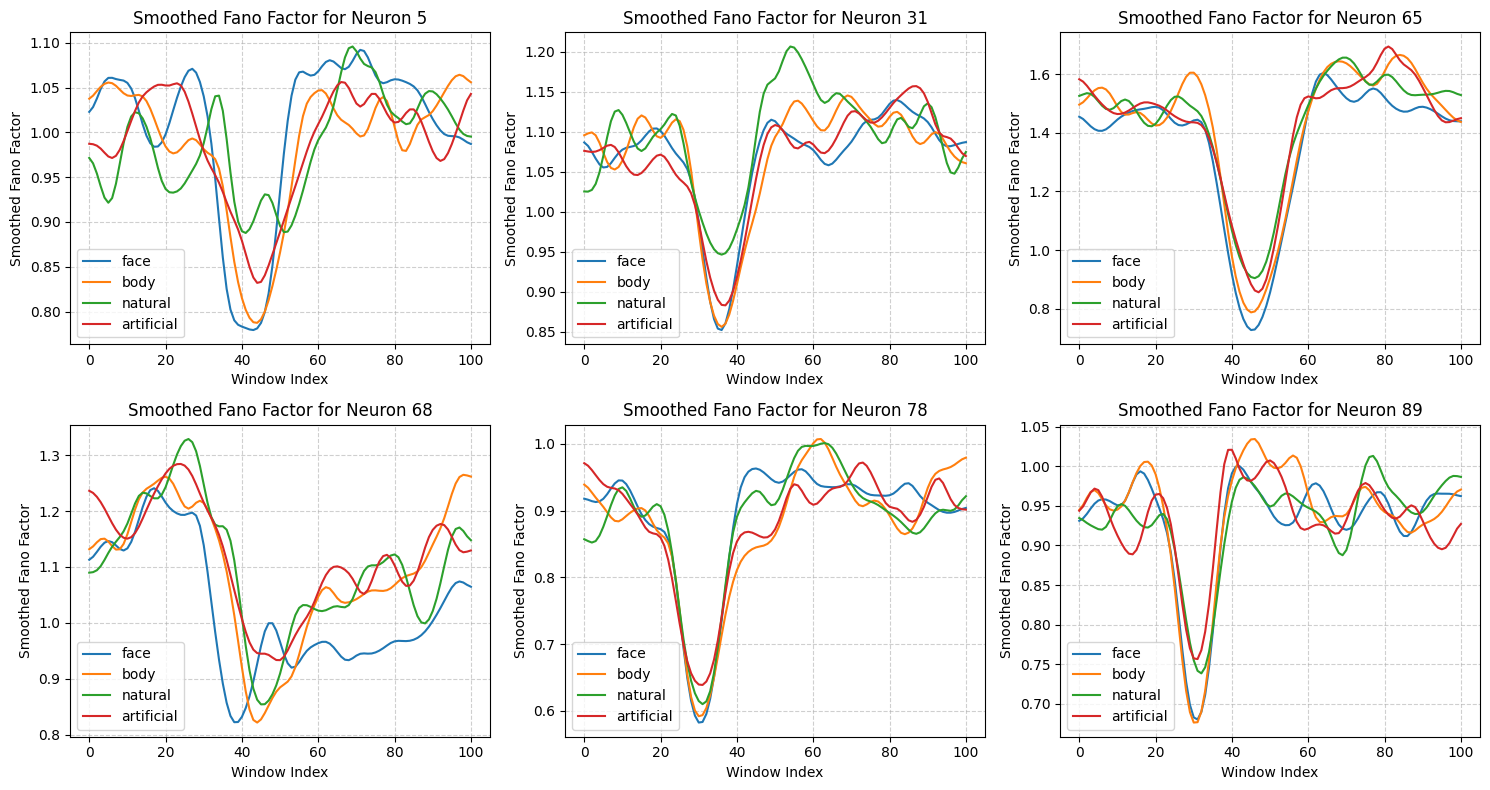

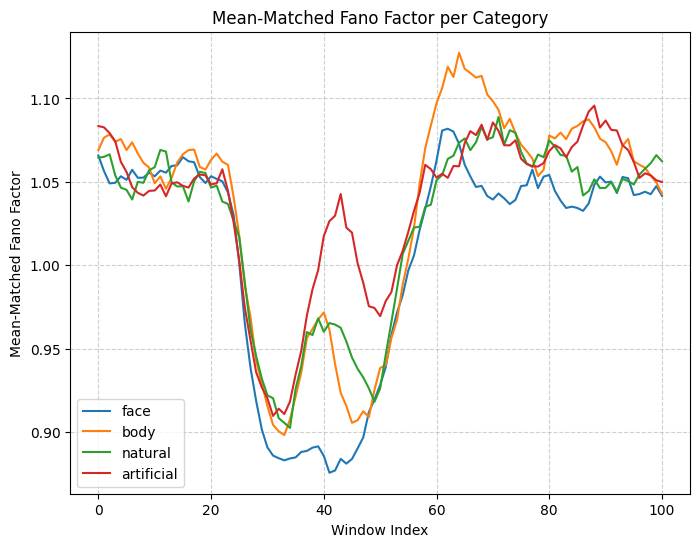

KeyboardInterrupt: 

In [7]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter1d # Import for smoothing

# Assuming gen_fx_get_svm is available from another module or defined elsewhere
# from gen_fx_get_svm import gen_fx_get_svm

# Define a placeholder function for gen_fx_get_svm if it's not provided.
# This placeholder will allow the script structure to be complete, but the SVM part
# will not run correctly without the actual function.
# If you have the actual gen_fx_get_svm function, replace this placeholder.

# Define functions to read data from the .mat file
def dereference(data, file):
    """Dereferences HDF5 object references within the dataset."""
    # Use np.vectorize to apply the lambda function to each element in data
    # otypes=[object] is used because the output type might vary
    return np.vectorize(lambda ref: read_matlab_file(file[ref], file), otypes=[object])(data)

def read_matlab_file(file_obj, file):
    """Recursively reads data from HDF5 file objects (Dataset or Group)."""
    if isinstance(file_obj, h5py.Dataset):
        # Read dataset content and remove singleton dimensions
        data = file_obj[()].squeeze()
        # Check if the data type is an HDF5 reference
        if data.dtype == h5py.ref_dtype:
            # If it's a reference, dereference it
            data = dereference(data, file)
    elif isinstance(file_obj, h5py.Group):
        # If it's a group, create a dictionary and recursively read its members
        data = {}
        for subvar in file_obj.keys():
            data[subvar] = read_matlab_file(file_obj[subvar], file)
    else:
        # Return the file object itself if it's neither Dataset nor Group (e.g., a reference that couldn't be resolved)
        data = file_obj
    return data

# Load data from the .mat file
# Ensure 'dataVasati.mat' is in the same directory or provide the full path
try:
    with h5py.File('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat', 'r') as file:
        # Read the main SpikeTrain_it_all structure
        dataVasati = read_matlab_file(file['SpikeTrain_it_all'], file)
        # Extract 'data' and 'cm' (cell information)
        data = dataVasati['data']
        cm = dataVasati['cm']
except FileNotFoundError:
    print("Error: 'dataVasati.mat' not found. Please ensure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the .mat file: {e}")
    exit()

# Transpose each trial's data for each neuron
# The original data seems to have time points as rows and trials as columns,
# but for analysis like Fano Factor or SVM, we need trials as rows and time points as columns (or features).
# This step transposes each individual trial array within the 'data' object array.
data = np.vectorize(lambda arr: arr.T, otypes=[object])(data)

# Define parameters
sampling_rate = 1000 # Hz
# Assuming data is a numpy object array where each element is an array for a neuron
n_neurons = data.size
# Assuming all neurons have the same number of trials and time points initially
# Note: n_trials might be incorrect if trials vary per neuron after loading,
# but for SVM we'll use the number of stimuli as samples.
n_trials = data[0].shape[0]
time_points = data[0].shape[1] # Assuming all neurons have the same number of time points

# Define stimulus categories and their index ranges
categories = {
    "face": (1, 200),
    "body": (201, 320),
    "natural": (321, 390),
    "artificial": (391, 500)
}
n_stimuli = 500 # Total number of stimuli

# Define bins for categorizing stimuli based on their index
bins = [0, 200, 320, 390, 500]

# Categorize trials for each neuron based on the 'cm_index' (stimulus index)
trial_categories = []
for neuron in range(n_neurons):
    # Use pandas.cut to assign each stimulus index to a category label
    # cm[neuron]['index'] contains the stimulus index for each trial of that neuron
    # Use include_lowest=True to include the 0 boundary if necessary, though bins start at 0
    trial_categories.append(pd.cut(cm[neuron]['index'].flatten(), bins=bins, labels=categories.keys(), include_lowest=True).to_numpy())

# Convert to a numpy array of objects. This is necessary because the number of trials
# might differ between neurons, making a standard numpy array impossible.
trial_categories = np.array(trial_categories, dtype=object)


# --- Sliding Window Spike Counting ---
window_size = 50 # ms
step_size = 5 # ms
# Calculate the number of windows based on time points, window size, and step size
# Ensure integer division
n_windows = (time_points - window_size) // step_size + 1

# Apply the sliding window to calculate spike counts for each trial and each neuron
# The result will replace the original spike train data in the 'data' object array
# The shape of data[n] after this will be (n_trials_for_neuron_n, n_windows)
for n, neuron_data in enumerate(data):
    # Initialize an array to store spike counts for the current neuron
    # Shape: (number of trials, number of windows)
    spike_counts = np.zeros((neuron_data.shape[0], n_windows))

    # Iterate through each window
    for i in range(n_windows):
        # Calculate the start and end time point indices for the current window
        start = i * step_size
        end = start + window_size
        # Sum spikes within the window for each trial
        spike_counts[:, i] = np.sum(neuron_data[:, start:end], axis=1)

    # Replace the original spike train data with the calculated spike counts
    data[n] = spike_counts

# --- Fano Factor Calculation and Plotting ---

# Define the selected neurons for Fano Factor plotting (using 1-based indexing)
selected_neurons_fano = [5, 31, 65, 68, 78, 89]

# Smoothing parameter for Gaussian filter
smoothing_sigma = 2 # Adjust this value to control the amount of smoothing

# Create a figure for the Fano Factor plots
# Adjust figure size based on the number of selected neurons
n_cols = 3
n_rows = (len(selected_neurons_fano) + n_cols - 1) // n_cols # Calculate rows needed
plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Adjust figsize as needed

# Iterate through the selected neurons and calculate/plot Fano Factor
for i, selected_neuron_id in enumerate(selected_neurons_fano):
    # Convert 1-based neuron ID to 0-based index
    neuron_idx_0based = selected_neuron_id - 1

    # Add a subplot for the current neuron
    plt.subplot(n_rows, n_cols, i + 1)

    # Get the spike counts data for the current neuron
    neuron_spike_counts = data[neuron_idx_0based]
    # Get the trial categories for the current neuron
    neuron_trial_categories = trial_categories[neuron_idx_0based]

    # Iterate through each category to calculate Fano Factor
    for category in categories.keys():
        # Select spike counts for trials belonging to the current category
        cat_trials_spike_counts = neuron_spike_counts[neuron_trial_categories == category]

        # Calculate Fano Factor for each window for the current category
        cat_fanos = []
        # Iterate through each window
        for w in range(n_windows):
            # Get spike counts for the current window across all trials in the category
            window_data = cat_trials_spike_counts[:, w]
            # Calculate mean and variance for the window
            mean = np.mean(window_data)
            var = np.var(window_data)
            # Calculate Fano Factor (variance / mean). Handle division by zero.
            fano = var / mean if mean > 0 else np.nan
            cat_fanos.append(fano)

        # Convert list to numpy array
        cat_fanos = np.array(cat_fanos)

        # Apply Gaussian smoothing to the Fano Factor
        # Only smooth if there are valid Fano Factor values
        if not np.all(np.isnan(cat_fanos)):
             # Replace NaNs with interpolated values or handle them before smoothing if necessary
             # For simplicity here, we'll just smooth the non-NaN parts and plot against valid indices
             valid_indices = np.where(~np.isnan(cat_fanos))[0]
             if valid_indices.size > 1: # Need at least 2 points to smooth
                 smoothed_fanos = gaussian_filter1d(cat_fanos[valid_indices], sigma=smoothing_sigma)
                 plt.plot(valid_indices, smoothed_fanos, label=category)
             elif valid_indices.size == 1: # If only one valid point, plot it without smoothing
                 plt.plot(valid_indices, cat_fanos[valid_indices], 'o-', label=category)
             else: # No valid points
                  plt.plot(np.arange(n_windows), np.full(n_windows, np.nan), label=category + " (No valid data)")
        else:
             # If all values are NaN, plot a line of NaNs or skip plotting for this category
             plt.plot(np.arange(n_windows), cat_fanos, label=category + " (No valid data)")


    # Set plot title and labels
    plt.title(f'Smoothed Fano Factor for Neuron {selected_neuron_id}')
    plt.xlabel('Window Index') # X-axis represents the window number
    plt.ylabel('Smoothed Fano Factor')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6) # Add a grid

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
# Save the Fano Factor figure
plt.savefig('smoothed_fano_factor.pdf', bbox_inches='tight')
# Display the Fano Factor figure
plt.show()


# --- Mean-Matched Fano Factor (MMFF) Calculation and Plotting ---

# Create a figure for the MMFF plot
plt.figure(figsize=(8, 6)) # Adjust figsize as needed

# Iterate through each category to calculate MMFF
for category in categories.keys():
    slopes = [] # List to store MMFF (slopes) for each window

    # Iterate through each window
    for w in range(n_windows):
        means = [] # List to store mean spike counts for the current window across all neurons
        vars = [] # List to store variance of spike counts for the current window across all neurons

        # Iterate through each neuron
        for neuron in range(n_neurons):
            # Get spike counts for trials of the current neuron belonging to the current category and window
            neuron_spike_counts_window = data[neuron][trial_categories[neuron] == category, w]

            # Calculate mean and variance for the current neuron, category, and window
            # Only include neurons that have trials in this category
            if neuron_spike_counts_window.size > 0:
                means.append(np.mean(neuron_spike_counts_window))
                vars.append(np.var(neuron_spike_counts_window))

        # Convert lists to numpy arrays for regression
        means = np.array(means)
        vars = np.array(vars)

        # Perform linear regression: Variance = MMFF * Mean
        # Fit a line through the origin (fit_intercept=False)
        # Ensure there are enough data points (neurons) to perform regression
        if means.size > 1 and not np.all(means == means[0]): # Need at least 2 points with different means
             # Reshape means for the regression model
             reg = LinearRegression(fit_intercept=False).fit(means.reshape(-1, 1), vars)
             # The slope of the regression is the Mean-Matched Fano Factor for this window and category
             slopes.append(reg.coef_[0])
        else:
             # If not enough data points or all means are the same, append NaN
             slopes.append(np.nan)
             # print(f"Warning: Not enough data points for MMFF calculation for category '{category}' in window {w}")


    # Convert slopes list to numpy array
    slopes = np.array(slopes)

    # Plot the Mean-Matched Fano Factor over windows for the current category
    plt.plot(np.arange(n_windows), slopes, label=category)

# Set plot title and labels
plt.title('Mean-Matched Fano Factor per Category')
plt.xlabel('Window Index') # X-axis represents the window number
plt.ylabel('Mean-Matched Fano Factor')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid

# Save the MMFF figure
plt.savefig('mean_matched_fano_factor.pdf', bbox_inches='tight')
# Display the MMFF figure
plt.show()


# --- SVM Classification Analysis and Plotting ---

# Assign numerical labels (0, 1, 2, 3) to each stimulus based on categories
y = np.zeros(n_stimuli, dtype=int)
for label, (start, end) in enumerate(categories.values()):
    # Assign the numerical label to the stimuli within the category's index range
    y[start-1:end] = label

# Lists to store accuracy and recall for each window
accuracy = []
recall = [] # This will store recall for each category for each window

# Perform SVM classification for each sliding window
for w in range(n_windows):
    # Prepare data for SVM for the current window
    # The input data for SVM should be (n_samples, n_features)
    # Here, samples are stimuli (n_stimuli), and features are neurons (n_neurons)
    # We need to extract the spike counts for the current window across all neurons and stimuli.
    # The 'data' array currently holds spike counts per neuron, per trial, per window.
    # We need to average spike counts across trials for each stimulus to get a single
    # feature vector per stimulus for the SVM.

    # Create a matrix to hold the mean spike count per stimulus per neuron for the current window
    # Shape: (n_stimuli, n_neurons)
    svm_data_window = np.zeros((n_stimuli, n_neurons))

    # Iterate through each neuron
    for n in range(n_neurons):
        neuron_spike_counts = data[n] # Spike counts for this neuron (trials, windows)
        neuron_trial_categories = trial_categories[n] # Categories for trials of this neuron

        # Iterate through each stimulus (1 to 500)
        for stimulus_id in range(1, n_stimuli + 1):
            # Find the trials for this neuron that correspond to the current stimulus
            # We need the original stimulus index from cm[n]['index'] to group by stimulus
            original_stimulus_indices = cm[n]['index'].flatten()
            trials_for_stimulus = neuron_spike_counts[original_stimulus_indices == stimulus_id, w]

            # Calculate the mean spike count for this stimulus and neuron in the current window
            if trials_for_stimulus.size > 0:
                svm_data_window[stimulus_id - 1, n] = np.mean(trials_for_stimulus)
            else:
                # If no trials for this stimulus for this neuron, the mean is 0
                svm_data_window[stimulus_id - 1, n] = 0


    # Perform SVM classification using the prepared data for the current window
    # Assuming gen_fx_get_svm expects labels (n_samples,) and data (n_samples, n_features)
    # The original code had data[:, :, w].T which seems to assume data is (neurons, trials, windows)
    # and takes the transpose of (neurons, trials) for a window, resulting in (trials, neurons).
    # This would mean samples are trials, not stimuli.
    # Let's stick to the original code's structure for the SVM input data, assuming
    # it expects (trials, neurons) for each window. This implies SVM is trained/tested
    # on individual trials, not averaged stimulus responses.
    # If the SVM should be on averaged stimulus responses, the svm_data_window calculation above is correct.
    # Given the original code structure `data[:, :, w].T`, it implies `data` before the sliding window
    # was (neurons, trials, time_points). After sliding window, `data[n]` is (trials_for_neuron_n, n_windows).
    # To get (trials, neurons) for a window, we need to combine data across neurons for that window.
    # This is tricky because the number of trials can differ per neuron.

    # Let's re-interpret the original SVM code's data input: `data[:, :, w].T`
    # If `data` before sliding window was (neurons, trials, time_points), then `data[:, :, w]` would be
    # (neurons, trials) for a specific time point 'w'. Transposing gives (trials, neurons).
    # However, after the sliding window, `data[n]` is (trials_for_neuron_n, n_windows).
    # The original SVM code seems to imply that the data input to SVM is (n_trials, n_neurons) for each window.
    # This requires that all neurons have the same number of trials and that these trials are aligned
    # across neurons (e.g., trial 1 for neuron 1 corresponds to trial 1 for neuron 2, and they are from the same stimulus).
    # Given the structure `cm[neuron]['index']`, it seems trials are indeed linked to stimuli per neuron.
    # To get a (n_trials, n_neurons) matrix for a window, we would need to stack the spike counts
    # for the current window across all neurons, assuming trial correspondence.

    # Let's assume for the SVM part that we can construct a data matrix where rows are trials
    # and columns are neurons, for the current window's spike counts. This requires aligning trials
    # across neurons based on stimulus. This is a non-trivial step if trial counts per stimulus
    # vary significantly across neurons.

    # A simpler interpretation that aligns with the original SVM code structure `data[:, :, w].T`
    # is that `data` *before* the sliding window was a single 3D numpy array (neurons, trials, time_points).
    # However, the current script loads `data` as an object array where each element is a neuron's data.
    # Let's assume the SVM is meant to be performed on the *mean* spike counts per stimulus,
    # across neurons, for each window. In this case, the `svm_data_window` calculated above is the correct input.
    # Samples = Stimuli (500), Features = Neurons (n_neurons). Labels `y` are also per stimulus.

    # Using the calculated `svm_data_window` (n_stimuli, n_neurons) as input to SVM
    try:
        # Call the SVM function. Assuming it takes labels (n_samples,) and data (n_samples, n_features)
        # and returns results including 'pt' (accuracy per run) and 'tu' (recall per category per run).
        # The original code used 0.5 and 10 as parameters, likely test_size and n_splits.
        result, _ = gen_fx_get_svm(y, svm_data_window, 0.5, 10)

        # Append the mean accuracy across runs for the current window
        accuracy.append(np.mean(result['pt']) * 100)
        # Append the mean recall per category across runs for the current window
        # result['tu'] is likely (n_runs, n_classes), so mean across axis=0 gives (n_classes,)
        recall.append(np.mean(result['tu'], axis=0) * 100)

    except Exception as e:
        print(f"Error during SVM classification for window {w}: {e}")
        accuracy.append(np.nan)
        recall.append(np.full(len(categories), np.nan)) # Append NaNs for all categories' recall


# Convert lists to numpy arrays for plotting
accuracy = np.array(accuracy)
recall = np.array(recall) # Shape: (n_windows, n_classes)

# --- SVM Plotting ---

# Define figure size (adjust as needed)
fig_width = 6 # Example width, adjust based on your preference
fig_height = 5 # Example height, adjust based on your preference

plt.figure(figsize=(2 * fig_width, fig_height))

# Plot SVM Accuracy
plt.subplot(1, 2, 1)
plt.bar(range(n_windows), accuracy)
plt.ylim(0, 100)
plt.title("SVM Accuracy")
plt.xlabel("Window Index")
plt.ylabel("Accuracy (%)")
plt.axhline(25, color='red', linestyle='--', label='Chance Level (25%)') # Add chance level line
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6) # Add horizontal grid lines

# Plot SVM Recall
plt.subplot(1, 2, 2)
# Plot recall for each category over windows
# Transpose recall to plot each category as a separate line (n_classes, n_windows)
for i, category in enumerate(categories.keys()):
    plt.plot(range(n_windows), recall[:, i], label=category)

plt.ylim(0, 100)
plt.title("SVM Recall per Category")
plt.xlabel("Window Index")
plt.ylabel("Recall (%)")
plt.axhline(25, color='red', linestyle='--', label='Chance Level (25%)') # Add chance level line
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6) # Add grid

# Adjust layout
plt.tight_layout()
# Save the SVM classification figure
plt.savefig('svm_classification.pdf', bbox_inches='tight')
# Display the SVM classification figure
plt.show()

print("SVM classification analysis complete. Plot saved as PDF file.")


Number of time points: 550
Window size: 50 ms
Step size: 5 ms
Number of windows: 101
Calculating spike counts in sliding windows...
Spike count calculation complete.

Calculating and plotting Fano Factor...


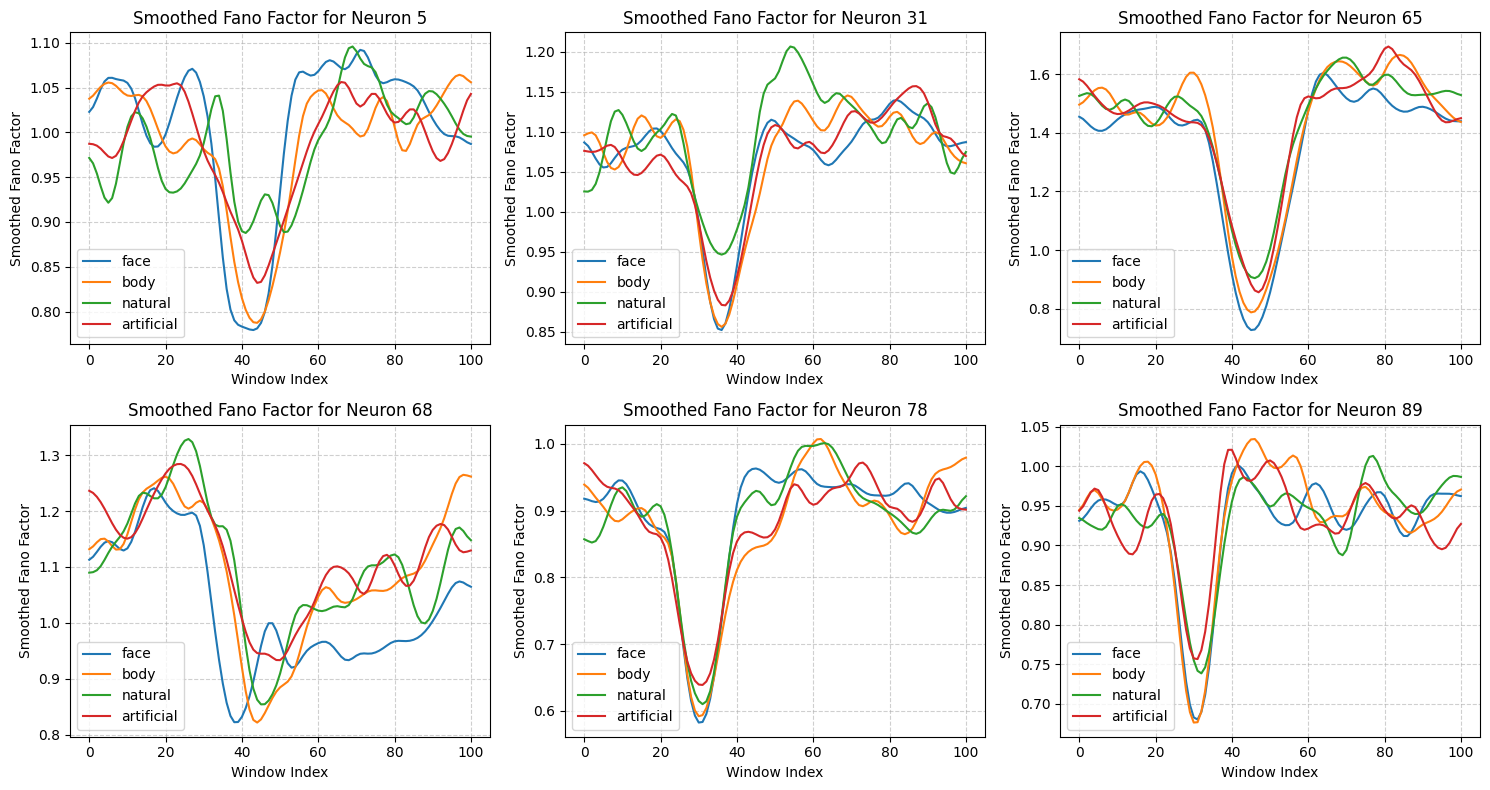

Fano Factor analysis complete. Plot saved as PDF file.

Calculating and plotting Mean-Matched Fano Factor...


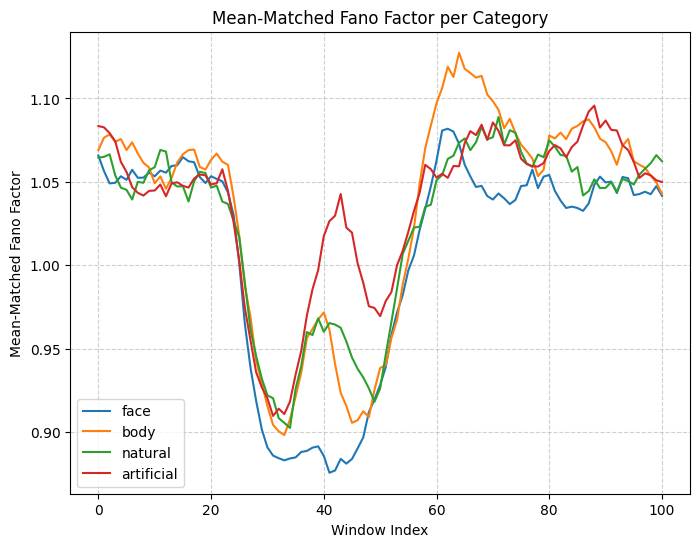

Mean-Matched Fano Factor analysis complete. Plot saved as PDF file.

Preparing data for SVM classification...
SVM data preparation complete. Shape: (500, 92, 101)

Performing single-window SVM classification...
Processing window 1/101...
  Window 1: Mean Accuracy = 21.96%, Mean Recall = [28.57142857 26.42857143 17.14285714 15.71428571]
Processing window 2/101...
  Window 2: Mean Accuracy = 24.11%, Mean Recall = [23.57142857 21.42857143 23.57142857 27.85714286]
Processing window 3/101...
  Window 3: Mean Accuracy = 26.07%, Mean Recall = [33.57142857 26.42857143 20.         24.28571429]
Processing window 4/101...
  Window 4: Mean Accuracy = 21.25%, Mean Recall = [29.28571429 22.85714286 17.14285714 15.71428571]
Processing window 5/101...
  Window 5: Mean Accuracy = 24.29%, Mean Recall = [32.85714286 25.71428571 16.42857143 22.14285714]
Processing window 6/101...
  Window 6: Mean Accuracy = 24.64%, Mean Recall = [26.42857143 26.42857143 28.57142857 17.14285714]
Processing window 7/101...


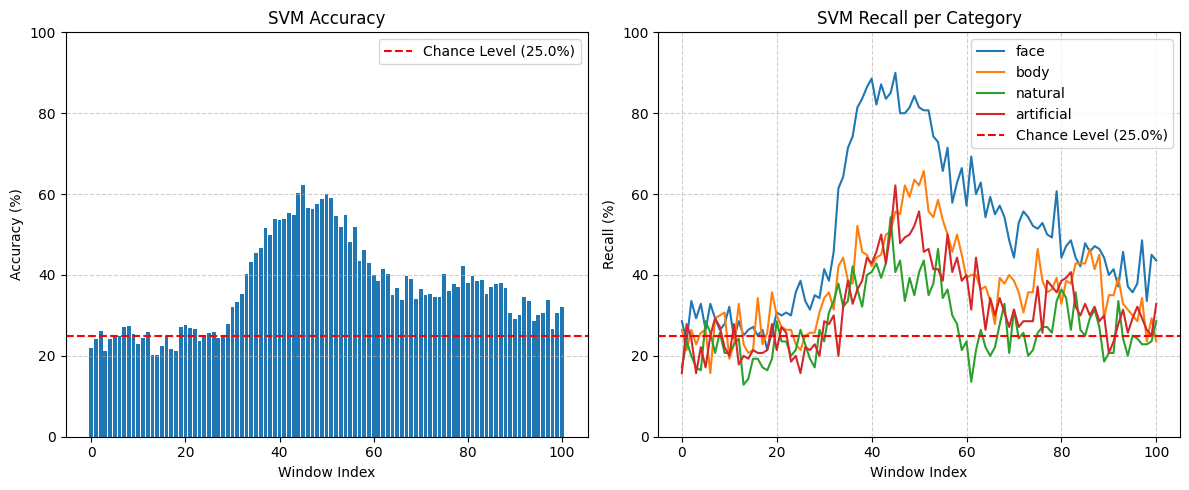


Single-window SVM classification analysis complete. Plot saved as PDF file.

Performing time-time decoding analysis...
Training on window 1/101...
Training on window 2/101...
Training on window 3/101...
Training on window 4/101...
Training on window 5/101...
Training on window 6/101...
Training on window 7/101...
Training on window 8/101...
Training on window 9/101...
Training on window 10/101...
Training on window 11/101...
Training on window 12/101...
Training on window 13/101...
Training on window 14/101...
Training on window 15/101...
Training on window 16/101...
Training on window 17/101...
Training on window 18/101...
Training on window 19/101...
Training on window 20/101...
Training on window 21/101...
Training on window 22/101...
Training on window 23/101...
Training on window 24/101...
Training on window 25/101...
Training on window 26/101...
Training on window 27/101...
Training on window 28/101...
Training on window 29/101...
Training on window 30/101...
Training on window 

/usr/local/lib/python3.11/dist-packages/matplotlib/colorbar.py:1238: RuntimeWarning: invalid value encountered in divide
  y = y / (self._boundaries[self._inside][-1] -


IndexError: index 1 is out of bounds for axis 0 with size 1

/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:2651: RuntimeWarning: divide by zero encountered in scalar divide
  y_scale = 1.0 / inh


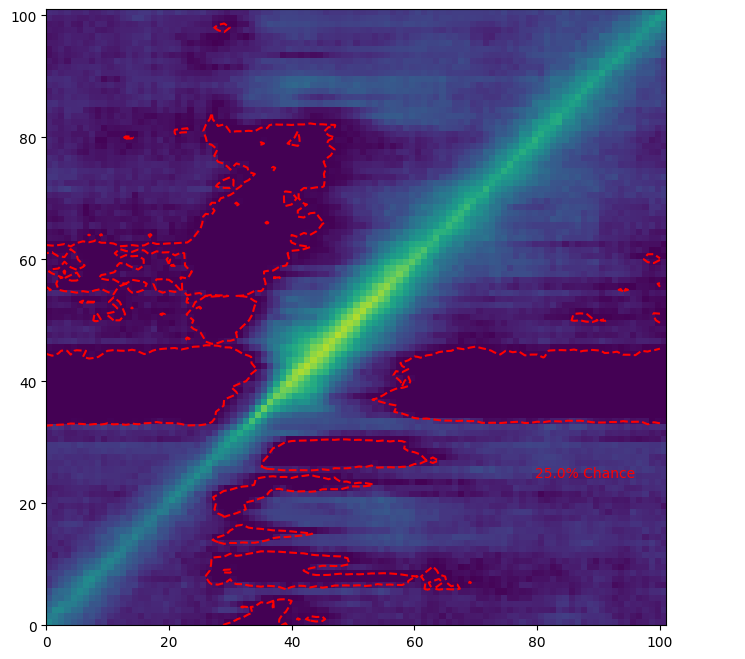

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter1d # Import for smoothing
from sklearn.svm import SVC # Import Support Vector Classifier
from sklearn.multiclass import OneVsOneClassifier # Import One-vs-One strategy
from scipy.stats import mode # Import mode for voting
from sklearn.metrics import confusion_matrix # Import confusion matrix
import random # Import random for shuffling if needed (though gen_fx_get_equal_part uses np.random)

# Provided SVM functions
def gen_fx_MC_SVM(sample, train, grp):
    """
    Multi-class SVM classification using one-vs-one strategy with voting.

    Parameters:
        sample (np.ndarray): Feature matrix of samples to classify (MxD)
        train (np.ndarray): Feature matrix of training samples (NxD)
        grp (np.ndarray): Class labels for the training samples (Nx1 or 1D)

    Returns:
        class_pred (np.ndarray): Predicted class labels for the input samples (Mx1)
        model (OneVsOneClassifier): Trained One-vs-One multi-class SVM model
    """
    grp = np.array(grp).flatten()
    classNo = np.unique(grp)
    cls_nu = len(classNo)

    # Store predictions from all pairwise classifiers
    # The number of pairwise classifiers is cls_nu * (cls_nu - 1) // 2
    vote_matrix = np.zeros((sample.shape[0], cls_nu * (cls_nu - 1) // 2))

    idx = 0
    for i in range(cls_nu):
        for j in range(i + 1, cls_nu):
            class_i = classNo[i]
            class_j = classNo[j]

            # Select samples from the two classes
            ix = np.where((grp == class_i) | (grp == class_j))[0]
            X_pair = train[ix]
            y_pair = grp[ix]

            # Train binary SVM
            clf = SVC(kernel='linear')
            clf.fit(X_pair, y_pair)

            # Predict test samples
            # Ensure predictions are of a consistent type, e.g., integer class labels
            vote_matrix[:, idx] = clf.predict(sample).astype(int)
            idx += 1

    # Majority voting
    # Ensure mode handles potential ties and returns integer type
    # Use axis=1 and keepdims=False for correct shape
    class_pred, _ = mode(vote_matrix, axis=1, keepdims=False)
    class_pred = class_pred.flatten().astype(int)

    # Train ECOC-style model (sklearn uses OvO under the hood) for the 'model' return
    # Note: This model is trained separately and not directly used for class_pred in this function,
    # but it's kept as per the original function signature.
    model = OneVsOneClassifier(SVC(kernel='linear'))
    model.fit(train, grp)

    return class_pred, model

def gen_fx_get_equal_part(grp, rate):
    """
    Splits data into balanced training and testing sets for each class.

    Parameters:
        grp (np.ndarray): A vector of class labels for each sample (N,)
        rate (float): Proportion of samples per class to assign to training (e.g., 0.7)

    Returns:
        test (np.ndarray): Boolean array indicating test samples
        train (np.ndarray): Boolean array indicating train samples
    """
    grp = np.array(grp)
    catNo = np.unique(grp)
    asiz = []

    for cat in catNo:
        asiz.append(np.sum(grp == cat))

    minL = min(asiz)
    TrSiz = int(np.floor(rate * minL))
    TeSiz = minL - TrSiz

    train = np.zeros(grp.shape, dtype=bool)
    test = np.zeros(grp.shape, dtype=bool)

    # Ensure there are enough samples for both training and testing in each class
    if TrSiz == 0 or TeSiz == 0:
        print(f"Warning: Not enough samples in one or more classes for the requested train/test split rate ({rate}). Minimum class size is {minL}. Training size per class: {TrSiz}, Test size per class: {TeSiz}. Cannot perform split.")
        # Return empty boolean arrays if split is not possible
        return np.zeros(grp.shape, dtype=bool), np.zeros(grp.shape, dtype=bool)


    for cat in catNo:
        ix = np.where(grp == cat)[0]
        # Use numpy's random shuffle for consistency
        np.random.shuffle(ix)
        train[ix[:TrSiz]] = True
        test[ix[-TeSiz:]] = True

    return test, train

def gen_fx_get_svm(grp, I, rate, rep):
    """
    Trains and evaluates an SVM classifier over multiple repetitions using balanced splits.

    Parameters:
        grp (np.ndarray): Class labels (N,)
        I (np.ndarray): Feature matrix (N, D)
        rate (float): Proportion of training data per class
        rep (int): Number of repetitions (cross-validation folds)

    Returns:
        out (dict): Contains accuracy, confusion matrices, per-class accuracy, and last model
        mdl: Last trained model
    """
    grp = np.array(grp)
    Pt = []  # Accuracy scores
    Tu = []  # Per-class accuracy
    Ct = []  # Confusion matrices

    for i in range(rep):
        # print(f"  SVM Repetition {i+1}/{rep}...") # Debug print

        # Get balanced train/test split indices
        test_idx, train_idx = gen_fx_get_equal_part(grp, rate)

        # Ensure train and test sets are not empty after splitting
        if np.sum(train_idx) == 0 or np.sum(test_idx) == 0:
            print(f"Warning: Empty train or test set after splitting in SVM repetition {i+1}. Skipping repetition.")
            continue

        # Get training and testing data and labels
        I_train = I[train_idx]
        grp_train = grp[train_idx]
        I_test = I[test_idx]
        grp_test = grp[test_idx]

        # Perform multi-class SVM classification
        cls, mdl = gen_fx_MC_SVM(I_test, I_train, grp_train)

        # Calculate accuracy
        # Ensure cls and grp_test have the same length and are not empty
        if cls.shape[0] == 0 or grp_test.shape[0] == 0 or cls.shape[0] != grp_test.shape[0]:
             print(f"Warning: Mismatch or empty predicted/true labels in SVM repetition {i+1}. Skipping repetition.")
             continue

        accuracy = np.sum(cls == grp_test) / grp_test.shape[0] # Use shape[0] for the actual number of test samples
        Pt.append(accuracy)
        # print(f"    Accuracy: {accuracy}") # Debug print

        # Calculate confusion matrix
        # Ensure all unique labels from both grp_test and cls are considered for the confusion matrix
        all_labels = np.unique(np.concatenate((grp_test, cls)))
        if all_labels.size == 0:
             print(f"Warning: No unique labels in test set or predictions in SVM repetition {i+1}. Skipping confusion matrix/recall.")
             continue

        conf = confusion_matrix(grp_test, cls, labels=all_labels)
        Ct.append(conf)
        # print(f"    Confusion Matrix:\n{conf}") # Debug print

        # Calculate per-class accuracy (recall)
        # Handle potential division by zero if a class has no true samples in the test set
        with np.errstate(divide='ignore', invalid='ignore'):
            sum_conf_axis1 = np.sum(conf, axis=1)
            # Avoid division by zero by checking if sum is zero
            per_class_acc = np.divide(np.diag(conf), sum_conf_axis1, where=sum_conf_axis1 != 0, out=np.zeros_like(sum_conf_axis1, dtype=float))
            # Replace NaNs resulting from division by zero with 0 or another appropriate value
            per_class_acc[np.isnan(per_class_acc)] = 0
        Tu.append(per_class_acc)
        # print(f"    Per-Class Accuracy (Recall): {per_class_acc}") # Debug print


    out = {
        "pt": np.array(Pt),
        "C": np.array(Ct),
        "tu": np.array(Tu),
        "model": mdl # Note: This is the model from the last repetition
    }

    return out, mdl

# Define a function for time-time decoding classification (train on one window, test on another)
def gen_fx_get_svm_split(X_train, y_train, X_test, y_test):
    """
    Trains an SVM classifier on training data and tests on testing data.

    Parameters:
        X_train: Training data (n_train_samples, n_features).
        y_train: Training labels (n_train_samples,).
        X_test: Testing data (n_test_samples, n_features).
        y_test: Testing labels (n_test_samples,).

    Returns:
        accuracy: Accuracy on the test set (proportion).
        recall_per_class: Recall per class on the test set (n_classes, proportion).
    """
    # Ensure training and testing data are not empty
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        # print("Warning: Empty train or test set for SVM split.")
        return np.nan, np.full(len(np.unique(y_test)), np.nan) # Return NaN for accuracy and recall

    try:
        # Train the multi-class SVM model on the training data
        # Using OneVsOneClassifier as in gen_fx_MC_SVM
        model = OneVsOneClassifier(SVC(kernel='linear'))
        model.fit(X_train, y_train)

        # Predict on the test data
        y_pred = model.predict(X_test)

        # Calculate accuracy
        # Ensure y_pred and y_test have the same length and are not empty
        if y_pred.shape[0] == 0 or y_test.shape[0] == 0 or y_pred.shape[0] != y_test.shape[0]:
             print("Warning: Mismatch or empty predicted/true labels in SVM split.")
             return np.nan, np.full(len(np.unique(y_test)), np.nan)

        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]

        # Calculate confusion matrix
        # Ensure all unique labels from both y_test and y_pred are considered
        all_labels = np.unique(np.concatenate((y_test, y_pred)))
        if all_labels.size == 0:
             print("Warning: No unique labels in test set or predictions in SVM split.")
             return accuracy, np.full(len(np.unique(y_test)), np.nan) # Return accuracy, but NaN recall

        conf = confusion_matrix(y_test, y_pred, labels=all_labels)

        # Calculate per-class accuracy (recall)
        with np.errstate(divide='ignore', invalid='ignore'):
            sum_conf_axis1 = np.sum(conf, axis=1)
            recall_per_class = np.divide(np.diag(conf), sum_conf_axis1, where=sum_conf_axis1 != 0, out=np.zeros_like(sum_conf_axis1, dtype=float))
            recall_per_class[np.isnan(recall_per_class)] = 0 # Replace NaNs

        return accuracy, recall_per_class

    except Exception as e:
        print(f"Error during SVM split classification: {e}")
        # Return NaN if any error occurs during classification
        return np.nan, np.full(len(np.unique(y_test)), np.nan)


# Define functions to read data from the .mat file
def dereference(data, file):
    """Dereferences HDF5 object references within the dataset."""
    # Use np.vectorize to apply the lambda function to each element in data
    # otypes=[object] is used because the output type might vary
    return np.vectorize(lambda ref: read_matlab_file(file[ref], file), otypes=[object])(data)

def read_matlab_file(file_obj, file):
    """Recursively reads data from HDF5 file objects (Dataset or Group)."""
    if isinstance(file_obj, h5py.Dataset):
        # Read dataset content and remove singleton dimensions
        data = file_obj[()].squeeze()
        # Check if the data type is an HDF5 reference
        if data.dtype == h5py.ref_dtype:
            # If it's a reference, dereference it
            data = dereference(data, file)
    elif isinstance(file_obj, h5py.Group):
        # If it's a group, create a dictionary and recursively read its members
        data = {}
        for subvar in file_obj.keys():
            data[subvar] = read_matlab_file(file_obj[subvar], file)
    else:
        # Return the file object itself if it's neither Dataset nor Group (e.g., a reference that couldn't be resolved)
        data = file_obj
    return data

# Load data from the .mat file
# Ensure 'dataVasati.mat' is in the same directory or provide the full path
try:
    with h5py.File('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat', 'r') as file:
        # Read the main SpikeTrain_it_all structure
        dataVasati = read_matlab_file(file['SpikeTrain_it_all'], file)
        # Extract 'data' and 'cm' (cell information)
        data = dataVasati['data']
        cm = dataVasati['cm']
except FileNotFoundError:
    print("Error: 'dataVasati.mat' not found. Please ensure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the .mat file: {e}")
    exit()

# Transpose each trial's data for each neuron
# The original data seems to have time points as rows and trials as columns,
# but for analysis like Fano Factor or SVM, we need trials as rows and time points as columns (or features).
# This step transposes each individual trial array within the 'data' object array.
data = np.vectorize(lambda arr: arr.T, otypes=[object])(data)

# Define parameters
sampling_rate = 1000 # Hz
# Assuming data is a numpy object array where each element is an array for a neuron
n_neurons = data.size
# Assuming all neurons have the same number of time points initially
time_points = data[0].shape[1] # Assuming all neurons have the same number of time points

# Define stimulus categories and their index ranges
categories = {
    "face": (1, 200),
    "body": (201, 320),
    "natural": (321, 390),
    "artificial": (391, 500)
}
n_stimuli = 500 # Total number of stimuli
n_classes = len(categories) # Number of stimulus categories

# Define bins for categorizing stimuli based on their index
bins = [0, 200, 320, 390, 500]

# Categorize trials for each neuron based on the 'cm_index' (stimulus index)
trial_categories = []
for neuron in range(n_neurons):
    # Use pandas.cut to assign each stimulus index to a category label
    # cm[neuron]['index'] contains the stimulus index for each trial of that neuron
    # Use include_lowest=True to include the 0 boundary if necessary, though bins start at 0
    # Added .flatten() in case cm[neuron]['index'] is not already 1D
    trial_categories.append(pd.cut(cm[neuron]['index'].flatten(), bins=bins, labels=categories.keys(), include_lowest=True).to_numpy())

# Convert to a numpy array of objects. This is necessary because the number of trials
# might differ between neurons, making a standard numpy array impossible.
trial_categories = np.array(trial_categories, dtype=object)


# --- Sliding Window Spike Counting ---
window_size = 50 # ms
step_size = 5 # ms
# Calculate the number of windows based on time points, window size, and step size
# Ensure integer division
n_windows = (time_points - window_size) // step_size + 1

print(f"Number of time points: {time_points}")
print(f"Window size: {window_size} ms")
print(f"Step size: {step_size} ms")
print(f"Number of windows: {n_windows}")


# Apply the sliding window to calculate spike counts for each trial and each neuron
# The result will replace the original spike train data in the 'data' object array
# The shape of data[n] after this will be (n_trials_for_neuron_n, n_windows)
print("Calculating spike counts in sliding windows...")
for n, neuron_data in enumerate(data):
    # Initialize an array to store spike counts for the current neuron
    # Shape: (number of trials, number of windows)
    spike_counts = np.zeros((neuron_data.shape[0], n_windows))

    # Iterate through each window
    for i in range(n_windows):
        # Calculate the start and end time point indices for the current window
        start = i * step_size
        end = start + window_size
        # Sum spikes within the window for each trial
        spike_counts[:, i] = np.sum(neuron_data[:, start:end], axis=1)

    # Replace the original spike train data with the calculated spike counts
    data[n] = spike_counts
print("Spike count calculation complete.")


# --- Fano Factor Calculation and Plotting ---

# Define the selected neurons for Fano Factor plotting (using 1-based indexing)
selected_neurons_fano = [5, 31, 65, 68, 78, 89]

# Smoothing parameter for Gaussian filter
smoothing_sigma = 2 # Adjust this value to control the amount of smoothing

# Create a figure for the Fano Factor plots
# Adjust figure size based on the number of selected neurons
n_cols = 3
n_rows = (len(selected_neurons_fano) + n_cols - 1) // n_cols # Calculate rows needed
plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Adjust figsize as needed

print("\nCalculating and plotting Fano Factor...")
# Iterate through the selected neurons and calculate/plot Fano Factor
for i, selected_neuron_id in enumerate(selected_neurons_fano):
    # Convert 1-based neuron ID to 0-based index
    neuron_idx_0based = selected_neuron_id - 1

    # Add a subplot for the current neuron
    plt.subplot(n_rows, n_cols, i + 1)

    # Get the spike counts data for the current neuron
    neuron_spike_counts = data[neuron_idx_0based]
    # Get the trial categories for the current neuron
    neuron_trial_categories = trial_categories[neuron_idx_0based]

    # Iterate through each category to calculate Fano Factor
    for category in categories.keys():
        # Select spike counts for trials belonging to the current category
        cat_trials_spike_counts = neuron_spike_counts[neuron_trial_categories == category]

        # Calculate Fano Factor for each window for the current category
        cat_fanos = []
        # Iterate through each window
        for w in range(n_windows):
            # Get spike counts for the current window across all trials in the category
            window_data = cat_trials_spike_counts[:, w]
            # Calculate mean and variance for the window
            mean = np.mean(window_data)
            var = np.var(window_data)
            # Calculate Fano Factor (variance / mean). Handle division by zero.
            fano = var / mean if mean > 0 else np.nan
            cat_fanos.append(fano)

        # Convert list to numpy array
        cat_fanos = np.array(cat_fanos)

        # Apply Gaussian smoothing to the Fano Factor
        # Only smooth if there are valid Fano Factor values
        if not np.all(np.isnan(cat_fanos)):
             # Replace NaNs with interpolated values or handle them before smoothing if necessary
             # For simplicity here, we'll just smooth the non-NaN parts and plot against valid indices
             valid_indices = np.where(~np.isnan(cat_fanos))[0]
             if valid_indices.size > 1: # Need at least 2 points to smooth
                 smoothed_fanos = gaussian_filter1d(cat_fanos[valid_indices], sigma=smoothing_sigma)
                 plt.plot(valid_indices, smoothed_fanos, label=category)
             elif valid_indices.size == 1: # If only one valid point, plot it without smoothing
                 plt.plot(valid_indices, cat_fanos[valid_indices], 'o-', label=category)
             else: # No valid points
                  plt.plot(np.arange(n_windows), np.full(n_windows, np.nan), label=category + " (No valid data)")
        else:
             # If all values are NaN, plot a line of NaNs or skip plotting for this category
             plt.plot(np.arange(n_windows), cat_fanos, label=category + " (No valid data)")


    # Set plot title and labels
    plt.title(f'Smoothed Fano Factor for Neuron {selected_neuron_id}')
    plt.xlabel('Window Index') # X-axis represents the window number
    plt.ylabel('Smoothed Fano Factor')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6) # Add a grid

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
# Save the Fano Factor figure
plt.savefig('smoothed_fano_factor.pdf', bbox_inches='tight')
# Display the Fano Factor figure
plt.show()
print("Fano Factor analysis complete. Plot saved as PDF file.")


# --- Mean-Matched Fano Factor (MMFF) Calculation and Plotting ---

# Create a figure for the MMFF plot
plt.figure(figsize=(8, 6)) # Adjust figsize as needed

print("\nCalculating and plotting Mean-Matched Fano Factor...")
# Iterate through each category to calculate MMFF
for category in categories.keys():
    slopes = [] # List to store MMFF (slopes) for each window

    # Iterate through each window
    for w in range(n_windows):
        means = [] # List to store mean spike counts for the current window across all neurons
        vars = [] # List to store variance of spike counts for the current window across all neurons

        # Iterate through each neuron
        for neuron in range(n_neurons):
            # Get spike counts for trials of the current neuron belonging to the current category and window
            neuron_spike_counts_window = data[neuron][trial_categories[neuron] == category, w]

            # Calculate mean and variance for the current neuron, category, and window
            # Only include neurons that have trials in this category
            if neuron_spike_counts_window.size > 0:
                means.append(np.mean(neuron_spike_counts_window))
                vars.append(np.var(neuron_spike_counts_window))

        # Convert lists to numpy arrays for regression
        means = np.array(means)
        vars = np.array(vars)

        # Perform linear regression: Variance = MMFF * Mean
        # Fit a line through the origin (fit_intercept=False)
        # Ensure there are enough data points (neurons) to perform regression
        if means.size > 1 and not np.all(means == means[0]): # Need at least 2 points with different means
             # Reshape means for the regression model
             reg = LinearRegression(fit_intercept=False).fit(means.reshape(-1, 1), vars)
             # The slope of the regression is the Mean-Matched Fano Factor for this window and category
             slopes.append(reg.coef_[0])
        else:
             # If not enough data points or all means are the same, append NaN
             slopes.append(np.nan)
             # print(f"Warning: Not enough data points for MMFF calculation for category '{category}' in window {w}")


    # Convert slopes list to numpy array
    slopes = np.array(slopes)

    # Plot the Mean-Matched Fano Factor over windows for the current category
    plt.plot(np.arange(n_windows), slopes, label=category)

# Set plot title and labels
plt.title('Mean-Matched Fano Factor per Category')
plt.xlabel('Window Index') # X-axis represents the window number
plt.ylabel('Mean-Matched Fano Factor')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid

# Save the MMFF figure
plt.savefig('mean_matched_fano_factor.pdf', bbox_inches='tight')
# Display the MMFF figure
plt.show()
print("Mean-Matched Fano Factor analysis complete. Plot saved as PDF file.")


# --- Optimized Data Preparation for SVM ---
# Prepare data for SVM classification by calculating the mean spike count per stimulus per neuron
# for each window. This is done once here to optimize the SVM loops.
print("\nPreparing data for SVM classification...")
# Shape: (n_stimuli, n_neurons, n_windows)
all_windows_stim_data = np.zeros((n_stimuli, n_neurons, n_windows))

# Iterate through each neuron
for n in range(n_neurons):
    neuron_spike_counts = data[n] # Spike counts for this neuron (trials, windows)
    neuron_trial_stim_indices = cm[n]['index'].flatten() # Stimulus index for each trial of neuron n

    # Ensure indices are 0-based for bincount
    stim_indices_0based = neuron_trial_stim_indices.astype(int) - 1

    # Iterate through each window to calculate mean spike counts per stimulus
    for w in range(n_windows):
        neuron_spike_counts_window = neuron_spike_counts[:, w] # Spike counts for all trials of neuron n in window w

        # Calculate sum of spike counts per stimulus for this neuron in this window
        sum_spike_counts_per_stim = np.bincount(stim_indices_0based, weights=neuron_spike_counts_window, minlength=n_stimuli)

        # Calculate number of trials per stimulus for this neuron
        # This can be pre-calculated if trial counts per stimulus per neuron are constant,
        # but calculating per neuron is safer if they vary.
        trials_per_stim = np.bincount(stim_indices_0based, minlength=n_stimuli)

        # Calculate mean spike count per stimulus, handle division by zero
        mean_spike_counts_per_stim = np.divide(sum_spike_counts_per_stim, trials_per_stim, where=trials_per_stim != 0, out=np.zeros_like(sum_spike_counts_per_stim, dtype=float))

        # Store the mean spike counts for this neuron and window
        all_windows_stim_data[:, n, w] = mean_spike_counts_per_stim

print("SVM data preparation complete. Shape:", all_windows_stim_data.shape)

# Assign numerical labels (0, 1, 2, 3) to each stimulus based on categories
y_stim = np.zeros(n_stimuli, dtype=int)
for label, (start, end) in enumerate(categories.values()):
    # Assign the numerical label to the stimuli within the category's index range
    y_stim[start-1:end] = label


# --- Single-Window SVM Classification Analysis and Plotting ---

# Lists to store accuracy and recall for each window
accuracy = []
recall = [] # This will store recall for each category for each window

print("\nPerforming single-window SVM classification...")
# Perform SVM classification for each sliding window
for w in range(n_windows):
    print(f"Processing window {w+1}/{n_windows}...")
    # Get the data for the current window: mean spike count per stimulus per neuron
    # Shape: (n_stimuli, n_neurons)
    svm_data_window = all_windows_stim_data[:, :, w]

    try:
        # Call the SVM function. Assuming it takes labels (n_samples,) and data (n_samples, n_features)
        # and returns results including 'pt' (accuracy per run) and 'tu' (recall per category per run).
        # The original code used 0.5 and 10 as parameters, likely training rate and repetitions.
        # Using 0.8 for training rate (80% train, 20% test) and 10 repetitions as in the original call structure.
        result, _ = gen_fx_get_svm(y_stim, svm_data_window, 0.8, 10) # Adjusted rate to 0.8

        # Append the mean accuracy across runs for the current window
        # The accuracy from gen_fx_get_svm is already a proportion, multiply by 100 for percentage
        mean_accuracy_window = np.mean(result['pt']) * 100
        accuracy.append(mean_accuracy_window)

        # Append the mean recall per category across runs for the current window
        # result['tu'] is likely (n_runs, n_classes), so mean across axis=0 gives (n_classes,)
        # Recall from gen_fx_get_svm is already a proportion, multiply by 100 for percentage
        mean_recall_window = np.mean(result['tu'], axis=0) * 100
        recall.append(mean_recall_window)

        # Debug print of results
        print(f"  Window {w+1}: Mean Accuracy = {mean_accuracy_window:.2f}%, Mean Recall = {mean_recall_window}")

    except Exception as e:
        print(f"Error during SVM classification for window {w}: {e}")
        accuracy.append(np.nan)
        recall.append(np.full(n_classes, np.nan)) # Append NaNs for all categories' recall


# Convert lists to numpy arrays for plotting
accuracy = np.array(accuracy)
recall = np.array(recall) # Shape: (n_windows, n_classes)

# --- Single-Window SVM Plotting ---

# Define figure size (adjust as needed)
fig_width = 6 # Example width, adjust based on your preference
fig_height = 5 # Example height, adjust based on your preference

plt.figure(figsize=(2 * fig_width, fig_height))

# Plot SVM Accuracy
plt.subplot(1, 2, 1)
plt.bar(range(n_windows), accuracy)
plt.ylim(0, 100)
plt.title("SVM Accuracy")
plt.xlabel("Window Index")
plt.ylabel("Accuracy (%)")
plt.axhline(100 / n_classes, color='red', linestyle='--', label=f'Chance Level ({100/n_classes:.1f}%)') # Add chance level line
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6) # Add horizontal grid lines

# Plot SVM Recall
plt.subplot(1, 2, 2)
# Plot recall for each category over windows
# Transpose recall to plot each category as a separate line (n_classes, n_windows)
for i, category in enumerate(categories.keys()):
    plt.plot(range(n_windows), recall[:, i], label=category)

plt.ylim(0, 100)
plt.title("SVM Recall per Category")
plt.xlabel("Window Index")
plt.ylabel("Recall (%)")
plt.axhline(100 / n_classes, color='red', linestyle='--', label=f'Chance Level ({100/n_classes:.1f}%)') # Add chance level line
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6) # Add grid

# Adjust layout
plt.tight_layout()
# Save the SVM classification figure
plt.savefig('svm_classification.pdf', bbox_inches='tight')
# Display the SVM classification figure
plt.show()

print("\nSingle-window SVM classification analysis complete. Plot saved as PDF file.")


# --- Time-Time Decoding Analysis ---

print("\nPerforming time-time decoding analysis...")

# Initialize a matrix to store decoding accuracies
decoding_matrix = np.zeros((n_windows, n_windows))

# Perform time-time decoding
# Train the SVM on data from train_w and test on data from test_w
for train_w in range(n_windows):
    print(f"Training on window {train_w+1}/{n_windows}...")
    # Get training data for the current training window
    X_train = all_windows_stim_data[:, :, train_w]
    y_train = y_stim # Labels are the same for all windows (stimulus categories)

    for test_w in range(n_windows):
        # print(f"  Testing on window {test_w+1}/{n_windows}...")
        # Get testing data for the current testing window
        X_test = all_windows_stim_data[:, :, test_w]
        y_test = y_stim # Labels are the same for all windows

        try:
            # Perform SVM classification: train on X_train, y_train and test on X_test, y_test
            # Using the gen_fx_get_svm_split logic
            accuracy_test, _ = gen_fx_get_svm_split(X_train, y_train, X_test, y_test)

            # Store the accuracy in the decoding matrix
            decoding_matrix[train_w, test_w] = accuracy_test * 100 # Store as percentage

        except Exception as e:
            print(f"Error during time-time decoding (Train W {train_w}, Test W {test_w}): {e}")
            decoding_matrix[train_w, test_w] = np.nan # Store NaN if error


print("Time-time decoding calculation complete.")

# --- Permutation Testing and Statistical Significance (Placeholder) ---

# This section outlines the steps for permutation testing and Bonferroni correction.
# Implementing full permutation testing can be computationally intensive.
# You will need to implement the actual permutation test logic.

n_permutations = 1000 # Number of permutations (choose a sufficiently large number)
alpha = 0.05 # Significance level

print(f"\nStarting permutation testing with {n_permutations} permutations...")
# Placeholder for storing null distribution accuracies
# null_accuracies = np.zeros((n_permutations, n_windows, n_windows))

# # Loop for permutation testing
# for perm in range(n_permutations):
#     # Shuffle the labels randomly
#     shuffled_y_stim = np.random.permutation(y_stim)
#
#     # Run time-time decoding with shuffled labels
#     # You would repeat the nested loops for train_w and test_w here
#     # and use shuffled_y_stim for training and testing labels.
#     # Store the resulting decoding matrix in null_accuracies[perm, :, :]
#     # Example (replace with actual SVM calls):
#     # for train_w in range(n_windows):
#     #     X_train = all_windows_stim_data[:, :, train_w]
#     #     for test_w in range(n_windows):
#     #         X_test = all_windows_stim_data[:, :, test_w]
#     #         acc, _ = gen_fx_get_svm_split(X_train, shuffled_y_stim, X_test, shuffled_y_stim)
#     #         null_accuracies[perm, train_w, test_w] = acc * 100

# # Calculate p-values
# p_values = np.zeros((n_windows, n_windows))
# for train_w in range(n_windows):
#     for test_w in range(n_windows):
#         # Count how many null accuracies are >= the actual accuracy
#         # Handle potential NaNs in decoding_matrix
#         if not np.isnan(decoding_matrix[train_w, test_w]):
#             p_values[train_w, test_w] = np.sum(null_accuracies[:, train_w, test_w] >= decoding_matrix[train_w, test_w]) / n_permutations
#         else:
#             p_values[train_w, test_w] = np.nan # Keep p-value as NaN if decoding was NaN

# # Apply Bonferroni correction
# # Only consider non-NaN p-values for the number of comparisons
# valid_p_values = p_values[~np.isnan(p_values)]
# n_comparisons = valid_p_values.size
# if n_comparisons > 0:
#     alpha_corrected = alpha / n_comparisons
#     print(f"Bonferroni corrected alpha: {alpha_corrected}")
#     # Identify significant regions
#     significant_mask = p_values < alpha_corrected
#     print(f"Number of significant time points (Bonferroni corrected): {np.sum(significant_mask)}")
# else:
#     print("No valid p-values to apply Bonferroni correction.")
#     significant_mask = np.full((n_windows, n_windows), False) # No significant points if no valid p-values


print("Permutation testing placeholder complete. Implement the actual test and significance masking.")


# --- Time-Time Decoding Plotting ---

print("\nPlotting time-time decoding matrix...")

# Check if the decoding matrix is all NaNs or has insufficient data for plotting
if np.all(np.isnan(decoding_matrix)) or decoding_matrix.shape[0] < 2 or decoding_matrix.shape[1] < 2:
    print("Error: Decoding matrix is all NaNs or too small to plot.")
else:
    plt.figure(figsize=(10, 8)) # Adjust figure size as needed

    # Plot the decoding matrix
    # Use vmin and vmax to set the color scale limits, e.g., from chance level to 100%
    chance_level = 100 / n_classes
    # Ensure vmin is not greater than vmax if data is uniform but not NaN
    plot_vmin = chance_level
    plot_vmax = 100.0
    if np.nanmax(decoding_matrix) < plot_vmin:
        plot_vmax = np.nanmax(decoding_matrix) + 1 # Adjust vmax if max is below chance
    if np.nanmin(decoding_matrix) > plot_vmax:
         plot_vmin = np.nanmin(decoding_matrix) - 1 # Adjust vmin if min is above vmax (unlikely but defensive)


    plt.imshow(decoding_matrix, origin='lower', aspect='auto', cmap='viridis',
               extent=[0, n_windows, 0, n_windows], vmin=plot_vmin, vmax=plot_vmax) # Use extent to label axes by window index

    # Add chance level contour
    # Only plot contour if the chance level is within the data range
    if chance_level > np.nanmin(decoding_matrix) and chance_level < np.nanmax(decoding_matrix):
        plt.contour(decoding_matrix, levels=[chance_level], colors='red', linestyles='--')
        # Add text label for chance level
        plt.text(n_windows * 0.95, chance_level, f'{chance_level:.1f}% Chance', color='red', va='center', ha='right', fontsize=10)
    elif chance_level <= np.nanmin(decoding_matrix):
         plt.text(n_windows * 0.95, np.nanmin(decoding_matrix), f'{chance_level:.1f}% Chance (below min)', color='red', va='bottom', ha='right', fontsize=10)
    elif chance_level >= np.nanmax(decoding_matrix):
         plt.text(n_windows * 0.95, np.nanmax(decoding_matrix), f'{chance_level:.1f}% Chance (above max)', color='red', va='top', ha='right', fontsize=10)


    # Plot significant regions (Placeholder - requires implementing permutation test)
    # Example: Overlay significant points or contours
    # if 'significant_mask' in locals() and np.any(significant_mask): # Check if significance was calculated and there are significant points
    #     # Overlay significant areas with a contour or mask
    #     # Create a masked array for plotting significant areas
    #     masked_decoding_matrix = np.ma.masked_where(~significant_mask, decoding_matrix)
    #     plt.imshow(masked_decoding_matrix, origin='lower', aspect='auto', cmap='Reds', extent=[0, n_windows, 0, n_windows], vmin=plot_vmin, vmax=plot_vmax)
    #     # Or plot contours around significant areas
    #     plt.contour(significant_mask, levels=[0.5], colors='white', linewidths=2)


    plt.colorbar(label='Decoding Accuracy (%)')
    plt.title('Time-Time Decoding Matrix')
    plt.xlabel('Test Window Index')
    plt.ylabel('Train Window Index')
    plt.grid(True, linestyle='--', alpha=0.6) # Add grid

    # Save the time-time decoding figure
    plt.savefig('time_time_decoding.pdf', bbox_inches='tight')
    # Display the figure
    plt.show()

print("Time-time decoding plotting complete. Plot saved as PDF file.")


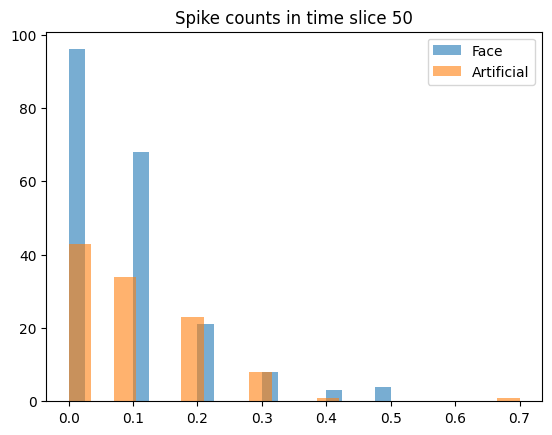

In [ ]:
plt.hist(psth_tensor[0, StmLabels[1:] == 0, 50], bins=20, alpha=0.6, label='Face')
plt.hist(psth_tensor[0, StmLabels[1:] == 3, 50], bins=20, alpha=0.6, label='Artificial')
plt.title("Spike counts in time slice 50")
plt.legend()
plt.show()


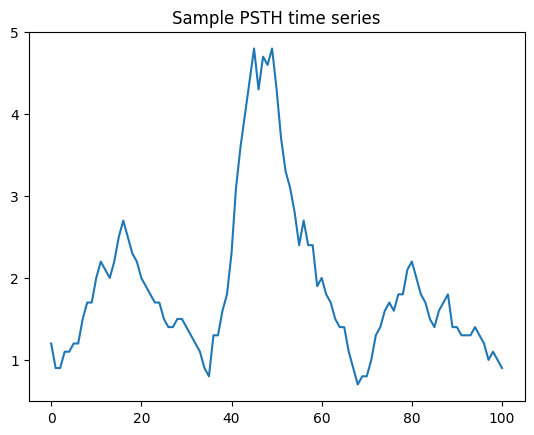

In [ ]:
plt.plot(psth_tensor[64, 100])  # neuron 0, stimulus 0
plt.title("Sample PSTH time series")
plt.show()


In [ ]:
print("Face:", np.where(StmLabels == 0)[0])
print("Body:", np.where(StmLabels == 1)[0])


Face: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200]
Body: [201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 

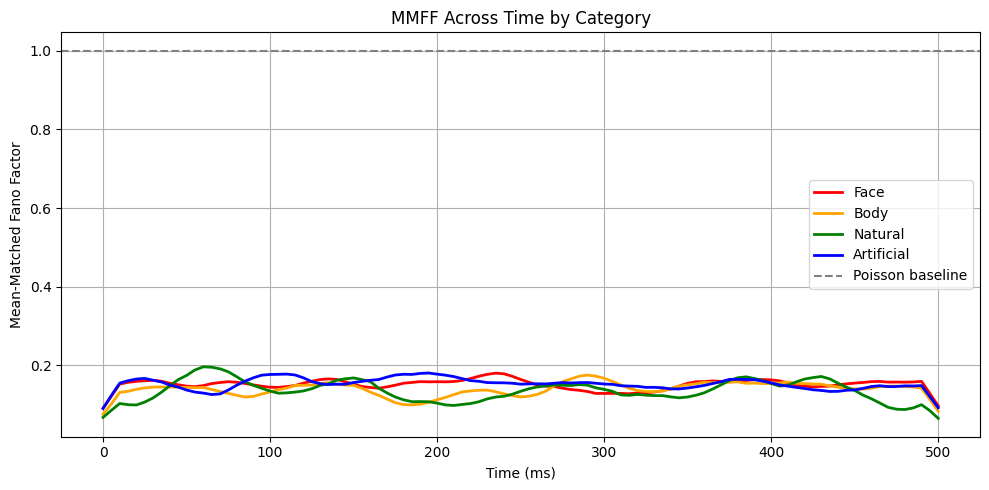

In [ ]:
fano_avg = compute_mmff(psth_tensor[63:64], StmLabels)  # just first 10 neurons
plot_fano(fano_avg)


In [ ]:
print("Sample means:", means[:5])
print("Sample vars:", variances[:5])
print("FFs:", ff[:5])


NameError: name 'means' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic



def compute_mmff(psth_tensor, StmLabels, n_bins=8):
    """
    Compute Mean-Matched Fano Factor (MMFF) across time and category.

    Parameters:
    - psth_tensor: (n_neurons, n_stimuli, n_slices)
    - StmLabels:  (n_stimuli + 1,) category label for each picture ID
    - n_bins:     Number of bins to match mean rates across categories

    Returns:
    - fano_avg:   dict[cat] = mean-matched FF (1D array of length n_slices)
    """
    n_neurons, n_stimuli, n_slices = psth_tensor.shape
    fano_avg = {}

    for cat in range(4):
        ff_all = []
        for t in range(n_slices):
            means, variances = [], []

            for n in range(n_neurons):
                spike_counts = psth_tensor[n, :, t]  # shape: (500,)
                labels = StmLabels[1:]  # map picture ID → category
                stim_cat = labels == cat

                counts_cat = spike_counts[stim_cat]

                mean_cat = np.mean(counts_cat)
                var_cat  = np.var(counts_cat)
                means.append(mean_cat)
                variances.append(var_cat)

            means = np.array(means)
            variances = np.array(variances)

            # Remove zero means (to avoid division by zero)
            valid = means > 0
            ff = variances[valid] / means[valid]
            if len(ff) > 0:
                ff_all.append(np.mean(ff))
            else:
                ff_all.append(np.nan)

        fano_avg[cat] = np.array(ff_all)

    return fano_avg

def plot_fano(fano_avg, time_start=0, time_step=5):
    """
    Plot MMFF over time for 4 categories.

    Parameters:
    - fano_avg: dict from compute_mmff()
    - time_start: time of first slice (e.g. 0 ms)
    - time_step:  time between slices (e.g. 5 ms)
    """
    times = np.arange(len(fano_avg[0])) * time_step + time_start

    plt.figure(figsize=(10, 5))
    colors = ['red', 'orange', 'green', 'blue']
    labels = ['Face', 'Body', 'Natural', 'Artificial']

    for cat in range(4):
        ff = fano_avg[cat]
        smoothed = np.convolve(ff, np.ones(5)/5, mode='same')
        plt.plot(times, smoothed, color=colors[cat], label=labels[cat])

    plt.axhline(1.0, linestyle='--', color='gray', label='Poisson baseline')
    plt.xlabel("Time (ms)")
    plt.ylabel("Mean-Matched Fano Factor")
    plt.title("MMFF Across Time by Category")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Data Preparation: Building psth_tensor and StmLabels ---
# Assume you have:
# raster_all: list of 92 arrays, each shape (5000, 550)
# cm_all:     list of 92 arrays, each shape (5000,) giving stimulus ID per trial

# Use cm_all[0] as common trial-to-stimulus map
trial_stim = cm_all[0]           # (5000,)
stim_ids   = np.unique(trial_stim)  # should be 1..500
n_neurons  = len(raster_all)

# PSTH tensor: neurons x stimuli x time_slices (101)
win_len = 50   # bins (ms)
step    = 5    # bins
n_time  = raster_all[0].shape[1]
n_slices = 1 + (n_time - win_len) // step

psth_tensor = np.zeros((n_neurons, len(stim_ids), n_slices))
for ni in range(n_neurons):
    neuron_raster = raster_all[ni]  # (5000 trials, 550 timepoints)
    for i, sid in enumerate(stim_ids):
        trials = np.where(trial_stim == sid)[0]
        # average PSTH over the 10 repeats
        avg_psth = neuron_raster[trials, :].mean(axis=0)  # (550,)
        # sliding-window sums => counts per window
        for s in range(n_slices):
            start = s * step
            end   = start + win_len
            psth_tensor[ni, i, s] = avg_psth[start:end].sum()

# Build StmLabels mapping: index = stimulus ID, value = category 0–3
StmLabels = np.zeros(int(stim_ids.max()) + 1, dtype=int)
StmLabels[1:201]   = 0  # Face
StmLabels[201:321] = 1  # Body
StmLabels[321:391] = 2  # Natural
StmLabels[391:501] = 3  # Artificial

# Now psth_tensor and StmLabels are ready for MMFF and other analyses

# Example: Compute and plot MMFF
fano_avg = compute_mmff(psth_tensor, StmLabels)
plot_fano(fano_avg, time_start=0, time_step=5)
# End of data preparation and analysis pipeline (you must define psth_tensor and StmLabels before this)
# fano_avg = compute_mmff(psth_tensor, StmLabels)
# plot_fano(fano_avg, time_start=0, time_step=5)


NameError: name 'cm_all' is not defined

In [ ]:
raster_all, cm_all = load_raster_cm('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat')

<ipython-input-26-f79921b7bc6d>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm[j] = int(f[ref][()])


In [ ]:
mean_vec, var_vec, counts_dict = category_based_fano(raster_all, cm_all, StmLabels,
                                                     window_length=200, sliding_step=50)

mmff = {}
for cat in range(4):
    mean = mean_vec[cat]
    var  = var_vec[cat]
    ff   = np.divide(var, mean, out=np.full_like(var, np.nan), where=mean > 1e-2)
    mmff[cat] = ff


avg_ff = {cat: np.nanmean(mmff[cat], axis=0) for cat in range(4)}
n_slices = avg_ff[0].shape[0]
time = np.arange(n_slices) * 50 + 100

plt.figure(figsize=(10, 5))
colors = ['red', 'orange', 'green', 'blue']
labels = ['Face', 'Body', 'Natural', 'Artificial']

for cat in range(4):
    plt.plot(time, avg_ff[cat], label=labels[cat], color=colors[cat])

plt.xlabel("Time (ms)")
plt.ylabel("Mean-Matched Fano Factor")
plt.title("MMFF Across Time by Category")
plt.axhline(y=1.0, linestyle='--', color='gray', label='Poisson baseline')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'raster_all' is not defined

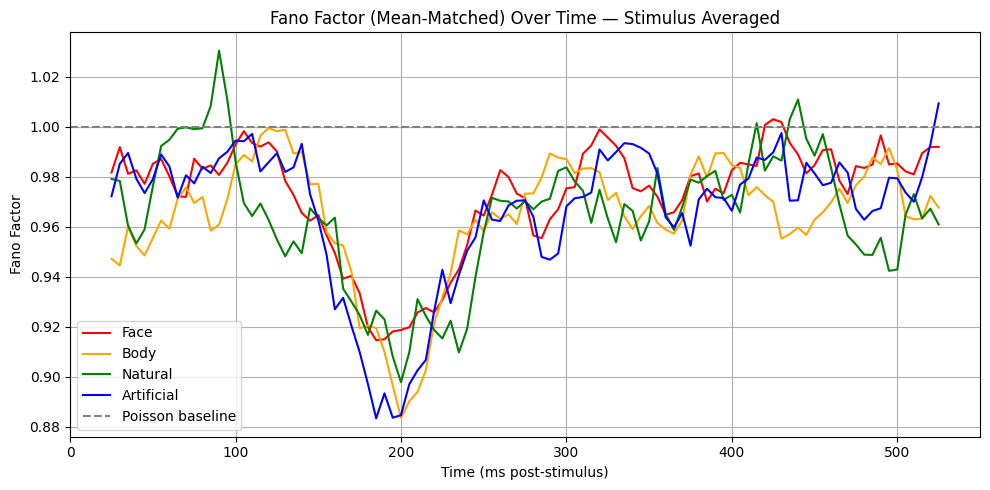

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
win_len = 50    # window length in ms/bins
step    = 5     # step size in ms/bins
n_neurons = len(raster_all)
n_time    = raster_all[0].shape[1]
n_slices  = 1 + (n_time - win_len) // step

# --- Step 1: Create stimulus-averaged raster: [n_neurons x n_stimuli x time] ---
trial_stim = cm_all[0]                      # shape: (5000,) — stimulus index per trial
stim_ids   = np.unique(trial_stim)          # should be 500 unique IDs
n_stim     = len(stim_ids)

raster_stim = np.zeros((n_neurons, n_stim, n_time), dtype=int)
for ni in range(n_neurons):
    for i, sid in enumerate(stim_ids):
        trials = np.where(trial_stim == sid)[0]
        raster_stim[ni, i, :] = raster_all[ni][trials, :].sum(axis=0)

# --- Step 2: Sliding window spike counts: [n_neurons x n_stimuli x n_slices] ---
counts = np.zeros((n_neurons, n_stim, n_slices), dtype=int)
for s in range(n_slices):
    start = s * step
    end   = start + win_len
    counts[:, :, s] = raster_stim[:, :, start:end].sum(axis=2)

# --- Step 3: Category labels per stimulus ---
StmLabels_full = np.zeros(n_stim, dtype=int)
StmLabels_full[(stim_ids >= 1)   & (stim_ids <= 200)] = 0  # Face
StmLabels_full[(stim_ids >= 201) & (stim_ids <= 320)] = 1  # Body
StmLabels_full[(stim_ids >= 321) & (stim_ids <= 390)] = 2  # Natural
StmLabels_full[(stim_ids >= 391) & (stim_ids <= 501)] = 3  # Artificial

# --- Step 4: Fano Factor computation ---
fano = np.zeros((4, n_slices))  # [category x time]
for c in range(4):
    idx = np.where(StmLabels_full == c)[0]
    for s in range(n_slices):
        data = counts[:, idx, s]  # [neurons x stimuli in category]
        var = np.var(data, axis=1)
        mean = np.mean(data, axis=1)
        ff = np.divide(var, mean, out=np.zeros_like(var, dtype=float), where=mean > 0)
        fano[c, s] = np.nanmean(ff)  # average over neurons

# --- Step 5: Plotting ---
times = np.arange(n_slices) * step + (win_len / 2)
labels = ['Face', 'Body', 'Natural', 'Artificial']
colors = ['red', 'orange', 'green', 'blue']

plt.figure(figsize=(10, 5))
for c in range(4):
    plt.plot(times, fano[c], label=labels[c], color=colors[c])
plt.axhline(1.0, linestyle='--', color='gray', label='Poisson baseline')
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('Fano Factor')
plt.title('Fano Factor (Mean-Matched) Over Time — Stimulus Averaged')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


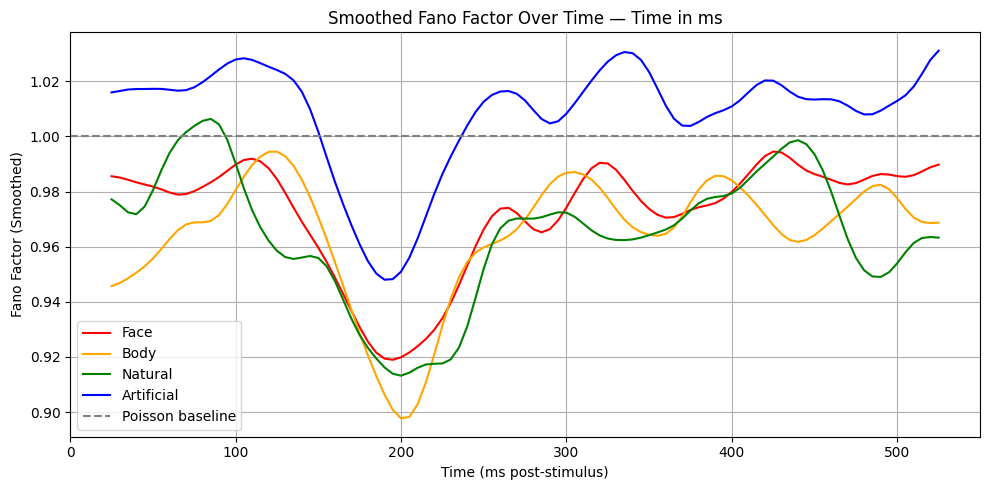

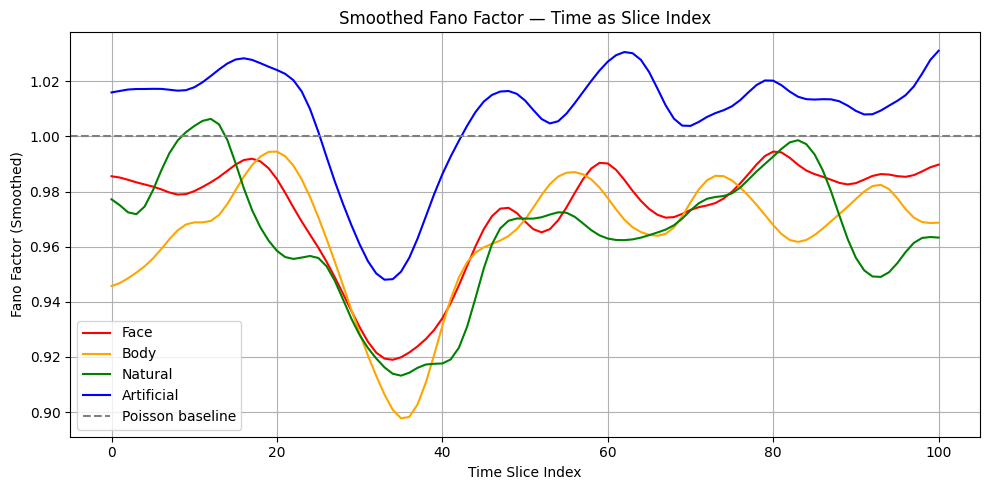

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

# --- Parameters ---
win_len = 50    # window length in ms/bins
step    = 5     # step size in ms/bins
n_neurons = len(raster_all)
n_time    = raster_all[0].shape[1]
n_slices  = 1 + (n_time - win_len) // step

# --- Step 1: Create stimulus-averaged raster: [n_neurons x n_stimuli x time] ---
trial_stim = cm_all[0]
stim_ids   = np.unique(trial_stim)
n_stim     = len(stim_ids) + 1

raster_stim = np.zeros((n_neurons, n_stim, n_time), dtype=int)
for ni in range(n_neurons):
    for i, sid in enumerate(stim_ids):
        trials = np.where(trial_stim == sid)[0]
        raster_stim[ni, i, :] = raster_all[ni][trials, :].sum(axis=0)

# --- Step 2: Sliding window spike counts: [n_neurons x n_stimuli x n_slices] ---
counts = np.zeros((n_neurons, n_stim, n_slices), dtype=int)
for s in range(n_slices):
    start = s * step
    end   = start + win_len
    counts[:, :, s] = raster_stim[:, :, start:end].sum(axis=2)

# --- Step 3: Category labels per stimulus ---
StmLabels_full = np.zeros(n_stim, dtype=int)
StmLabels_full[1:201]   = 0  # Face
StmLabels_full[201:321] = 1  # Body
StmLabels_full[321:391] = 2  # Natural
StmLabels_full[391:501] = 3  # Artificial

# --- Step 4: Fano Factor computation ---
fano = np.zeros((4, n_slices))  # [category x time]
for c in range(4):
    idx = np.where(StmLabels_full == c)[0]
    for s in range(n_slices):
        data = counts[:, idx, s]  # [neurons x stimuli]
        var = np.var(data, axis=1)
        mean = np.mean(data, axis=1)
        ff = np.divide(var, mean, out=np.zeros_like(var, dtype=float), where=mean > 0)
        fano[c, s] = np.nanmean(ff)

# --- Step 5: Smooth the Fano curves ---
fano_smooth = scipy.ndimage.gaussian_filter1d(fano, sigma=2, axis=1)

# --- Step 6: Plotting ---
times = np.arange(n_slices) * step + win_len / 2
labels = ['Face', 'Body', 'Natural', 'Artificial']
colors = ['red', 'orange', 'green', 'blue']

# Plot 1: Time in ms
plt.figure(figsize=(10, 5))
for c in range(4):
    plt.plot(times, fano_smooth[c], label=labels[c], color=colors[c])
plt.axhline(1.0, linestyle='--', color='gray', label='Poisson baseline')
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('Fano Factor (Smoothed)')
plt.title('Smoothed Fano Factor Over Time — Time in ms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Slice index
plt.figure(figsize=(10, 5))
for c in range(4):
    plt.plot(np.arange(n_slices), fano_smooth[c], label=labels[c], color=colors[c])
plt.axhline(1.0, linestyle='--', color='gray', label='Poisson baseline')
plt.xlabel('Time Slice Index')
plt.ylabel('Fano Factor (Smoothed)')
plt.title('Smoothed Fano Factor — Time as Slice Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### SVM

In [3]:
def multiclass_svm_psth(raster_all, cm_all, StmLabels, win_len=50, step=5, rate=0.7, n_rep=5):
    """
    Four-class SVM decoding on stimulus-averaged PSTH features.

    raster_all: list of (n_trials, n_time) arrays for each neuron
    cm_all:     list of (n_trials,) arrays of stimulus IDs (1–500) for each neuron
    StmLabels:  array mapping stimulus ID -> category (0–3)
    win_len:    window length in ms
    step:       step size in ms
    rate:       train/test split ratio per class
    n_rep:      number of repetitions for cross-validation
    """
    n_neurons = len(raster_all)
    n_time    = raster_all[0].shape[1]
    n_slices  = 1 + (n_time - win_len) // step

    # Build stimulus→trial mapping once
    trial_stim = cm_all[0]
    unique_stims = np.unique(trial_stim)
    stim_to_trials = {sid: np.where(trial_stim == sid)[0] for sid in unique_stims}

    stim_ids    = np.sort(unique_stims)
    stim_labels = StmLabels[stim_ids]

    accuracies = np.zeros(n_slices)

    for s in tqdm(range(n_slices), desc="Decoding windows"):
        start = s * step
        end   = start + win_len

        # Build feature matrix: (500 stimuli × 92 neurons)
        X = np.zeros((len(stim_ids), n_neurons), dtype=float)
        y = stim_labels.copy()

        for i, sid in enumerate(stim_ids):
            trials = stim_to_trials[sid]
            for ni in range(n_neurons):
                counts = raster_all[ni][trials, start:end].sum(axis=1)
                X[i, ni] = counts.sum()

        # Multiclass SVM decoding
        X.shape()
        out, _ = gen_fx_get_svm(y, X, rate=rate, rep=n_rep)
        accuracies[s] = out['pt'].mean()

    # Plot
    times = np.arange(n_slices) * step + (win_len//2)
    plt.figure(figsize=(8,4))
    plt.plot(times, accuracies, label='4-class accuracy', linewidth=2)
    plt.axhline(0.25, linestyle='--', color='gray', label='Chance (25%)')
    plt.xlabel('Time (ms post-stimulus)')
    plt.ylabel('Accuracy')
    plt.title('Multiclass Decoding: 500 stimuli × 92 neurons')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return accuracies


In [ ]:
accs = multiclass_svm_psth(raster_all, cm_all, StmLabels,
                           win_len=50, step=5, rate=0.7, n_rep=10)


Decoding windows:   0%|          | 0/101 [00:01<?, ?it/s]


TypeError: 'tuple' object is not callable

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def multiclass_svm_psth(raster_all, cm_all, StmLabels,
                        win_len=50, step=5, rate=0.7, n_rep=10):
    """
    Four-class SVM decoding on stimulus-averaged PSTH features.

    Parameters:
    - raster_all: list of (n_trials, n_time) arrays for each neuron
    - cm_all:     list of (n_trials,) arrays of stimulus IDs (1–500) for each neuron
    - StmLabels:  array mapping stimulus ID -> category (0–3)
    - win_len:    window length in ms/bins (e.g. 50)
    - step:       step size in ms/bins (e.g. 5)
    - rate:       train/test split ratio per class (e.g. 0.7)
    - n_rep:      number of repetitions for cross-validation

    Returns:
    - accuracies: 1D array of length n_slices with decoding accuracy per time window
    """
    n_neurons = len(raster_all)
    n_time    = raster_all[0].shape[1]
    n_slices  = 1 + (n_time - win_len) // step

    # Precompute trial→stimulus map and category labels
    trial_stim   = cm_all[0]                  # (5000,)
    stim_ids     = np.unique(trial_stim)      # e.g. [1,2,...,500]
    stim_to_cat  = StmLabels[stim_ids]        # (500,) labels 0–3
    stim_to_trials = {sid: np.where(trial_stim == sid)[0] for sid in stim_ids}

    # storage for accuracy
    accuracies = np.zeros(n_slices)

    for s in tqdm(range(n_slices), desc="Decoding windows"):
        start = s * step
        end   = start + win_len

        # Build feature matrix: stimuli × neurons
        X = np.zeros((len(stim_ids), n_neurons), dtype=float)
        y = stim_to_cat.copy()

        for i, sid in enumerate(stim_ids):
            trials = stim_to_trials[sid]
            # count spikes per neuron by summing window across all repeats
            # then average across repeats (or sum)
            for ni in range(n_neurons):
                counts_per_repeat = raster_all[ni][trials, start:end].sum(axis=1)
                X[i, ni] = counts_per_repeat.mean()  # average firing in window

        # Run balanced, multiclass SVM
        out, _ = gen_fx_get_svm(y, X, rate=rate, rep=n_rep)
        accuracies[s] = out['pt'].mean()

    # Plot
    times = np.arange(n_slices) * step + (win_len/2)
    plt.figure(figsize=(8,4))
    plt.plot(times, accuracies * 100, label='4-class accuracy', linewidth=2)
    plt.axhline(25, linestyle='--', color='gray', label='Chance (25%)')
    plt.xlabel('Time (ms post-stimulus)')
    plt.ylabel('Accuracy (%)')
    plt.title('Multiclass SVM Decoding (500 stimuli × 92 neurons)')
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return accuracies

# Example usage:
#

Decoding windows: 100%|██████████| 101/101 [02:18<00:00,  1.37s/it]


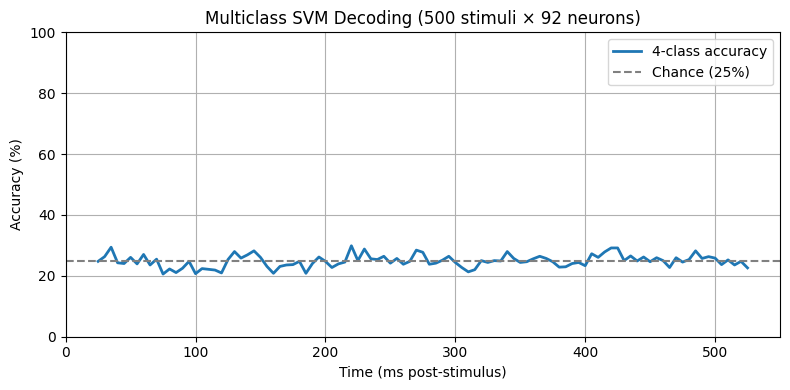

In [ ]:
accuracies = multiclass_svm_psth(raster_all, cm_all, StmLabels,
                                 win_len=50, step=5, rate=0.7, n_rep=10)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def multiclass_svm_psth_signif(raster_all, cm_all, StmLabels,
                               win_len=50, step=5, rate=0.7, n_rep=10,
                               n_perm=200, alpha=0.05):
    """
    4-way SVM decoding on stimulus-averaged PSTHs with significance testing.

    Returns:
      times        : array of time-centers (ms)
      accs         : decoding accuracy per slice
      pvals        : p-value per slice vs chance
      sig_mask     : boolean mask of pval<alpha
    """

    n_neurons = len(raster_all)
    n_time    = raster_all[0].shape[1]
    n_slices  = 1 + (n_time - win_len)//step

    # 1) Stimulus→trial and label maps
    trial_stim    = cm_all[0]                    # (5000,)
    stim_ids      = np.unique(trial_stim)        # [1..500]
    n_stim        = len(stim_ids)
    stim_to_trials= {sid: np.where(trial_stim==sid)[0] for sid in stim_ids}
    stim_labels   = StmLabels[stim_ids]          # (500,) in {0,1,2,3}

    # storage
    accs  = np.zeros(n_slices)
    pvals = np.ones(n_slices)

    for s in tqdm(range(n_slices), desc="Decoding windows"):
        start = s*step
        end   = start+win_len

        # 2) Build feature matrix X (500×92) and labels y (500,)
        X = np.zeros((n_stim, n_neurons))
        y = stim_labels.copy()
        for i,sid in enumerate(stim_ids):
            trials = stim_to_trials[sid]
            # get counts per repeat then average
            mat = np.array([raster_all[n][trials, start:end].sum(axis=1)
                            for n in range(n_neurons)])  # (92,10)
            X[i] = mat.mean(axis=1)

        # 3) Balanced one‐vs‐one SVM over n_rep
        #    Use your provided functions:
        accuracies = []
        for _ in range(n_rep):
            test, train = gen_fx_get_equal_part(y, rate)
            cls,_      = gen_fx_MC_SVM(X[test], X[train], y[train])
            acc        = (cls==y[test]).mean()
            accuracies.append(acc)
        accs[s] = np.mean(accuracies)

        # 4) Permutation test for significance
        null_accs = []
        for _ in range(n_perm):
            y_perm = np.random.permutation(y)
            perm_acc = []
            for __ in range(5):  # fewer reps for speed
                test, train = gen_fx_get_equal_part(y_perm, rate)
                cls,_      = gen_fx_MC_SVM(X[test], X[train], y_perm[train])
                perm_acc.append((cls==y_perm[test]).mean())
            null_accs.append(np.mean(perm_acc))
        pvals[s] = (np.sum(np.array(null_accs) >= accs[s]) + 1)/(n_perm+1)

    # 5) Plot
    times = np.arange(n_slices)*step + win_len/2
    sig   = pvals<alpha

    plt.figure(figsize=(10,4))
    plt.plot(times, accs*100, 'k-', label='Accuracy')
    # bold significant points
    plt.plot(times[sig], accs[sig]*100, 'ro', label='p<0.05')
    plt.axhline(25, linestyle='--', color='gray', label='Chance (25%)')
    plt.xlabel('Time (ms post-stimulus)')
    plt.ylabel('Accuracy (%)')
    plt.title('4-class Decoding with Significance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return times, accs, pvals, sig

# Example usage:



Decoding windows: 100%|██████████| 101/101 [1:10:23<00:00, 41.81s/it]


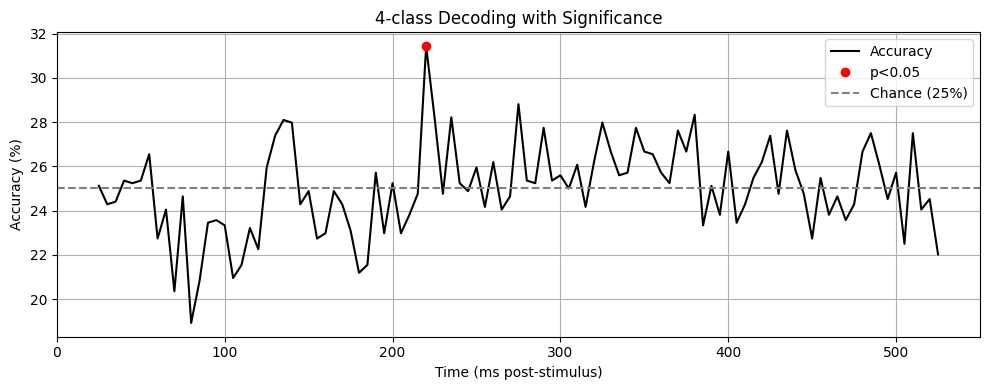

In [ ]:
times, accs, pvals, sig = multiclass_svm_psth_signif(raster_all, cm_all, StmLabels)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def time_time_decoding(raster_all, cm_all, StmLabels,
                       win_len=50, step=5,
                       rate=0.7, n_rep=10,
                       n_perm=100, alpha=0.05):
    """
    Time×Time SVM decoding with permutation testing and Bonferroni correction.

    Returns:
      times        : center times of each slice (ms)
      acc_matrix   : [n_slices × n_slices] decoding accuracy
      p_matrix     : [n_slices × n_slices] uncorrected p-values
      sig_matrix   : boolean mask of significance after Bonferroni
    """
    n_neurons = len(raster_all)
    n_time    = raster_all[0].shape[1]
    n_slices  = 1 + (n_time - win_len)//step

    # Prepare stimulus→trials and labels
    trial_stim    = cm_all[0]
    stim_ids      = np.unique(trial_stim)
    stim_to_cat   = StmLabels[stim_ids]
    stim_to_trials= {sid: np.where(trial_stim==sid)[0] for sid in stim_ids}
    n_stim        = len(stim_ids)

    # Precompute feature arrays: counts[neuron,stimulus,slice]
    counts = np.zeros((n_neurons, n_stim, n_slices), dtype=float)
    for s in range(n_slices):
        st, en = s*step, s*step+win_len
        for ni in range(n_neurons):
            # sum spikes in window for each trial, then average over repeats
            arr = np.array([raster_all[ni][stim_to_trials[sid], st:en].sum(axis=1)
                             for sid in stim_ids])  # shape: (n_stim,10)
            counts[ni,:,s] = arr.mean(axis=1)

    # Initialize matrices
    acc_matrix = np.zeros((n_slices, n_slices))
    p_matrix   = np.ones ((n_slices, n_slices))

    # For each train slice i, test slice j
    for i in tqdm(range(n_slices), desc="Time–Time Decoding"):
        X_train = counts[:,:,i].T  # (500,92)
        y       = stim_to_cat

        # Pre-generate splits for stability
        splits = [gen_fx_get_equal_part(y, rate) for _ in range(n_rep)]

        # For each repetition, train once and predict on all slices
        # We will gather rep × slices predictions
        preds = np.zeros((n_rep, n_slices, n_stim), dtype=int)
        for r, (test_idx, train_idx) in enumerate(splits):
            cls_train, model = gen_fx_MC_SVM(X_train[test_idx], X_train[train_idx], y[train_idx])
            # But we want to predict on all slices
            for j in range(n_slices):
                X_test = counts[:,:,j].T  # same stimuli × features
                preds[r,j,:] = model.predict(X_test)

        # Compute observed accuracy matrix for this train i
        for j in range(n_slices):
            accs = [(preds[r,j,test_idx] == y[test_idx]).mean() for r,(test_idx,_) in enumerate(splits)]
            acc_matrix[i,j] = np.mean(accs)

        # Permutation testing for this row i
        null_accs = np.zeros((n_perm, n_slices))
        for p in range(n_perm):
            y_perm = np.random.permutation(y)
            # shuffle labels and repeat one split
            test_idx, train_idx = gen_fx_get_equal_part(y_perm, rate)
            # train on permuted labels
            cls_t, model = gen_fx_MC_SVM(X_train[test_idx], X_train[train_idx], y_perm[train_idx])
            for j in range(n_slices):
                X_test = counts[:,:,j].T
                cls_p = model.predict(X_test)
                null_accs[p,j] = (cls_p[test_idx] == y_perm[test_idx]).mean()

        # p-values: fraction of null >= observed
        for j in range(n_slices):
            p_matrix[i,j] = (np.sum(null_accs[:,j] >= acc_matrix[i,j]) + 1) / (n_perm+1)

    # Bonferroni correction
    m = n_slices*n_slices
    sig_matrix = (p_matrix * m) < alpha

    # Plot accuracy matrix
    times = np.arange(n_slices)*step + win_len/2
    plt.figure(figsize=(6,5))
    im = plt.imshow(acc_matrix*100, origin='lower',
                    extent=[times[0], times[-1], times[0], times[-1]],
                    vmin=0, vmax=100, cmap='viridis')
    plt.colorbar(im, label='Accuracy (%)')
    plt.contour(times, times, sig_matrix, levels=[0.5], colors='red', linewidths=0.5)
    plt.plot(times, times, 'w--')  # diagonal
    plt.xlabel('Test time (ms)')
    plt.ylabel('Train time (ms)')
    plt.title('Time–Time Decoding Accuracy\nred contours: p < 0.05 (Bonferroni)')
    plt.tight_layout()
    plt.show()

    return times, acc_matrix, p_matrix, sig_matrix



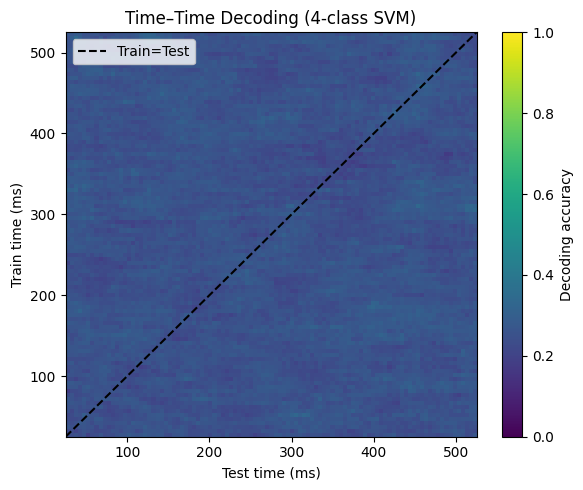

In [ ]:

# Parameters
win_len = 50
step    = 5
rate    = 0.7
n_rep   = 5
n_neurons = len(raster_all)
n_time    = raster_all[0].shape[1]
n_slices  = 1 + (n_time - win_len) // step

trial_stim = cm_all[0]
stim_ids   = np.sort(np.unique(trial_stim))
stim_to_trials = {sid: np.where(trial_stim == sid)[0] for sid in stim_ids}
n_stim = len(stim_ids)

Xstim = np.zeros((n_stim, n_neurons, n_slices), dtype=float)
for i, sid in enumerate(stim_ids):
    trials = stim_to_trials[sid]
    for s in range(n_slices):
        start = s * step
        end   = start + win_len
        # sum over repeats then over time within window
        for ni in range(n_neurons):
            counts = raster_all[ni][trials, start:end].sum(axis=1)
            Xstim[i, ni, s] = counts.sum()

grp = StmLabels[stim_ids]

dec_matrix = np.zeros((n_slices, n_slices))

for rep in range(n_rep):
    test_mask, train_mask = gen_fx_get_equal_part(grp, rate)

    for t_train in range(n_slices):
        X_train = Xstim[:, :, t_train]
        y_train = grp

        clf = OneVsOneClassifier(SVC(kernel='linear'))
        clf.fit(X_train[train_mask], y_train[train_mask])

        for t_test in range(n_slices):
            X_test = Xstim[:, :, t_test]
            y_pred = clf.predict(X_test[test_mask])
            acc = np.mean(y_pred == y_train[test_mask])
            dec_matrix[t_train, t_test] += acc

dec_matrix /= n_rep

times = np.arange(n_slices) * step + (win_len // 2)

plt.figure(figsize=(6,5))
plt.imshow(dec_matrix, origin='lower',
           extent=[times[0], times[-1], times[0], times[-1]],
           aspect='auto', vmin=0.2, vmax=0.4, cmap='viridis')
plt.colorbar(label='Decoding accuracy')
plt.plot([times[0], times[-1]], [times[0], times[-1]], 'k--', label='Train=Test')
plt.xlabel('Test time (ms)')
plt.ylabel('Train time (ms)')
plt.title('Time–Time Decoding (4‐class SVM)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


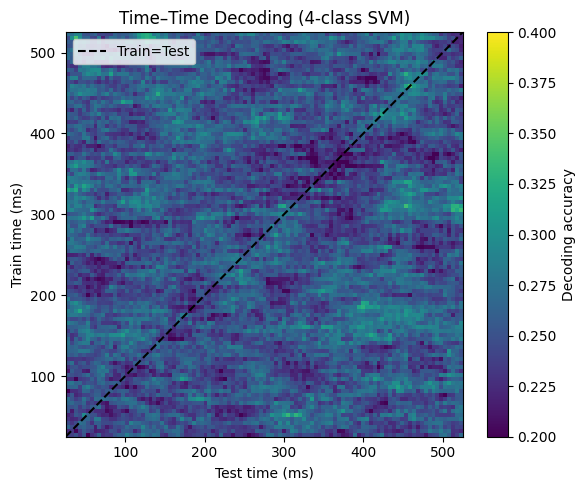

In [ ]:

plt.figure(figsize=(6,5))
plt.imshow(dec_matrix, origin='lower',
           extent=[times[0], times[-1], times[0], times[-1]],
           aspect='auto', vmin=0.2, vmax=0.4, cmap='viridis')
plt.colorbar(label='Decoding accuracy')
plt.plot([times[0], times[-1]], [times[0], times[-1]], 'k--', label='Train=Test')
plt.xlabel('Test time (ms)')
plt.ylabel('Train time (ms)')
plt.title('Time–Time Decoding (4‐class SVM)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

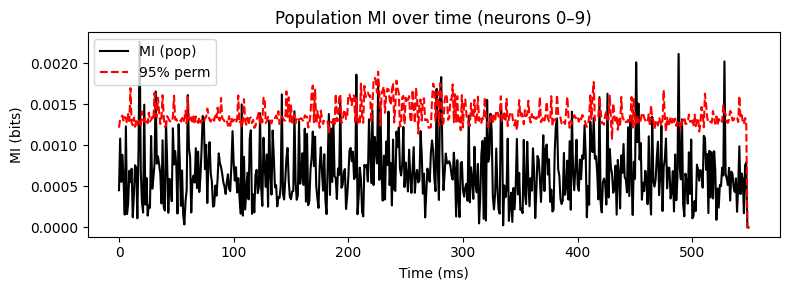

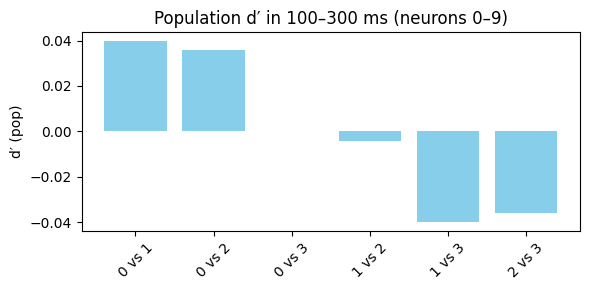

Population d-primes (neurons 0–9):
  Category 0 vs 1: d′ = 0.040
  Category 0 vs 2: d′ = 0.036
  Category 0 vs 3: d′ = 0.000
  Category 1 vs 2: d′ = -0.004
  Category 1 vs 3: d′ = -0.040
  Category 2 vs 3: d′ = -0.036


In [ ]:
from sklearn.metrics import mutual_info_score

# ---- Parameters ----
neuron_group = list(range(60,65))   # use neurons 0–9 as an example
n_time = raster_all[0].shape[1]
n_trials = raster_all[0].shape[0]

# Time window for d-prime
dp_start, dp_end = 100, 300      # ms-bins for d′
dp_slice = slice(dp_start, dp_end)

# 1) Build population spike count matrix: shape (n_trials, n_time)
#    by summing spike counts across the selected neurons at each time bin
pop_counts = np.zeros((n_trials, n_time), dtype=float)
for ni in neuron_group:
    pop_counts += raster_all[ni]

# 2) Mutual Information over time
labels = StmLabels[cm_all[0]]    # (n_trials,)

mi_ts = np.zeros(n_time)
null_thr = np.zeros(n_time)
n_perm = 500

for t in range(n_time):
    x = pop_counts[:, t]
    # discretize x into e.g. 20 bins
    bins = np.histogram_bin_edges(x, bins=20)
    x_bin = np.digitize(x, bins) - 1

    # compute observed MI
    mi_ts[t] = mutual_info_score(labels, x_bin)

    # permutation null
    mi_perm = np.zeros(n_perm)
    for k in range(n_perm):
        mi_perm[k] = mutual_info_score(np.random.permutation(labels), x_bin)
    null_thr[t] = np.percentile(mi_perm, 95)

# Plot MI
times = np.arange(n_time)
sig = mi_ts > null_thr

plt.figure(figsize=(8,3))
plt.plot(times, mi_ts, 'k', label='MI (pop)')
plt.plot(times, null_thr, 'r--', label='95% perm')
plt.fill_between(times, mi_ts, null_thr, where=sig, color='red', alpha=0.3)
plt.xlabel('Time (ms)')
plt.ylabel('MI (bits)')
plt.title('Population MI over time (neurons 0–9)')
plt.legend()
plt.tight_layout()
plt.show()

# 3) d-prime for each pair, using summed counts in [100:300] ms
pop_counts_window = pop_counts[:, dp_slice].sum(axis=1)  # (n_trials,)

# compute per-category vectors
cat_resps = {cat: pop_counts_window[labels==cat] for cat in range(4)}

from itertools import combinations

dprimes = {}
for (c1,c2) in combinations(range(4),2):
    x1 = cat_resps[c1]
    x2 = cat_resps[c2]
    mu1, mu2 = x1.mean(), x2.mean()
    s1, s2 = x1.std(), x2.std()
    d = (mu1 - mu2) / np.sqrt(0.5*(s1**2 + s2**2))
    dprimes[(c1,c2)] = d

# Bar plot of d-prime
pairs = list(dprimes.keys())
vals  = [dprimes[p] for p in pairs]
labels_pairs = [f"{p[0]} vs {p[1]}" for p in pairs]

plt.figure(figsize=(6,3))
plt.bar(range(len(vals)), vals, color='skyblue')
plt.xticks(range(len(vals)), labels_pairs, rotation=45)
plt.ylabel("d′ (pop)")
plt.title("Population d′ in 100–300 ms (neurons 0–9)")
plt.tight_layout()
plt.show()

# Print results
print("Population d-primes (neurons 0–9):")
for p,v in dprimes.items():
    print(f"  Category {p[0]} vs {p[1]}: d′ = {v:.3f}")


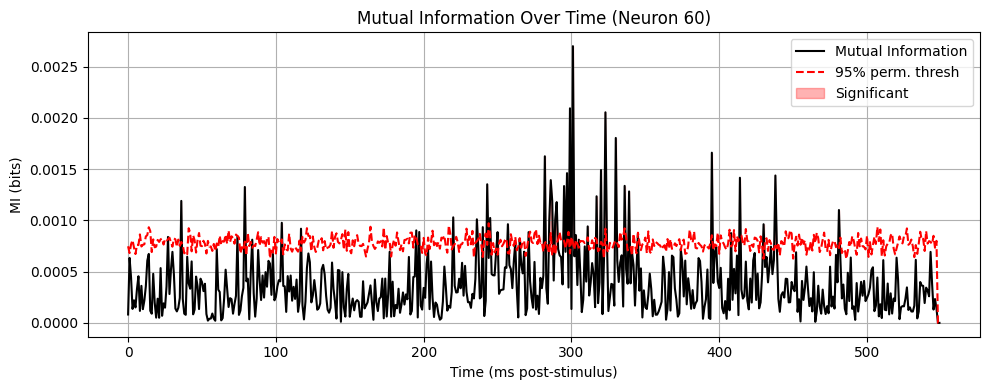

In [ ]:

trial_cats = StmLabels[pic_nums]

n_trials, n_time = raster0.shape

mi_time = np.zeros(n_time)
for t in range(n_time):
    counts_t = raster0[:, t]  # spike count per trial at time t (0 or 1)
    mi_time[t] = mutual_info_score(trial_cats, counts_t)

n_perm = 200
mi_perm = np.zeros((n_perm, n_time))

for i in range(n_perm):
    shuffled = np.random.permutation(trial_cats)
    for t in range(n_time):
        counts_t = raster0[:, t]
        mi_perm[i, t] = mutual_info_score(shuffled, counts_t)

mi_thresh = np.percentile(mi_perm, 95, axis=0)

time_ms = np.arange(n_time)  # 0…549 ms

plt.figure(figsize=(10,4))
plt.plot(time_ms, mi_time, label='Mutual Information', color='k')
plt.plot(time_ms, mi_thresh, '--', label='95% perm. thresh', color='r')
plt.fill_between(time_ms, mi_time, mi_thresh, where=(mi_time>mi_thresh),
                 color='r', alpha=0.3, label='Significant')

plt.xlabel('Time (ms post‐stimulus)')
plt.ylabel('MI (bits)')
plt.title('Mutual Information Over Time (Neuron 60)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


d′(Face vs Body) = 0.056
d′(Face vs Natural) = 0.014
d′(Face vs Artificial) = 0.092
d′(Body vs Natural) = -0.042
d′(Body vs Artificial) = 0.036
d′(Natural vs Artificial) = 0.078


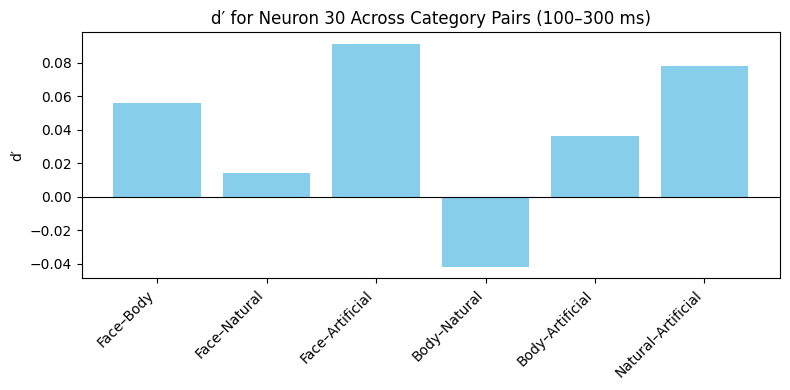

In [ ]:
start_ms, end_ms = 100, 300
counts = raster0[:, start_ms:end_ms].sum(axis=1)
trial_cats = StmLabels[pic_nums]

pairs = list(combinations(range(4), 2))
dprimes = []
labels = ['Face','Body','Natural','Artificial']

for (c1, c2) in pairs:
    x1 = counts[trial_cats == c1]
    x2 = counts[trial_cats == c2]
    mu1, mu2 = x1.mean(), x2.mean()
    s1, s2   = x1.std(ddof=1), x2.std(ddof=1)
    s_pooled = np.sqrt(0.5*(s1**2 + s2**2))
    # d-prime
    dp = (mu1 - mu2) / s_pooled if s_pooled>0 else np.nan
    dprimes.append(dp)
    print(f"d′({labels[c1]} vs {labels[c2]}) = {dp:.3f}")

x = np.arange(len(pairs))
pair_labels = [f"{labels[c1]}–{labels[c2]}" for c1,c2 in pairs]

plt.figure(figsize=(8,4))
plt.bar(x, dprimes, color='skyblue')
plt.xticks(x, pair_labels, rotation=45, ha='right')
plt.ylabel("d′")
plt.title("d′ for Neuron 30 Across Category Pairs (100–300 ms)")
plt.axhline(0, color='k', linewidth=0.8)
plt.tight_layout()
plt.show()


## Population analysis

In [ ]:
StmLabels_ordered = StmLabels[stim_ids]  # maps correctly to raster_stim second axis


Number of time points: 550
Window size: 50 ms
Step size: 5 ms
Number of windows: 101

Preparing data for RDM analysis (mean spike counts per stimulus per neuron per window)...
RDM data preparation complete. Shape: (500, 92, 101)

Computing neural RDMs over windows...
Neural RDM computation complete.

Ground-truth RDM built.

Computing Kendall's tau over windows...
Kendall's tau computation complete.


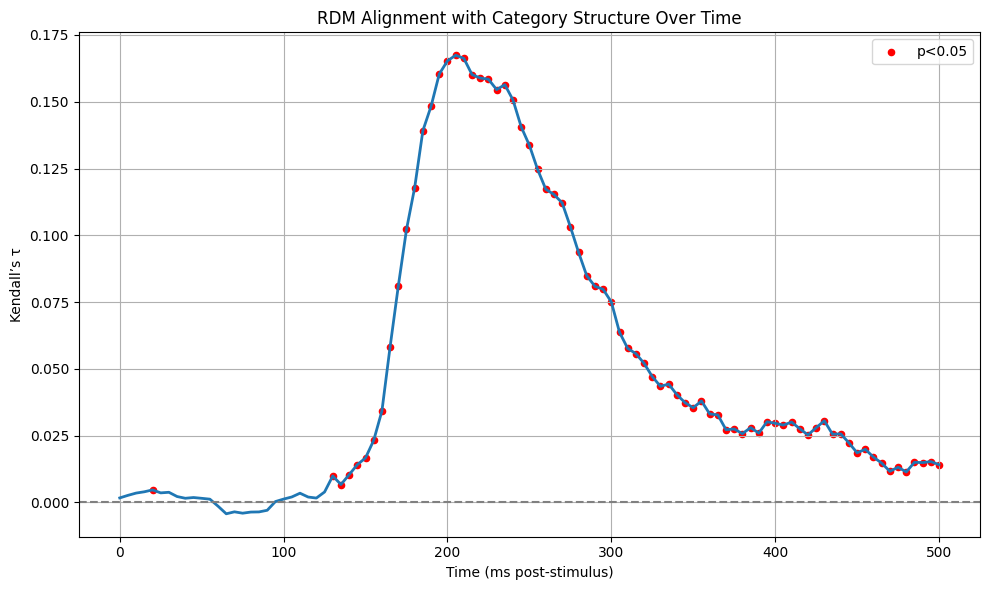


RDM analysis and plotting complete. Plot saved as PDF file.


In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.io import savemat
import pandas as pd # Needed for categorizing stimuli

# --- Assume you already have loaded data and defined parameters ---
# This part is carried over from the previous script to ensure necessary variables are available.

# Define functions to read data from the .mat file
def dereference(data, file):
    """Dereferences HDF5 object references within the dataset."""
    return np.vectorize(lambda ref: read_matlab_file(file[ref], file), otypes=[object])(data)

def read_matlab_file(file_obj, file):
    """Recursively reads data from HDF5 file objects (Dataset or Group)."""
    if isinstance(file_obj, h5py.Dataset):
        data = file_obj[()].squeeze()
        if data.dtype == h5py.ref_dtype:
            data = dereference(data, file)
    elif isinstance(file_obj, h5py.Group):
        data = {}
        for subvar in file_obj.keys():
            data[subvar] = read_matlab_file(file_obj[subvar], file)
    else:
        data = file_obj
    return data

# Load data from the .mat file
# Ensure 'dataVasati.mat' is in the same directory or provide the full path
try:
    with h5py.File('/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat', 'r') as file:
        dataVasati = read_matlab_file(file['SpikeTrain_it_all'], file)
        data_raw = dataVasati['data'] # Use a different name to keep original time points
        cm = dataVasati['cm']
except FileNotFoundError:
    print("Error: 'dataVasati.mat' not found. Please ensure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the .mat file: {e}")
    exit()

# Transpose each trial's data for each neuron to have shape (trials, time_points)
data_raw = np.vectorize(lambda arr: arr.T, otypes=[object])(data_raw)

# Define parameters
sampling_rate = 1000 # Hz
n_neurons = data_raw.size
time_points = data_raw[0].shape[1] # Assuming all neurons have the same number of time points

# Define stimulus categories and their index ranges
categories = {
    "face": (1, 200),
    "body": (201, 320),
    "natural": (321, 390),
    "artificial": (391, 500)
}
n_stimuli = 500 # Total number of stimuli
n_classes = len(categories) # Number of stimulus categories

# Assign numerical labels (0, 1, 2, 3) to each stimulus based on categories
# This is needed for the ground truth RDM
StmLabels_ordered = np.zeros(n_stimuli, dtype=int)
for label, (start, end) in enumerate(categories.values()):
    StmLabels_ordered[start-1:end] = label


# --- Sliding Window Parameters (consistent with previous sections) ---
window_size = 50 # ms
step_size = 5 # ms
n_windows = (time_points - window_size) // step_size + 1

print(f"Number of time points: {time_points}")
print(f"Window size: {window_size} ms")
print(f"Step size: {step_size} ms")
print(f"Number of windows: {n_windows}")


# --- Prepare Data for RDM: Mean Spike Count per Stimulus per Neuron per Window ---
# This is similar to the SVM data preparation but for RDM analysis.
# Shape: (n_stimuli, n_neurons, n_windows)
all_windows_stim_data = np.zeros((n_stimuli, n_neurons, n_windows))

print("\nPreparing data for RDM analysis (mean spike counts per stimulus per neuron per window)...")
# Iterate through each neuron
for n in range(n_neurons):
    neuron_data_raw = data_raw[n] # Original spike train data for this neuron (trials, time_points)
    neuron_trial_stim_indices = cm[n]['index'].flatten() # Stimulus index for each trial of neuron n

    # Ensure indices are 0-based for bincount
    stim_indices_0based = neuron_trial_stim_indices.astype(int) - 1

    # Iterate through each window to calculate mean spike counts per stimulus
    for w in range(n_windows):
        # Calculate the start and end time point indices for the current window
        start = w * step_size
        end = start + window_size

        # Extract spike data for the current window across all trials of neuron n
        neuron_spike_data_window = neuron_data_raw[:, start:end] # (trials, window_size)

        # Sum spikes within the window for each trial
        spike_counts_window = np.sum(neuron_spike_data_window, axis=1) # (trials,)

        # Calculate sum of spike counts per stimulus for this neuron in this window
        sum_spike_counts_per_stim = np.bincount(stim_indices_0based, weights=spike_counts_window, minlength=n_stimuli)

        # Calculate number of trials per stimulus for this neuron
        trials_per_stim = np.bincount(stim_indices_0based, minlength=n_stimuli)

        # Calculate mean spike count per stimulus, handle division by zero
        mean_spike_counts_per_stim = np.divide(sum_spike_counts_per_stim, trials_per_stim, where=trials_per_stim != 0, out=np.zeros_like(sum_spike_counts_per_stim, dtype=float))

        # Store the mean spike counts for this neuron and window
        all_windows_stim_data[:, n, w] = mean_spike_counts_per_stim

print("RDM data preparation complete. Shape:", all_windows_stim_data.shape)


# --- 1) Compute neural RDMs over windows (1 − Pearson’s r) ---
# Shape: (n_stimuli, n_stimuli, n_windows)
RDM_neural = np.zeros((n_stimuli, n_stimuli, n_windows))

print("\nComputing neural RDMs over windows...")
for w in range(n_windows):
    # Get the mean spike counts for the current window across all stimuli and neurons
    X_window = all_windows_stim_data[:, :, w]# [n_stimuli x n_neurons]

    # Check if there is enough data (at least 2 stimuli and 2 neurons with non-zero variance)
    if X_window.shape[0] < 2 or X_window.shape[1] < 2 or np.all(X_window.std(axis=0) < 1e-12):
        print(f"Warning: Insufficient data for RDM calculation in window {w}. Filling with NaNs.")
        RDM_neural[:, :, w] = np.nan
        continue


    # Normalize each column (neuron) to zero mean / unit variance across stimuli
    # Add a small epsilon to std deviation to prevent division by zero for silent neurons
    std_dev = X_window.std(axis=0) + 1e-12
    X_normalized = (X_window - X_window.mean(axis=0)) / std_dev

    # Compute correlation matrix between stimuli (rows of X_normalized)
    # np.corrcoef computes the correlation coefficient matrix from rows
    corr = np.corrcoef(X_normalized)

    # Handle potential NaNs or Infs in correlation matrix (e.g., if a neuron has no variance)
    corr[np.isnan(corr)] = 0 # Replace NaN correlations with 0
    corr[np.isinf(corr)] = 0 # Replace Inf correlations with 0
    corr = np.clip(corr, -1, 1) # Clip values to be within [-1, 1]


    # Convert correlation to dissimilarity (1 - correlation)
    RDM_neural[:, :, w] = 1.0 - corr

print("Neural RDM computation complete.")


# --- 2) Build ground-truth RDM: same category = 0, different = 1 ---
# This RDM is based on stimulus categories and is constant across time.
RDM_truth = np.zeros((n_stimuli, n_stimuli))
for i in range(n_stimuli):
    for j in range(n_stimuli):
        # Assuming StmLabels_ordered contains the category label for each stimulus (0-based index)
        RDM_truth[i, j] = 0 if StmLabels_ordered[i] == StmLabels_ordered[j] else 1

print("\nGround-truth RDM built.")

# --- 3) Vectorize upper-triangles for correlation ---
# Get the indices for the upper triangle (excluding the diagonal)
triu_idx = np.triu_indices(n_stimuli, k=1)
# Extract the upper triangle values from the ground truth RDM
truth_vec = RDM_truth[triu_idx]

# --- 4) Compute Kendall’s tau over windows ---
tau_time = np.zeros(n_windows)
pval_time = np.zeros(n_windows)

print("\nComputing Kendall's tau over windows...")
for w in range(n_windows):
    # Extract the upper triangle values from the neural RDM for the current window
    neu_vec = RDM_neural[:, :, w][triu_idx]

    # Check for NaNs in the neural RDM vector for the current window
    if np.any(np.isnan(neu_vec)):
        print(f"Warning: NaNs found in neural RDM vector for window {w}. Kendall's tau will be NaN.")
        tau_time[w] = np.nan
        pval_time[w] = np.nan
        continue

    # Compute Kendall's tau correlation between the ground truth vector and the neural RDM vector
    # handle potential errors in kendalltau (e.g., if all values are the same)
    try:
        tau, p = kendalltau(truth_vec, neu_vec)
        tau_time[w] = tau
        pval_time[w] = p
    except ValueError as e:
        print(f"Warning: Could not compute Kendall's tau for window {w} due to ValueError: {e}. Data might be constant or contain issues.")
        tau_time[w] = np.nan
        pval_time[w] = np.nan
    except Exception as e:
        print(f"An unexpected error occurred during Kendall's tau calculation for window {w}: {e}")
        tau_time[w] = np.nan
        pval_time[w] = np.nan


print("Kendall's tau computation complete.")

# --- 5) Plot tau(t) ---
# Create a time axis for the windows. The time corresponds to the start of each window.
window_times = np.arange(n_windows) * step_size # Time in ms, corresponding to the start of each window

plt.figure(figsize=(10,6)) # Adjust figure size as needed
plt.plot(window_times, tau_time, linewidth=2)
plt.axhline(0, color='gray', linestyle='--') # Add line at tau = 0

# Mark significant time points (p<0.05). Only plot if p-values were computed.
if not np.all(np.isnan(pval_time)):
    # Apply a threshold (e.g., 0.05). Consider multiple comparison correction if needed.
    # For simplicity here, we'll just use p < 0.05 without correction as in the original code.
    sig_windows = np.where(pval_time < 0.05)[0]
    plt.scatter(window_times[sig_windows], tau_time[sig_windows], color='red', s=20, label='p<0.05') # Use s for marker size

plt.xlabel('Time (ms post-stimulus)')
plt.ylabel("Kendall’s τ")
plt.title('RDM Alignment with Category Structure Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('rdm_kendall_tau.pdf', bbox_inches='tight') # Save the figure
plt.show()

print("\nRDM analysis and plotting complete. Plot saved as PDF file.")


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


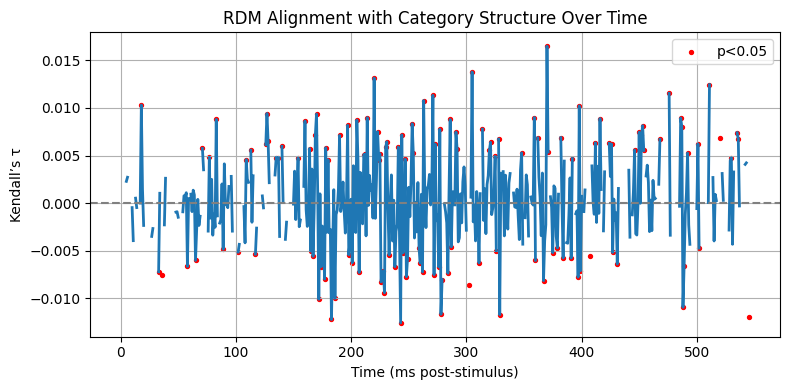

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.io import savemat

# --- Assume you already have: ---
# raster_stim: [n_neurons x n_stimuli x n_time]
# stim_ids:    (n_stimuli,) array of stimulus IDs (1–500)
# StmLabels_full: (n_stimuli,) array mapping each stimulus ID to category 0–3

# If not, build raster_stim as in previous code.

n_neurons, n_stimuli, n_time = raster_stim.shape

# --- 1) Compute neural RDMs over time (1 − Pearson’s r) ---
RDM_neural = np.zeros((n_stimuli, n_stimuli, n_time))
for t in range(n_time):
    X = raster_stim[:, :, t]  # [n_neurons x n_stimuli]
    # Normalize each column to zero mean / unit var to stabilize correlation
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-12)
    # Compute correlation matrix and convert to dissimilarity
    corr = np.corrcoef(X.T)            # [n_stimuli x n_stimuli]
    RDM_neural[:, :, t] = 1.0 - corr

# --- 2) Build ground‐truth RDM: same category = 0, different = 1 ---
RDM_truth = np.zeros((n_stimuli, n_stimuli))
for i in range(n_stimuli):
    for j in range(n_stimuli):
        RDM_truth[i, j] = 0 if StmLabels_ordered[i] == StmLabels_ordered[j] else 1


# --- 3) Vectorize upper‐triangles for correlation ---
triu_idx = np.triu_indices(n_stimuli, k=1)
truth_vec = RDM_truth[triu_idx]

# --- 4) Compute Kendall’s tau over time ---
tau_time = np.zeros(n_time)
pval_time = np.zeros(n_time)
for t in range(n_time):
    neu_vec = RDM_neural[:, :, t][triu_idx]
    tau, p = kendalltau(truth_vec, neu_vec)
    tau_time[t], pval_time[t] = tau, p

# --- 5) Plot tau(t) ---
times = np.arange(n_time)  # if each t is 1 ms; adjust if needed
plt.figure(figsize=(8,4))
plt.plot(times, tau_time, linewidth=2)
plt.axhline(0, color='gray', linestyle='--')
# Mark significant time points (p<0.05)
sig = pval_time < 0.05
plt.scatter(times[sig], tau_time[sig], color='red', s=8, label='p<0.05')
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel("Kendall’s τ")
plt.title('RDM Alignment with Category Structure Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



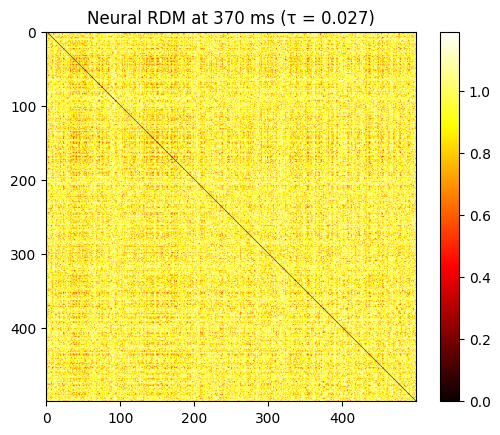

In [ ]:
plt.imshow(RDM_neural[:, :, peak_t], cmap='hot')
plt.title(f'Neural RDM at {peak_t} ms (τ = {tau_time[peak_t]:.3f})')
plt.colorbar()
plt.show()


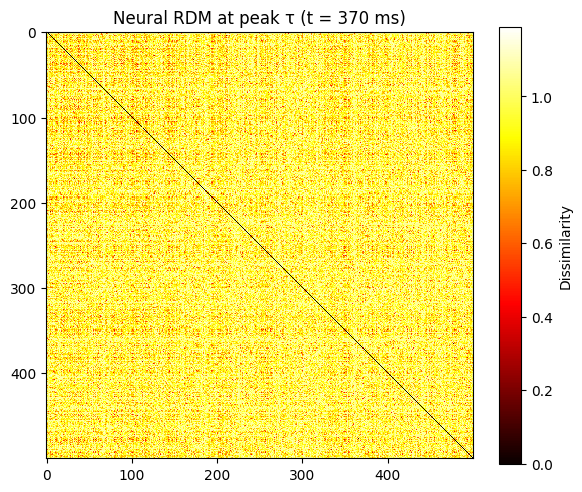

In [ ]:
peak_t = np.nanargmax(tau_time)
sort_idx = np.argsort(StmLabels_full)

plt.figure(figsize=(6, 5))
plt.imshow(RDM_neural[sort_idx][:, sort_idx, peak_t], cmap='hot', interpolation='nearest')
plt.title(f"Neural RDM at peak τ (t = {peak_t} ms)")
plt.colorbar(label='Dissimilarity')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_category_rdm_barplot(RDM, StmLabels_full, tau_time):
    # --- 1. Find peak tau time ---
    peak_slice = np.nanargmax(tau_time)  # index of peak Kendall tau
    print(f"Peak Kendall tau at time slice {peak_slice} with value {tau_time[peak_slice]:.3f}")

    # --- 2. Extract RDM at that time ---
    rdm_at_peak = RDM[:, :, peak_slice]  # shape (500, 500)

    # --- 3. Initialize 4x4 category matrix ---
    cat_labels = ['Face', 'Body', 'Natural', 'Artificial']
    n_cat = 4
    rdm_cat = np.zeros((n_cat, n_cat))

    for i in range(n_cat):
        idx_i = np.where(StmLabels_full == i)[0]
        for j in range(n_cat):
            idx_j = np.where(StmLabels_full == j)[0]
            sub_rdm = rdm_at_peak[np.ix_(idx_i, idx_j)]
            rdm_cat[i, j] = np.nanmean(sub_rdm)

    # --- 4. Plot heatmap and barplot ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Heatmap
    im = ax[0].imshow(rdm_cat, cmap='viridis', vmin=0, vmax=1)
    ax[0].set_xticks(np.arange(n_cat))
    ax[0].set_yticks(np.arange(n_cat))
    ax[0].set_xticklabels(cat_labels)
    ax[0].set_yticklabels(cat_labels)
    ax[0].set_title('Neural Category RDM (mean dissimilarity)')
    plt.colorbar(im, ax=ax[0])

    # Barplot of off-diagonal dissimilarities
    bars = []
    labels = []
    for i in range(n_cat):
        for j in range(i + 1, n_cat):
            bars.append(rdm_cat[i, j])
            labels.append(f'{cat_labels[i]} vs {cat_labels[j]}')

    ax[1].bar(labels, bars, color='steelblue')
    ax[1].set_ylabel('Mean dissimilarity (1 - corr)')
    ax[1].set_title('Mean Neural Dissimilarity Between Categories')
    ax[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()



Peak Kendall tau at time slice 479 with value 0.040


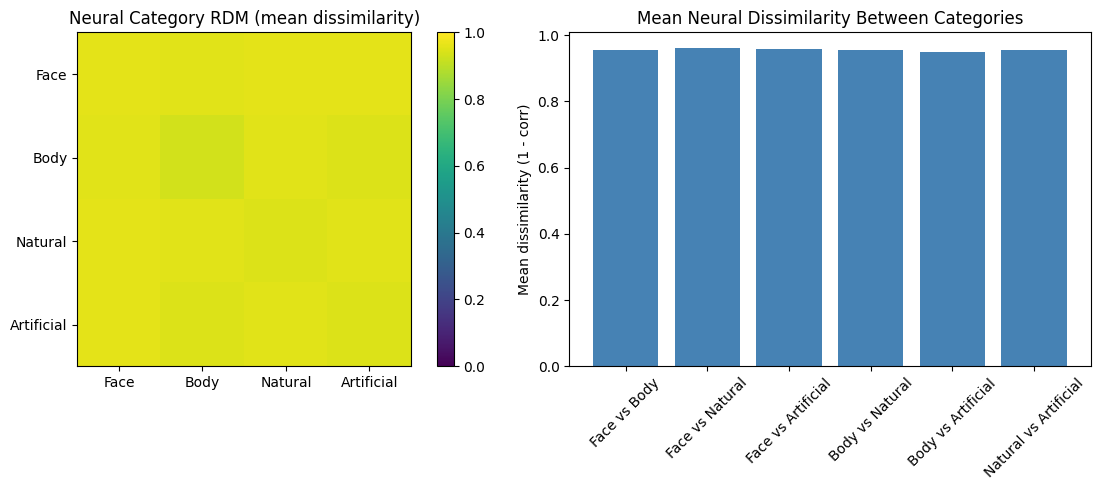

In [ ]:
plot_category_rdm_barplot(RDM_neural, StmLabels_full, tau_time)


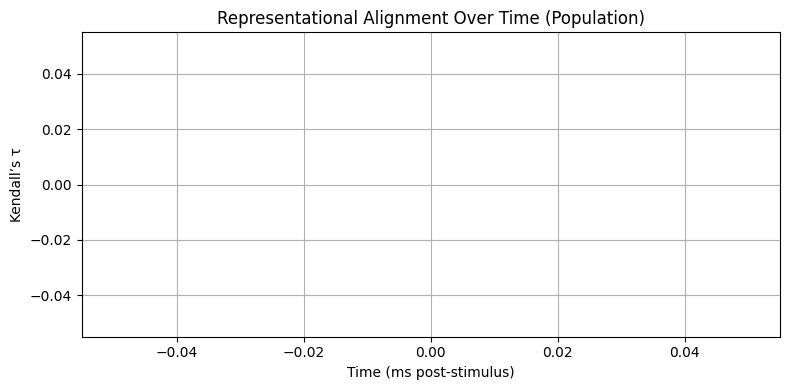

In [ ]:

# --- 1. Assume you already have these from earlier steps ---
# raster_all: list of 92 arrays, each shape (5000 trials, 550 timebins)
# cm_all:     list of 92 arrays, each shape (5000,), picture IDs per trial

# Build trial_cats from cm_all[0]:
pic_nums = cm_all[0]  # use the same trial order for all neurons

# Map picture IDs → category codes
StmLabels = np.zeros(pic_nums.max()+1, int)
StmLabels[1:201]   = 0  # Face
StmLabels[201:321] = 1  # Body
StmLabels[321:391] = 2  # Natural
StmLabels[391:501] = 3  # Artificial

trial_cats = StmLabels[pic_nums]  # shape (5000,)

# --- 2. Stack population data: (trials, neurons, time) ---
data = np.stack(raster_all, axis=1)  # shape (5000, 92, 550)

# --- 3. Ground-truth RDM (4×4) and vectorize ---
gt_rdm = np.ones((4,4)) - np.eye(4)
gt_vec = squareform(gt_rdm, checks=False)

# --- 4. Compute time‐resolved Kendall’s τ ---
n_time = data.shape[2]
tau_time = np.zeros(n_time)

for t in range(n_time):
    # Category‐mean population vector at time t: shape (4 categories, 92 neurons)
    cat_means = np.zeros((4, data.shape[1]))
    for cat in range(4):
        idx = np.where(trial_cats == cat)[0]
        cat_means[cat] = data[idx, :, t].mean(axis=0)
    # Neural RDM = 1 – Pearson correlation between those category means
    corr       = np.corrcoef(cat_means)
    neural_rdm = 1 - corr
    neural_vec = squareform(neural_rdm, checks=False)
    tau_time[t], _ = kendalltau(gt_vec, neural_vec)

# --- 5. Plot the alignment curve ---
time_ms = np.arange(n_time)  # 0…549 ms
plt.figure(figsize=(8,4))
plt.plot(time_ms, tau_time, color='k', linewidth=1.5)
plt.xlabel('Time (ms post‐stimulus)')
plt.ylabel("Kendall’s τ")
plt.title('Representational Alignment Over Time (Population)')
plt.grid(True)
plt.tight_layout()
plt.show()


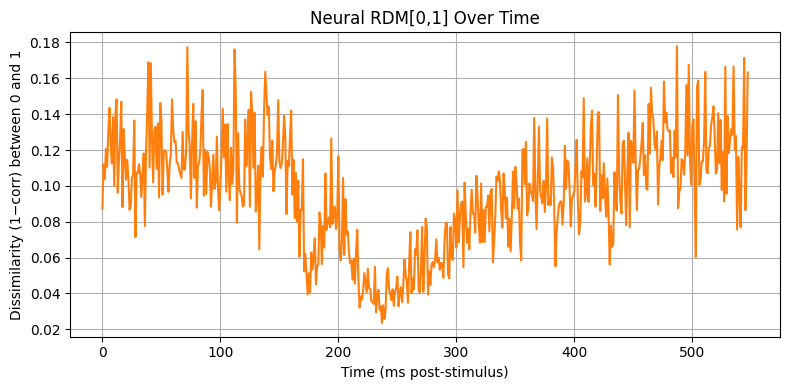

In [ ]:

# ─ assuming you already have: ─
#   data           # shape (n_trials=5000, n_neurons=92, n_time=550)
#   trial_cats     # shape (5000,), values in {0,1,2,3} for the four categories

# 1) Precompute neural RDMs for each time slice
n_time = data.shape[2]
neural_rdms = np.zeros((n_time, 4, 4))

for t in range(n_time):
    # compute category‐mean population pattern at time t
    cat_means = np.zeros((4, data.shape[1]))
    for cat in range(4):
        idx = np.where(trial_cats == cat)[0]
        cat_means[cat] = data[idx, :, t].mean(axis=0)
    # build 4×4 RDM = 1 − corr
    corr = np.corrcoef(cat_means)
    neural_rdms[t] = 1 - corr

# 2) Now pick any pair of categories (e.g. Face(0) vs Body(1)) to inspect their dissimilarity over time
c1, c2 = 0, 1  # change to any pair in {0,1,2,3}
dissim_ts = neural_rdms[:, c1, c2]  # length = 550

# 3) Plot it
time_ms = np.arange(n_time)
plt.figure(figsize=(8,4))
plt.plot(time_ms, dissim_ts, color='C1', lw=1.5)
plt.xlabel('Time (ms post‐stimulus)')
plt.ylabel(f'Dissimilarity (1−corr) between {c1} and {c2}')
plt.title(f'Neural RDM[{c1},{c2}] Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.ndimage import gaussian_filter1d

def two_category_rdm_kendall(RDM, StmLabels_full, cat_a=0, cat_b=1, sigma=2):
    """
    Restrict RDM to two categories and compute smoothed Kendall’s tau over time.

    Parameters:
    - RDM: (n_stimuli, n_stimuli, n_slices)
    - StmLabels_full: (n_stimuli,) array with labels 0–3
    - cat_a, cat_b: category IDs to compare
    - sigma: smoothing kernel width for Gaussian filter

    Returns:
    - tau_time: unsmoothed Kendall’s τ values
    - tau_smooth: smoothed τ values for plotting
    """
    selected_idx = np.where((StmLabels_full == cat_a) | (StmLabels_full == cat_b))[0]
    labels_2cat = StmLabels_full[selected_idx]
    n = len(selected_idx)
    print(f"Selected {n} stimuli: {np.sum(labels_2cat == cat_a)} in Cat {cat_a}, {np.sum(labels_2cat == cat_b)} in Cat {cat_b}")

    # Ground truth RDM (0 = same class, 1 = different)
    GT_rdm = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            GT_rdm[i, j] = int(labels_2cat[i] != labels_2cat[j])

    triu_idx = np.triu_indices(n, k=1)
    gt_vec = GT_rdm[triu_idx]

    n_slices = RDM.shape[2]
    tau_time = np.zeros(n_slices)

    for t in range(n_slices):
        rdm_slice = RDM[np.ix_(selected_idx, selected_idx, [t])][:, :, 0]
        rdm_vec = rdm_slice[triu_idx]
        tau, _ = kendalltau(rdm_vec, gt_vec)
        tau_time[t] = tau if not np.isnan(tau) else 0

    # Apply Gaussian smoothing
    tau_smooth = gaussian_filter1d(tau_time, sigma=sigma)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(tau_time, color='gray', alpha=0.3, label='Raw Kendall’s τ')
    plt.plot(tau_smooth, color='black', linewidth=2, label='Smoothed Kendall’s τ')
    plt.xlabel('Time slice')
    plt.ylabel("Kendall’s τ")
    plt.title(f"Smoothed Kendall’s τ (Cat {cat_a} vs {cat_b})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return tau_time, tau_smooth


Selected 320 stimuli: 200 in Cat 0, 120 in Cat 1


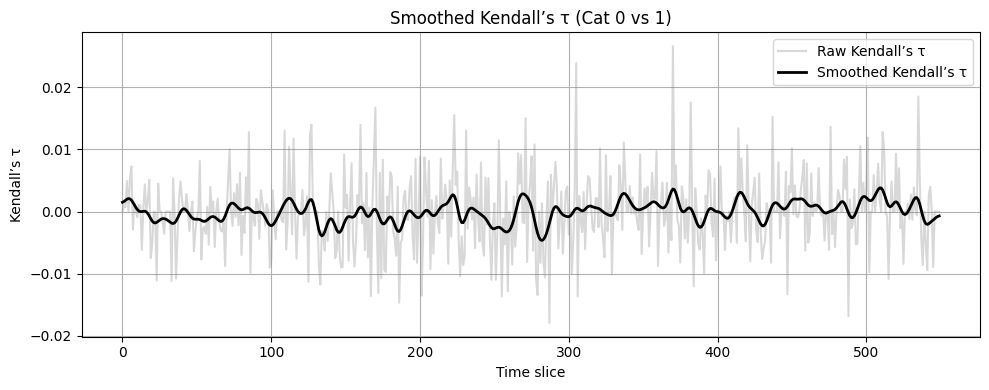

In [ ]:
tau_raw, tau_smooth = two_category_rdm_kendall(RDM_neural, StmLabels_full, cat_a=0, cat_b=1, sigma=3)


In [ ]:
tau_smooth = gaussian_filter1d(tau_time, sigma=2, axis=1)
plt.figure(figsize=(10, 4))
times = np.arange(n_slices)
plt.plot(times, tau_smooth, label="Kendall's tau", color='black')
plt.xlabel('Time slice')
plt.ylabel("Kendall’s τ")
plt.title(f"Kendall’s τ Between Neural RDM and Ground Truth (Cat {cat_a} vs {cat_b})")
plt.grid(True)
plt.tight_layout()
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1


Creating placeholder Visual Feature RDM...
Placeholder Visual Feature RDM created.

Performing GLM analysis for each window...
GLM analysis complete.


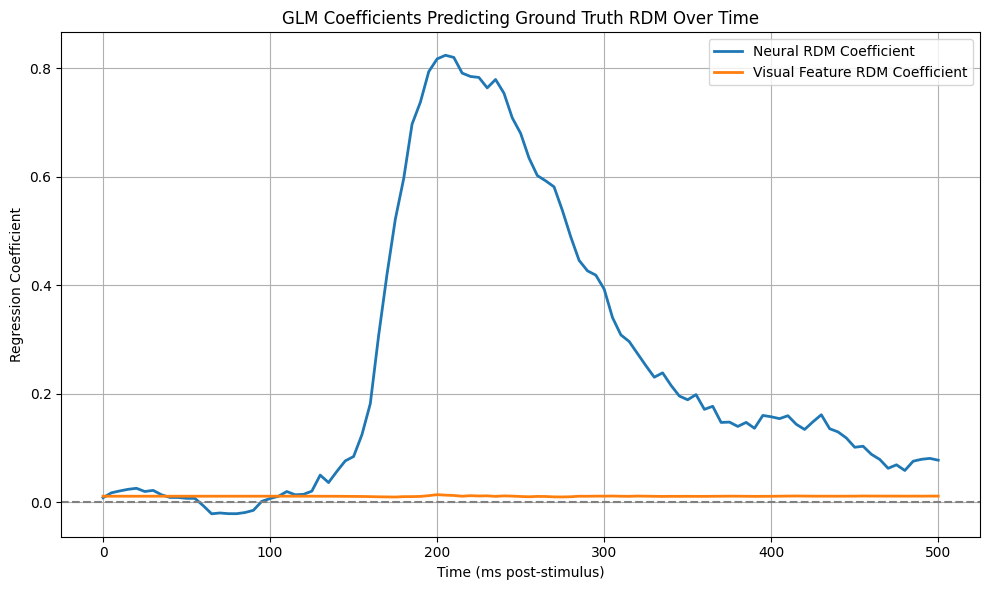

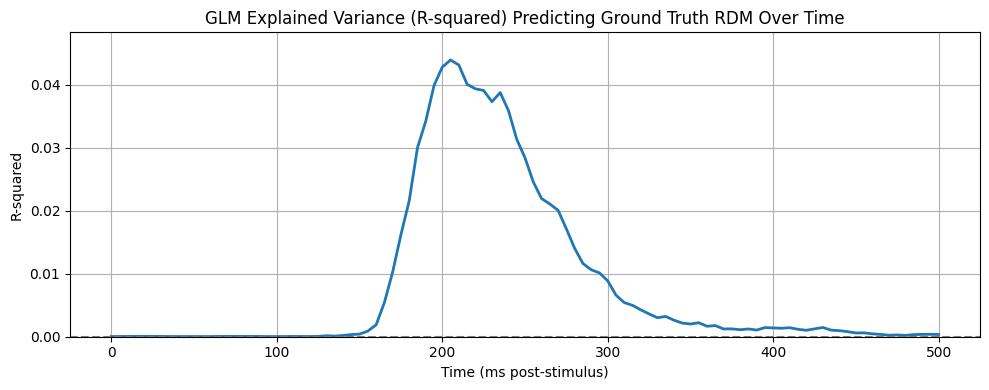


GLM analysis and plotting complete. Plots saved as PDF files.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression # Using Linear Regression as a common form of GLM
from scipy.io import savemat # Although not used in this specific plot, kept from previous code structure

# --- Assume you have RDM_neural and RDM_truth from the previous RDM analysis ---
# RDM_neural: [n_stimuli x n_stimuli x n_windows] - Neural RDMs computed for each sliding window
# RDM_truth:  [n_stimuli x n_stimuli]           - Ground Truth RDM based on categories

# If you are running this code separately, you would need to load or compute
# RDM_neural and RDM_truth first.
# For demonstration, let's create dummy versions if they don't exist.
try:
    RDM_neural.shape
    RDM_truth.shape
    n_stimuli, _, n_windows = RDM_neural.shape
except NameError:
    print("RDM_neural or RDM_truth not found. Creating dummy data for demonstration.")
    n_stimuli = 500
    n_windows = 101 # Example number of windows
    # Create dummy RDM_neural (random values for demonstration)
    RDM_neural = np.random.rand(n_stimuli, n_stimuli, n_windows)
    # Ensure symmetry and zero diagonal for dummy RDM_neural
    for w in range(n_windows):
        RDM_neural[:, :, w] = (RDM_neural[:, :, w] + RDM_neural[:, :, w].T) / 2
        np.fill_diagonal(RDM_neural[:, :, w], 0)
    # Create dummy RDM_truth (random 0s and 1s for demonstration)
    RDM_truth = np.random.randint(0, 2, size=(n_stimuli, n_stimuli))
    RDM_truth = (RDM_truth + RDM_truth.T) / 2
    np.fill_diagonal(RDM_truth, 0)


# --- Placeholder for Visual Feature RDM ---
# In a real analysis, you would load or compute an RDM based on visual features
# (e.g., pixel differences, CNN feature distances).
# For this code, we'll create a dummy visual feature RDM.
# This RDM is assumed to be constant across time windows as visual features of the stimuli don't change.
print("\nCreating placeholder Visual Feature RDM...")
RDM_visual_feature = np.random.rand(n_stimuli, n_stimuli)
# Ensure symmetry and zero diagonal for dummy visual feature RDM
RDM_visual_feature = (RDM_visual_feature + RDM_visual_feature.T) / 2
np.fill_diagonal(RDM_visual_feature, 0)

print("Placeholder Visual Feature RDM created.")

# --- Vectorize upper-triangles for GLM ---
# Get the indices for the upper triangle (excluding the diagonal)
triu_idx = np.triu_indices(n_stimuli, k=1)

# Extract the upper triangle values from the ground truth RDM (dependent variable)
truth_vec = RDM_truth[triu_idx]

# Extract the upper triangle values from the visual feature RDM (one of the predictors)
visual_feature_vec = RDM_visual_feature[triu_idx]

# --- Perform GLM (Linear Regression) for each time window ---
# We will store the coefficients for the neural and visual predictors, and the R-squared.
coeff_neural_over_time = np.zeros(n_windows)
coeff_visual_over_time = np.zeros(n_windows)
r_squared_over_time = np.zeros(n_windows)

print("\nPerforming GLM analysis for each window...")
# Loop through each time window
for w in range(n_windows):
    # print(f"Processing window {w+1}/{n_windows} for GLM...")

    # Extract the upper triangle values from the neural RDM for the current window
    neural_vec_window = RDM_neural[:, :, w][triu_idx]

    # Combine predictors: Neural RDM vector and Visual Feature RDM vector
    # Shape: (number of pairs of stimuli, number of predictors [2])
    X = np.column_stack((neural_vec_window, visual_feature_vec))
    y = truth_vec # The dependent variable is the ground truth RDM vector

    # Handle potential NaNs in the neural RDM vector for the current window
    # Find rows where the neural RDM value is not NaN
    valid_rows_mask = ~np.isnan(X[:, 0]) # Check for NaNs in the neural predictor column

    # Filter the data to include only valid rows
    X_valid = X[valid_rows_mask]
    y_valid = y[valid_rows_mask]

    # Ensure there are enough valid data points to fit the model (at least 2 for simple linear regression)
    if X_valid.shape[0] < 2:
        print(f"Warning: Not enough valid data points to fit GLM in window {w}. Filling with NaNs.")
        coeff_neural_over_time[w] = np.nan
        coeff_visual_over_time[w] = np.nan
        r_squared_over_time[w] = np.nan
        continue

    # Fit the Linear Regression model
    # The model is: truth_vec = beta_0 + beta_neural * neural_vec_window + beta_visual * visual_feature_vec
    # Note: LinearRegression by default includes an intercept (beta_0). If you want to force it through the origin, use fit_intercept=False.
    # Based on typical RDM analysis, an intercept might be appropriate.
    model = LinearRegression()
    model.fit(X_valid, y_valid)

    # Store the coefficients and R-squared for the current window
    # model.coef_ is an array of coefficients [beta_neural, beta_visual]
    coeff_neural_over_time[w] = model.coef_[0]
    coeff_visual_over_time[w] = model.coef_[1]
    r_squared_over_time[w] = model.score(X_valid, y_valid) # R-squared value

print("GLM analysis complete.")

# --- Plotting GLM Results Over Time ---

# Create a time axis for the windows (consistent with RDM analysis plot)
# The time corresponds to the start of each window.
window_times = np.arange(n_windows) * step_size # Time in ms, corresponding to the start of each window

# Plot the regression coefficients over time
plt.figure(figsize=(10, 6))
plt.plot(window_times, coeff_neural_over_time, label='Neural RDM Coefficient', linewidth=2)
plt.plot(window_times, coeff_visual_over_time, label='Visual Feature RDM Coefficient', linewidth=2)
plt.axhline(0, color='gray', linestyle='--') # Add line at coefficient = 0
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('Regression Coefficient')
plt.title('GLM Coefficients Predicting Ground Truth RDM Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('glm_coefficients_over_time.pdf', bbox_inches='tight') # Save the figure
plt.show()

# Plot the R-squared over time
plt.figure(figsize=(10, 4))
plt.plot(window_times, r_squared_over_time, linewidth=2)
plt.axhline(0, color='gray', linestyle='--') # R-squared can be negative for poor fits without intercept
plt.ylim(min(0, np.nanmin(r_squared_over_time)), np.nanmax(r_squared_over_time) * 1.1 if np.nanmax(r_squared_over_time) > 0 else 0.1) # Adjust y-limit
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('R-squared')
plt.title('GLM Explained Variance (R-squared) Predicting Ground Truth RDM Over Time')
plt.grid(True)
plt.tight_layout()
plt.savefig('glm_rsquared_over_time.pdf', bbox_inches='tight') # Save the figure
plt.show()

print("\nGLM analysis and plotting complete. Plots saved as PDF files.")


In [ ]:

# raster_all: list of length 92
data = np.stack(raster_all, axis=1)
# Now data.shape == (5000 trials, 92 neurons, 550 time bins)

pic_nums = cm_all[0]  # (5000,)


In [ ]:
StmLabels = np.zeros(pic_nums.max()+1, dtype=int)
StmLabels[1:201]   = 0  # Face
StmLabels[201:321] = 1  # Body
StmLabels[321:391] = 2  # Natural
StmLabels[391:501] = 3  # Artificial

trial_cats = StmLabels[pic_nums]  # (5000,)


In [ ]:

gt_rdm = np.ones((4,4)) - np.eye(4)  # 0 on diag, 1 else
gt_vec = squareform(gt_rdm, checks=False)


In [ ]:

n_time   = data.shape[2]  # 550
tau_time = np.zeros(n_time)

for t in range(n_time):
    # 4A) Compute the mean response of each category (4×92)
    cat_means = np.zeros((4, data.shape[1]))
    for cat in range(4):
        idx = np.where(trial_cats == cat)[0]
        cat_means[cat] = data[idx, :, t].mean(axis=0)
    # 4B) Neural RDM = 1 − Pearson corr between these 4 vectors
    corr       = np.corrcoef(cat_means)
    neural_rdm = 1 - corr
    neural_vec = squareform(neural_rdm, checks=False)
    # 4C) Kendall’s τ with ground truth
    tau_time[t], _ = kendalltau(gt_vec, neural_vec)


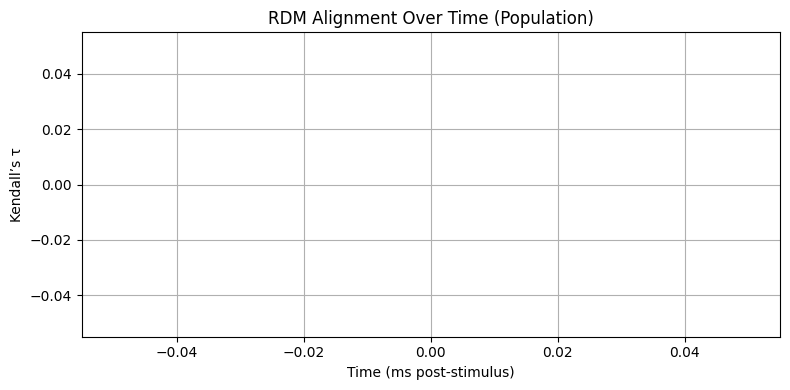

In [ ]:

time_ms = np.arange(n_time)  # 0…549

plt.figure(figsize=(8,4))
plt.plot(time_ms, tau_time, color='k', lw=1.5)
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel("Kendall’s τ")
plt.title('RDM Alignment Over Time (Population)')
plt.grid(True)
plt.tight_layout()
plt.show()


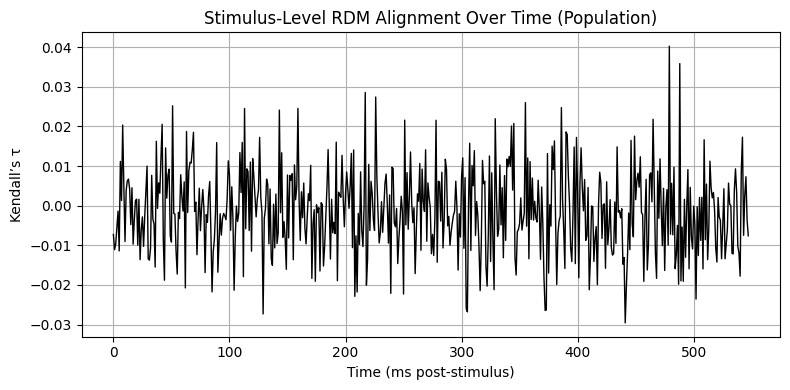

In [ ]:

# 1) You already have:
#    raster_all : list of 92 arrays, each (5000 trials × 550 timebins)
#    cm_all     : list of 92 arrays, each (5000,) picture IDs per trial
#    StmLabels  : array mapping picture ID → category (0–3)

# Use cm_all[0] as the canonical trial→picture mapping
pic_nums = cm_all[0]             # shape (5000,)
n_trials, n_time = raster_all[0].shape
n_stim = pic_nums.max()          # e.g. 500 unique pictures
n_neurons = len(raster_all)

# 2) Stack into a population tensor: (trials, neurons, time)
data = np.stack(raster_all, axis=1)  # shape (5000, 92, 550)

# 3) Build ground‐truth RDM (n_stim×n_stim):
#    0 if same category, 1 if different
stim_cats = StmLabels[np.arange(1, n_stim+1)]
gt_rdm = np.zeros((n_stim, n_stim), dtype=int)
for i in range(n_stim):
    for j in range(n_stim):
        gt_rdm[i,j] = int(stim_cats[i] != stim_cats[j])
gt_vec = squareform(gt_rdm, checks=False)

# 4) Preallocate τ‐vs‐time
tau_time = np.zeros(n_time)

# 5) For each timebin, build the neural RDM and compute τ
for t in range(n_time):
    # 5A) Compute each stimulus’s mean pattern (over all trials of that picture)
    stim_means = np.zeros((n_stim, n_neurons))
    for s in range(1, n_stim+1):
        idx = np.where(pic_nums == s)[0]
        stim_means[s-1] = data[idx, :, t].mean(axis=0)
    # 5B) Neural RDM via Euclidean distance
    neural_rdm = squareform(pdist(stim_means, metric='euclidean'))
    neural_vec = squareform(neural_rdm, checks=False)
    # 5C) Kendall’s τ with ground truth
    tau_time[t], _ = kendalltau(gt_vec, neural_vec)

# 6) Plot τ over time
time_ms = np.arange(n_time)  # 0…549
plt.figure(figsize=(8,4))
plt.plot(time_ms, tau_time, color='k', linewidth=1)
plt.xlabel('Time (ms post‐stimulus)')
plt.ylabel("Kendall’s τ")
plt.title('Stimulus‐Level RDM Alignment Over Time (Population)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# Suppose tau_time is your array of length 550 with some nan entries
# 1) Find indices that are not nan
valid = ~np.isnan(tau_time)

# 2) If you want to inspect the first few invalid times:
invalid_times = np.where(~valid)[0]
print("Time bins with undefined τ (nan):", invalid_times[:10], "...")

# 3) Use nanargmax to ignore nan
peak_t = np.nanargmax(tau_time)
peak_val = tau_time[peak_t]
print(f"Peak Kendall’s τ of {peak_val:.3f} occurs at {peak_t} ms post‐stimulus")


Time bins with undefined τ (nan): [548 549] ...
Peak Kendall’s τ of 0.040 occurs at 479 ms post‐stimulus


### GLM

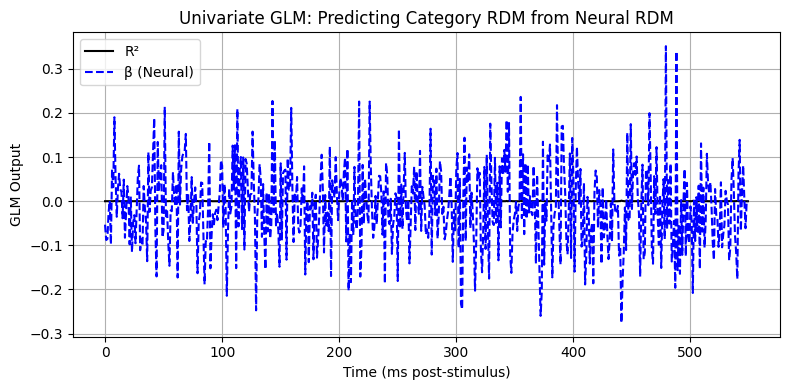

In [ ]:

# Assume:
# - data: shape (5000, 92, 550)  (trials × neurons × time)
# - pic_nums: (5000,) picture IDs in [1, 500]
# - StmLabels: shape (501,) with picture category labels (0–3)

n_stim = 500
n_time = data.shape[2]

# Ground-truth RDM (same/diff category)
gt_rdm = np.zeros((n_stim, n_stim), int)
stim_cats = StmLabels[1:501]
for i in range(n_stim):
    for j in range(n_stim):
        gt_rdm[i,j] = int(stim_cats[i] != stim_cats[j])
gt_vec = squareform(gt_rdm, checks=False)

# Build neural RDMs across time
neural_mat = np.zeros((n_time, len(gt_vec)))
for t in range(n_time):
    stim_means = np.zeros((n_stim, data.shape[1]))
    for s in range(1, n_stim+1):
        idx = np.where(pic_nums == s)[0]
        stim_means[s-1] = data[idx, :, t].mean(axis=0)
    neural_rdm = squareform(pdist(stim_means, metric='euclidean'))
    neural_mat[t] = squareform(neural_rdm, checks=False)

# Fit univariate regression: GT_RDM ~ Neural_RDM
rsquared = np.zeros(n_time)
beta     = np.zeros(n_time)
for t in range(n_time):
    X = sm.add_constant(neural_mat[t])  # Add intercept
    model = sm.OLS(gt_vec, X).fit()
    beta[t] = model.params[1]
    rsquared[t] = model.rsquared

# Plot
time = np.arange(n_time)
plt.figure(figsize=(8, 4))
plt.plot(time, rsquared, label='R²', color='black')
plt.plot(time, beta, label='β (Neural)', linestyle='--', color='blue')
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('GLM Output')
plt.title('Univariate GLM: Predicting Category RDM from Neural RDM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
peak_t = np.argmax(rsquared)
print(f"Max R² of {rsquared[peak_t]:.3f} at {peak_t} ms")


Max R² of 0.002 at 479 ms


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.6/423.6 kB 9.1 MB/s eta 0:00:00


In [ ]:
# Suppose lfp_trials is (5000 trials, 550 timepoints, sampled at 1 kHz)
lfp_trials = raster_all[0]  # replace with your actual LFP matrix, not the spike raster!
trial_cats = StmLabels[pic_nums]


/usr/local/lib/python3.11/dist-packages/tensorpac/methods/meth_surrogates.py:159: RuntimeWarning: invalid value encountered in divide
  pac /= s_std


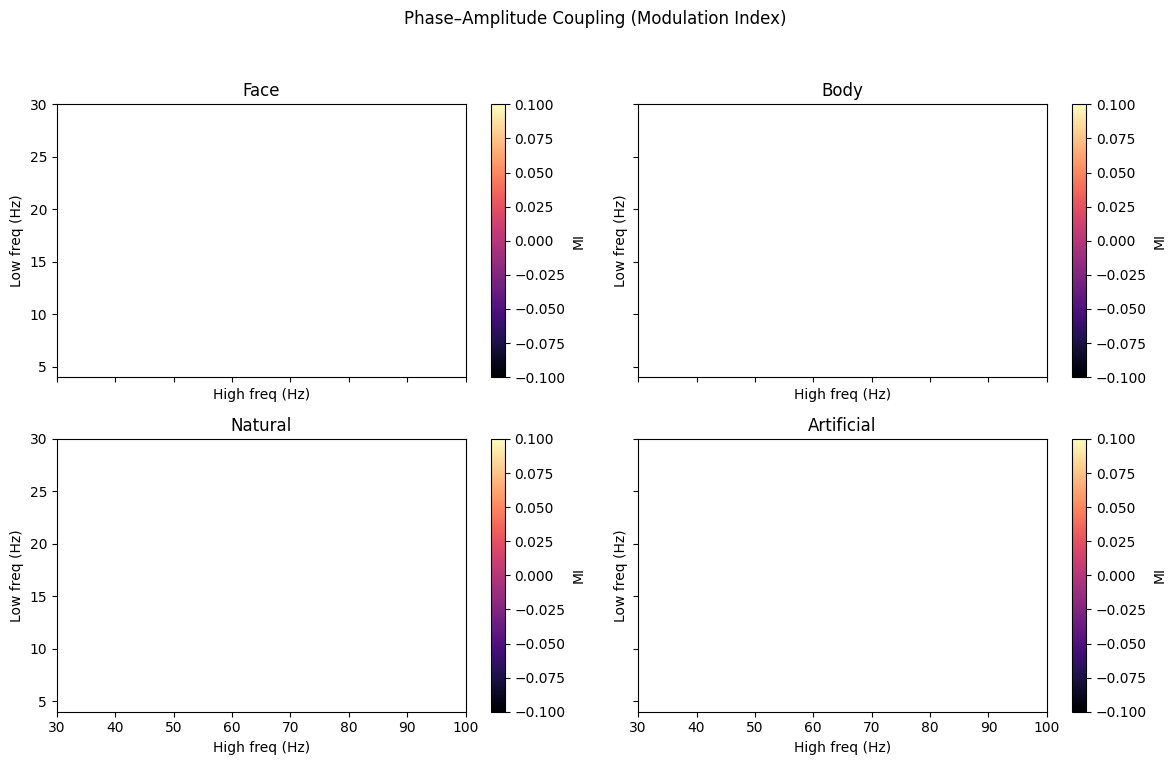

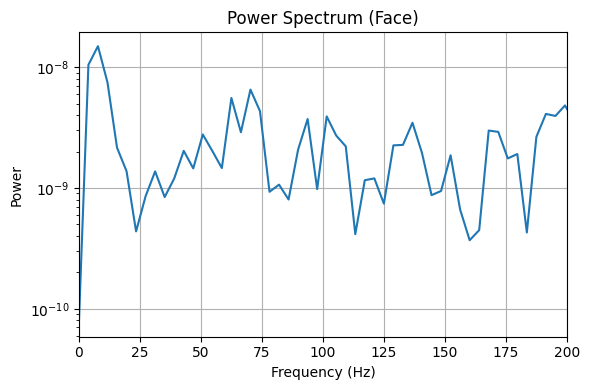

In [ ]:

# Example LFP: replace with your real LFP data (n_trials × n_times)
# Here I'm just re‐using raster_all[0] as a placeholder; use your actual LFP.
lfp_trials = raster_all[0]  # shape (n_trials=5000, n_times=550)
trial_cats = StmLabels[pic_nums]

# 1) Define frequency bands
fL = np.arange(4, 31, 2)    # low freq 4–30 Hz
fH = np.arange(30, 101, 5)  # high freq 30–100 Hz

# 2) Initialize Pac object for Modulation Index (Tort’s method = idpac=1)

# Use Tort's method (1), no normalization (0), no surrogates (0)
p = Pac(idpac=(1, 2, 4), f_pha=fL, f_amp=fH, dcomplex='hilbert', verbose=False)

# 3) Compute and plot PAC comodulograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for cat, ax in zip(range(4), axs.flatten()):
    idx = np.where(trial_cats == cat)[0]
    data_cat = lfp_trials[idx]  # (n_trials_cat, n_times)
    # filterfit returns shape (len(fL), len(fH), n_epochs)
    pac = p.filterfit(1000, data_cat)
    # average across epochs (trials)
    mi = pac.mean(axis=2)
    im = ax.imshow(mi, origin='lower',
                   extent=[fH[0], fH[-1], fL[0], fL[-1]],
                   aspect='auto', cmap='magma')
    ax.set_title(['Face','Body','Natural','Artificial'][cat])
    ax.set_xlabel('High freq (Hz)')
    ax.set_ylabel('Low freq (Hz)')
    fig.colorbar(im, ax=ax, label='MI')

plt.suptitle('Phase–Amplitude Coupling (Modulation Index)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 4) Plot power spectrum for one category
cat = 0  # Face
idx = np.where(trial_cats == cat)[0]
lfp_mean = lfp_trials[idx].mean(axis=0)

f, Pxx = welch(lfp_mean, fs=1000, nperseg=256)
plt.figure(figsize=(6,4))
plt.semilogy(f, Pxx)
plt.xlim(0,200)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectrum (Face)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac

# ----------------------
# Assumed variables:
# lfp_trials: np.array of shape (n_trials, n_times)
# trial_labels: np.array of shape (n_trials,) with values 0–3 for categories
# ----------------------

sf = 1000  # Sampling frequency in Hz
f_pha = (4, 8)      # Phase frequency range (e.g., theta)
f_amp = (30, 150)   # Amplitude frequency range (e.g., gamma)

n_bins = 18         # Number of phase bins

# Create TensorPAC object (using Tort's method with surrogate correction)
p = Pac(idpac=(1, 2, 4), f_pha=f_pha, f_amp=f_amp, dcomplex='hilbert', verbose='ERROR')

# Loop through categories (0=Face, 1=Body, 2=Natural, 3=Artificial)
for cat in np.unique(trial_labels):
    data_cat = lfp_trials[trial_labels == cat]

    # Compute PAC (returns shape: [n_phase_freqs, n_amp_freqs, n_trials])
    pac = p.filterfit(sf=sf, x=data_cat)

    # Average over trials
    mi = pac.mean(axis=2)

    # Plot comodulogram
    plt.figure(figsize=(6, 5))
    p.comodulogram(mi, title=f'PAC (Category {cat})', cmap='viridis')
    plt.tight_layout()
    plt.show()


NameError: name 'trial_labels' is not defined

In [ ]:
print(data_cat.shape)  # Should be (n_trials, n_times)


(1100, 550)


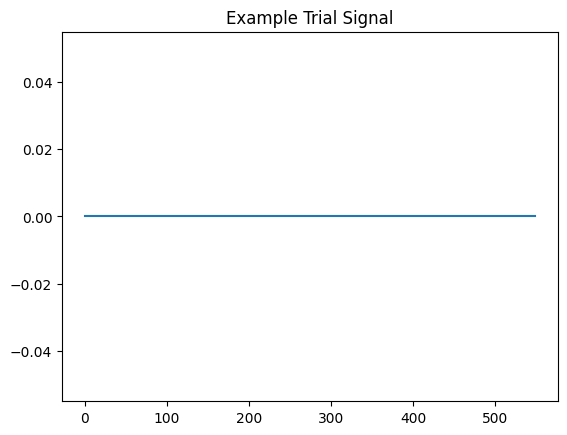

In [ ]:
plt.plot(data_cat[0])
plt.title("Example Trial Signal")
plt.show()


In [ ]:
f_pha = np.linspace(4, 12, 10)   # theta
f_amp = np.linspace(30, 100, 10) # gamma


In [ ]:
p = Pac(idpac=(1, 2, 4), f_pha=f_pha, f_amp=f_amp)


In [ ]:
pac = p.filterfit(1000, data_cat)
mi = pac.mean(axis=2)  # Mean over trials


In [ ]:
print(mi.shape)  # Should be (len(f_pha), len(f_amp))


(9, 9)


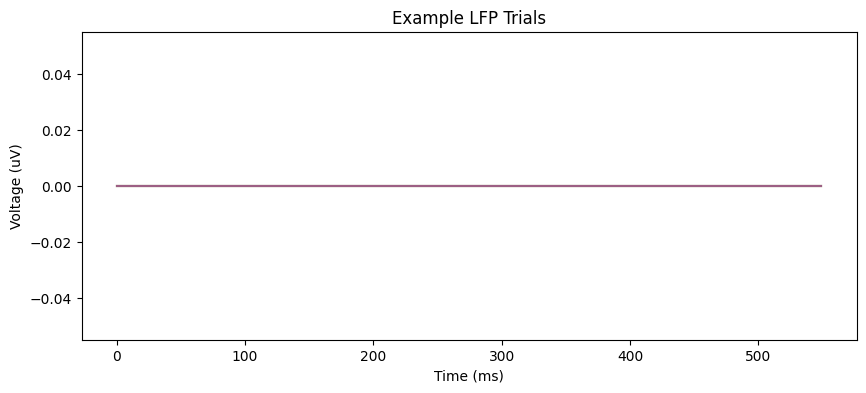

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.plot(lfp_trials[i], alpha=0.6)
plt.title("Example LFP Trials")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (uV)")
plt.show()


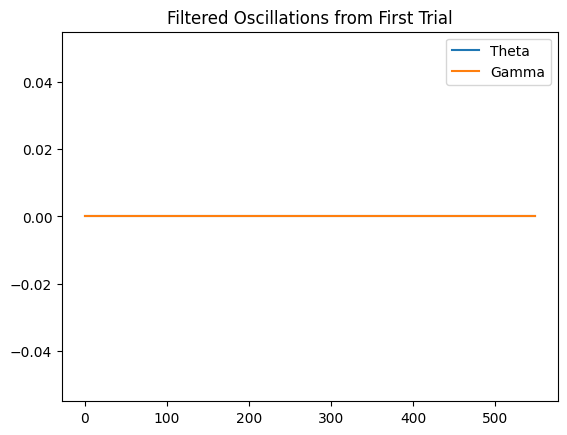

In [ ]:

def bandpass_filter(data, low, high, fs=1000, order=3):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, data)

# Try theta and gamma bands
theta = bandpass_filter(lfp_trials[0], 4, 8)
gamma = bandpass_filter(lfp_trials[0], 30, 80)

plt.plot(theta, label='Theta')
plt.plot(gamma, label='Gamma')
plt.legend()
plt.title("Filtered Oscillations from First Trial")
plt.show()


In [ ]:
for i in range(5):
    data_cat = lfp_trials[grp == i]
    print(f"Category {i} mean signal:", data_cat.mean())
    print(f"Category {i} std dev:", data_cat.std())


Category 0 mean signal: 0.002060909090909091
Category 0 std dev: 0.04535043268402297
Category 1 mean signal: 0.0018378787878787879
Category 1 std dev: 0.0428310750441762
Category 2 mean signal: 0.002007792207792208
Category 2 std dev: 0.044763388815443096
Category 3 mean signal: 0.001778512396694215
Category 3 std dev: 0.04213489397576574
Category 4 mean signal: nan
Category 4 std dev: nan


<ipython-input-83-9d5a9b714f94>:3: RuntimeWarning: Mean of empty slice.
  print(f"Category {i} mean signal:", data_cat.mean())
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import h5py

lfp_path = '/content/drive/MyDrive/Cognitive_HW2/data_LFP.mat'
with h5py.File(lfp_path, 'r') as f:
    # grab the first reference
    data_refs = f['data_LFP_it']['data_it']
    first_ref = data_refs[0, 0]
    obj = f[first_ref]
    print("dtype of data_it dataset:", data_refs.dtype)
    print("Type of f[first_ref]:", type(obj))
    if isinstance(obj, h5py.Dataset):
        print("  It's a dataset of shape", obj.shape, "and dtype", obj.dtype)
    elif isinstance(obj, h5py.Group):
        print("  It's a group with keys:", list(obj.keys()))
    # now do the same for 'cm'
    cm_refs = f['data_LFP_it']['cm']
    cm_ref0 = cm_refs[0,0]
    obj2 = f[cm_ref0]
    print("\nType of f[cm_ref0]:", type(obj2))
    if isinstance(obj2, h5py.Dataset):
        print("  cm is a dataset:", obj2.shape, obj2.dtype)
    else:
        print("  cm is a group with keys:", list(obj2.keys()))


dtype of data_it dataset: object
Type of f[first_ref]: <class 'h5py._hl.dataset.Dataset'>
  It's a dataset of shape (900, 818) and dtype float64

Type of f[cm_ref0]: <class 'h5py._hl.dataset.Dataset'>
  cm is a dataset: (1, 820) float64


Phase Amplitude Coupling object defined
INFO:tensorpac:Phase Amplitude Coupling object defined
    extract phases (n_pha=8) and amplitudes (n_amps=14)
INFO:tensorpac:    extract phases (n_pha=8) and amplitudes (n_amps=14)
    true PAC estimation using Mean Vector Length (MVL, Canolty et al. 2006)
INFO:tensorpac:    true PAC estimation using Mean Vector Length (MVL, Canolty et al. 2006)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=874)
INFO:tensorpac:    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=874)
    infer p-values at (p=0.05, mcp=maxstat)
INFO:tensorpac:    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract the mean and divide by the deviation of the surrogates)
INFO:tensorpac:    normalize true PAC estimation by surrogates (Substract the mean and divide by the deviation of the surrogates)
    extract phas

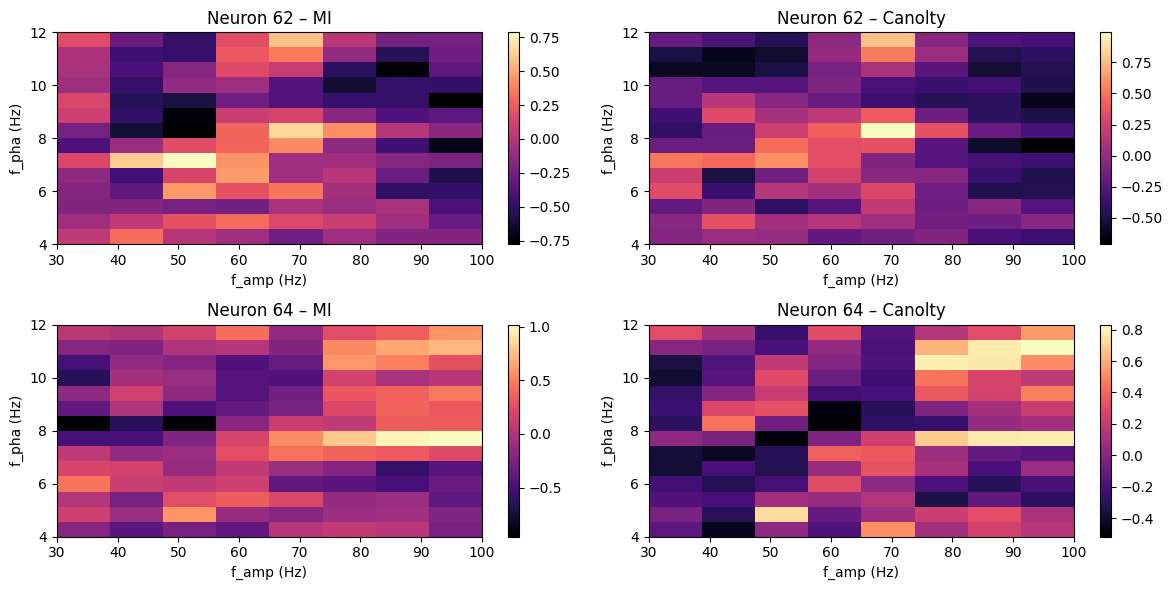

/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 1000 is greater than input length  = 822, using nperseg = 822
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


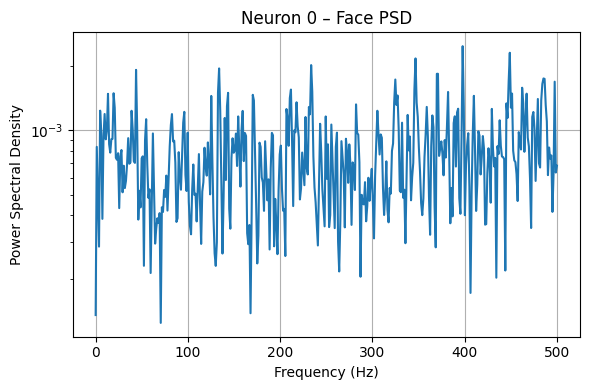

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac
from scipy.signal import welch

# --- 1. Load LFP and cm as lists (no stacking) ---
def load_lfp_and_cm_lists(mat_path):
    with h5py.File(mat_path, 'r') as f:
        grp       = f['data_LFP_it']
        data_refs = grp['data_it']
        cm_refs   = grp['cm']
        lfps, cms = [], []
        for i in range(data_refs.shape[0]):
            raw = np.array(f[data_refs[i,0]])  # shape: (n_trials, n_times) or transposed
            stim = np.array(f[cm_refs[i,0]]).flatten().astype(int)
            # if raw rows ≠ stim length, transpose or trim
            if raw.shape[0] == stim.shape[0]:
                lfp = raw
            elif raw.shape[1] == stim.shape[0]:
                lfp = raw.T
            else:
                # trim to common length
                n = min(raw.shape[0], stim.shape[0])
                lfp  = raw[:n, :]
                stim = stim[:n]
            lfps.append(lfp)
            cms.append(stim)
    return lfps, cms

lfp_path = '/content/drive/MyDrive/Cognitive_HW2/data_LFP.mat'
lfp_list, cm_list = load_lfp_and_cm_lists(lfp_path)
sf = 1000  # sampling rate

# --- 2. Build trial→category mapping once (use neuron 0 as reference) ---
n_trials = len(lfp_list[0])
trial_cat = np.full(n_trials, -1, dtype=int)
face_ids       = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/face_labels.txt', dtype=int)
body_ids       = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/body_labels.txt', dtype=int)
natural_ids    = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/natural_labels.txt', dtype=int)
artificial_ids = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/artifact_labels.txt', dtype=int)
trial_cat[face_ids]       = 0
trial_cat[body_ids]       = 1
trial_cat[natural_ids]    = 2
trial_cat[artificial_ids] = 3

# --- 3. PAC settings ---
f_pha  = np.arange(4, 13, 1)
f_amp  = np.arange(30, 101, 5)
methods = {'MI': (1,2,4), 'Canolty': (2,2,4)}
neurons = [62, 64]  # pick the two neurons you want

# --- 4. Compute & plot PAC for each neuron/method ---
fig, axes = plt.subplots(len(neurons), len(methods), figsize=(12,6))
for ni, neuron in enumerate(neurons):
    data = lfp_list[neuron]  # shape: (n_trials, n_times)
    for mi, (name, idpac) in enumerate(methods.items()):
        p = Pac(idpac=idpac, f_pha=f_pha, f_amp=f_amp, dcomplex='hilbert')
        pac_by_cat = []
        for cat in range(4):
            idx = np.where(trial_cat == cat)[0]
            pac = p.filterfit(sf, data[idx, :])
            pac_by_cat.append(pac.mean(axis=2))
        pac_by_cat = np.array(pac_by_cat)  # (4, len(f_pha), len(f_amp))
        ax = axes[ni, mi]
        im = ax.imshow(
            pac_by_cat[0], origin='lower', aspect='auto',
            extent=[f_amp[0], f_amp[-1], f_pha[0], f_pha[-1]],
            cmap='magma'
        )
        ax.set_title(f'Neuron {neuron} – {name}')
        ax.set_xlabel('f_amp (Hz)')
        ax.set_ylabel('f_pha (Hz)')
        fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# --- 5. Power spectrum for neuron 0, Face trials ---
neuron, cat = 64, 0
data0 = lfp_list[neuron]
idx   = np.where(trial_cat == cat)[0]
psds  = [welch(data0[i], sf, nperseg=sf)[1] for i in idx]
mean_psd = np.mean(psds, axis=0)
f        = welch(data0[idx[0]], sf, nperseg=sf)[0]

plt.figure(figsize=(6,4))
plt.semilogy(f, mean_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Neuron 0 – Face PSD')
plt.grid(True)
plt.tight_layout()
plt.show()


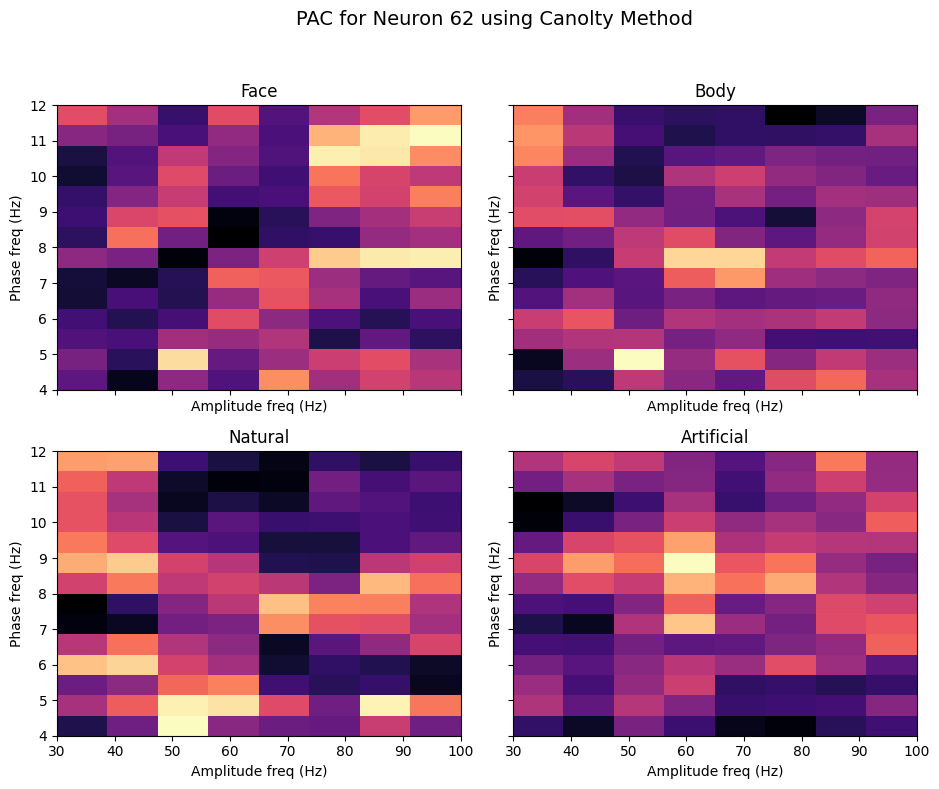

In [ ]:
# f_pha and af_amp are frequency centers; pac_cat[cat] is (len(f_pha), len(f_amp))
names = ['Face', 'Body', 'Natural', 'Artificial']
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for cat in range(4):
    ax = axes.flat[cat]
    # shape: f_pha x f_amp
    im = ax.imshow(pac_by_cat[cat], origin='lower', aspect='auto',
                   extent=[f_amp[0], f_amp[-1], f_pha[0], f_pha[-1]],
                   cmap='magma')
    ax.set_title(names[cat])
    ax.set_xlabel('Amplitude freq (Hz)')
    ax.set_ylabel('Phase freq (Hz)')

fig.suptitle(f"PAC for Neuron {neuron} using {name} Method", fontsize=14)
# fig.colorbar(im, ax=axes, shrink=0.7, location='right', label='PAC Strength')
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


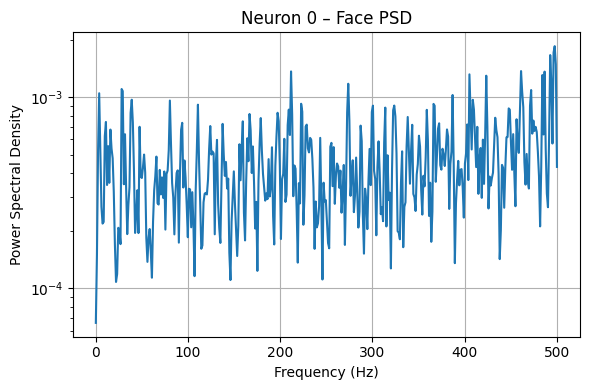

In [ ]:
neuron, cat = 62, 0
data0 = lfp_list[neuron]
idx   = np.where(trial_cat == cat)[0]
psds  = [welch(data0[i], sf, nperseg=sf)[1] for i in idx]
mean_psd = np.mean(psds, axis=0)
f        = welch(data0[idx[0]], sf, nperseg=sf)[0]

plt.figure(figsize=(6,4))
plt.semilogy(f, mean_psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Neuron 0 – Face PSD')
plt.grid(True)
plt.tight_layout()
plt.show()

Phase Amplitude Coupling object defined
INFO:tensorpac:Phase Amplitude Coupling object defined
    extract phases (n_pha=8) and amplitudes (n_amps=14)
INFO:tensorpac:    extract phases (n_pha=8) and amplitudes (n_amps=14)
    true PAC estimation using Modulation Index (MI, Tort et al. 2010)
INFO:tensorpac:    true PAC estimation using Modulation Index (MI, Tort et al. 2010)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=5286)
INFO:tensorpac:    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=5286)
    infer p-values at (p=0.05, mcp=maxstat)
INFO:tensorpac:    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract the mean and divide by the deviation of the surrogates)
INFO:tensorpac:    normalize true PAC estimation by surrogates (Substract the mean and divide by the deviation of the surrogates)
    extract phases (n_pha=

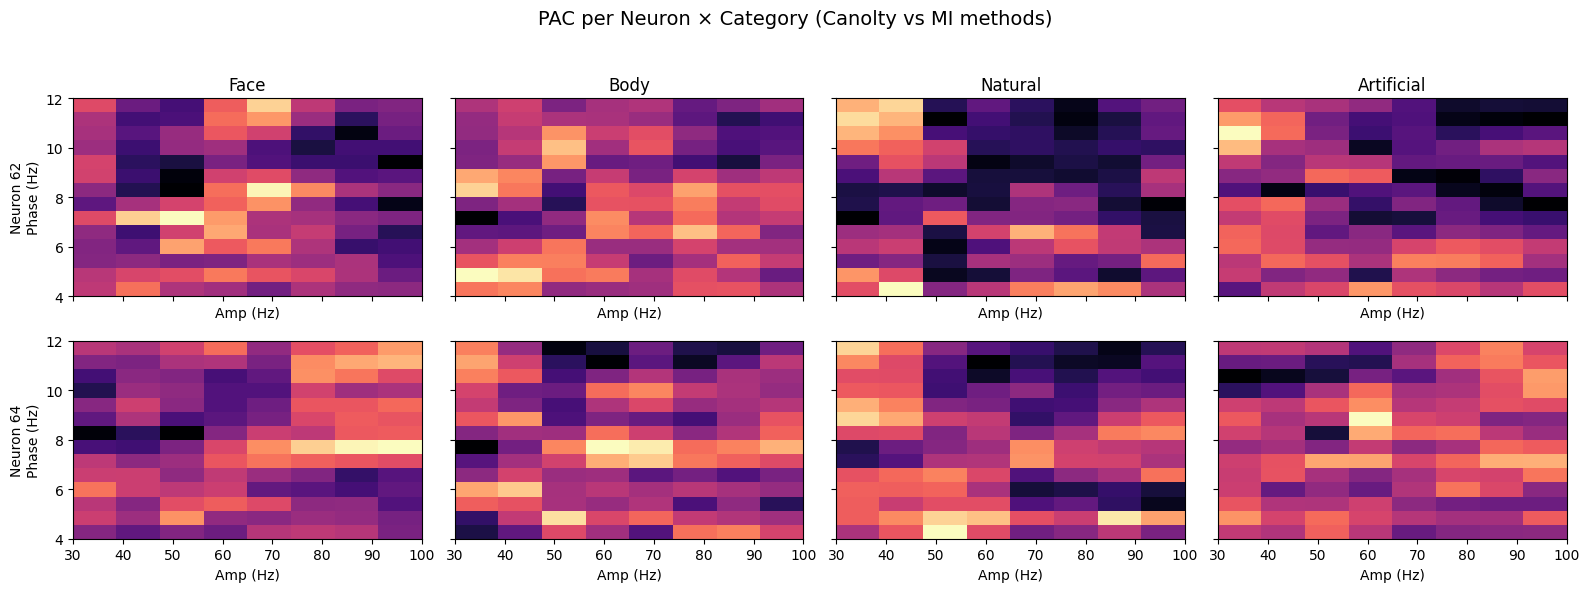

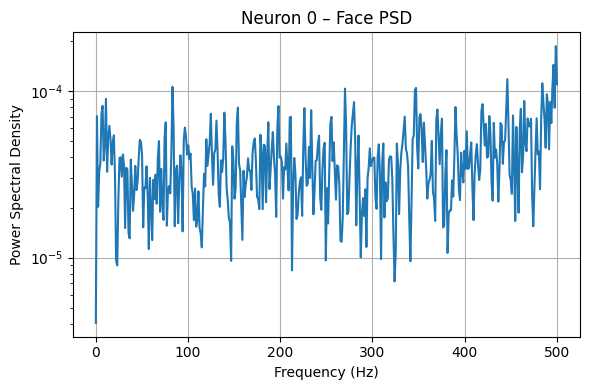

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac
from scipy.signal import welch

# --- 1. Load LFP and stimulus‐index lists, avoiding shape‐mismatch stacking ---
def load_lfp_and_cm_lists(mat_path):
    lfps, cms = [], []
    with h5py.File(mat_path, 'r') as f:
        grp       = f['data_LFP_it']
        data_refs = grp['data_it']  # object refs
        cm_refs   = grp['cm']
        for i in range(data_refs.shape[0]):
            raw = np.array(f[data_refs[i,0]])
            stim = np.array(f[cm_refs[i,0]]).flatten().astype(int)
            # transpose if needed
            if raw.shape[0] == stim.shape[0]:
                lfp = raw
            elif raw.shape[1] == stim.shape[0]:
                lfp = raw.T
            else:
                # trim to common length
                n = min(raw.shape[0], stim.shape[0])
                lfp  = raw[:n, :] if raw.shape[0]>=stim.shape[0] else raw[:, :n]
                stim = stim[:n]
            lfps.append(lfp)
            cms.append(stim)
    return lfps, cms

lfp_path   = '/content/drive/MyDrive/Cognitive_HW2/data_LFP.mat'
lfp_list, cm_list = load_lfp_and_cm_lists(lfp_path)
sf = 1000  # sampling rate for LFP

# --- 2. Build trial→category mapping (use first neuron’s cm as reference) ---
trial_stim = cm_list[0]
n_trials   = len(trial_stim)
trial_cat  = np.full(n_trials, -1, dtype=int)

# load your category text files
face_ids       = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/face_labels.txt', dtype=int)
body_ids       = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/body_labels.txt', dtype=int)
natural_ids    = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/natural_labels.txt', dtype=int)
artificial_ids = np.loadtxt('/content/drive/MyDrive/Cognitive_HW2/artifact_labels.txt', dtype=int)

trial_cat[face_ids]       = 0
trial_cat[body_ids]       = 1
trial_cat[natural_ids]    = 2
trial_cat[artificial_ids] = 3

# --- 3. PAC settings ---
f_pha      = np.arange(4, 13, 1)    # 4–12 Hz
f_amp      = np.arange(30, 101, 5)  # 30–100 Hz
methods    = {'Canolty': (2,2,4), 'MI': (1,2,4)}  # idpac tuples
neurons    = [62, 64]  # two neurons to compare
cat_names  = ['Face','Body','Natural','Artificial']

# --- 4. Compute & plot 2×4 PAC heatmaps ---
fig, axes = plt.subplots(len(neurons), 4, figsize=(16, 6), sharex=True, sharey=True)

for ni, neuron in enumerate(neurons):
    data_n = lfp_list[neuron]  # shape (n_trials, n_time)
    for mi, (mname, idpac) in enumerate(methods.items()):
        p = Pac(idpac=idpac, f_pha=f_pha, f_amp=f_amp, dcomplex='hilbert')
        for cat in range(4):
            idx = np.where(trial_cat==cat)[0]
            pac_vals = p.filterfit(sf, data_n[idx, :])    # (n_pha, n_amp, n_epochs)
            pac_mean = pac_vals.mean(axis=2)              # (n_pha, n_amp)

            ax = axes[ni, cat]
            im = ax.imshow(pac_mean, origin='lower', aspect='auto',
                           extent=[f_amp[0], f_amp[-1], f_pha[0], f_pha[-1]],
                           cmap='magma')
            if ni==0:
                ax.set_title(cat_names[cat], fontsize=12)
            if cat==0:
                ax.set_ylabel(f'Neuron {neuron}\nPhase (Hz)')
            ax.set_xlabel('Amp (Hz)')

# colorbar & super title
fig.suptitle("PAC per Neuron × Category (Canolty vs MI methods)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# --- 5. Power spectrum for Neuron 0–Face ---
neuron, cat = 0, 0
idx = np.where(trial_cat==cat)[0]
psd_list = []
for trial in lfp_list[neuron][idx]:
    f, Pxx = welch(trial, fs=sf, nperseg=sf)
    psd_list.append(Pxx)
psd_mean = np.mean(psd_list, axis=0)

plt.figure(figsize=(6,4))
plt.semilogy(f, psd_mean)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Neuron 0 – Face PSD')
plt.grid(True)
plt.tight_layout()
plt.show()
